# Model Definitions

In [2]:
import os
import time
import math
import pickle 
import warnings
warnings.filterwarnings('ignore')

try: import cupy as np; _ = np.array([0]);
except: import numpy as np
import pandas as pd
import multiprocessing as mp

import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.patches import FancyArrow, RegularPolygon, Polygon
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection,PatchCollection
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

from glob import glob
from copy import deepcopy
from scipy.stats import pearsonr, linregress, iqr, ranksums
from scipy.stats import ttest_ind as ttest
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from datetime import datetime


########################
### SHARED FUNCTIONS ###
########################
def establish_global_variables():
    #############################
    ### SPECIES-LAYER ALIASES ###
    #############################
    global Xc_species, Xf_species, Xb_species, Xp_params
    Xc_species = ['P','A','D','Dp'] #Cytoplasmic species
    Xf_species = ['P','A','D','Dp','DpDp','fDp_A','C','F','V','VP','Vp','VpP','DA','DP','FD','FDA','FDP','FDp','FDpDp','bDp_A'] #Free membrane species
    Xb_species = ['iV','iVp','C_C','CF_C','CF_CV','CF_CVP','CF_CVp','CF_CVpP','cF_D','cF_Dp','cF_DpDp','cD_A','cD_P','cDp_A'] #Bound membrane species

    global P,A,D,Dp,DpDp,fDp_A,C,F,V,VP,Vp,VpP,DA,DP,FD,FDA,FDP,FDp,FDpDp,bDp_A
    P,A,D,Dp,DpDp,fDp_A,C,F,V,VP,Vp,VpP,DA,DP,FD,FDA,FDP,FDp,FDpDp,bDp_A = range(0,20) #20

    global iV, iVp, C_C, CF_C, CF_CV, CF_CVP, CF_CVp, CF_CVpP, cF_D, cF_Dp, cF_DpDp, cD_A, cD_P, cDp_A
    iV, iVp, C_C, CF_C, CF_CV, CF_CVP, CF_CVp, CF_CVpP, cF_D, cF_Dp, cF_DpDp, cD_A, cD_P, cDp_A = range(0,14) #14

    ###########################
    ### PARAM-LAYER ALIASES ###
    ###########################

    #Synthesis rates
    global sD,sA,sP,sV,sF,sC
    Xp_params = ['sD','sA','sP','sV','sF','sC']
    sD,sA,sP,sV,sF,sC = range(0,6) #6

    #Degredation rates
    global dD,dA,dP,dC,dV,dVP,dVp,dVpP,dF,dFDP,k9a,k9b,k9c
    Xp_params += ['dD','dA','dP','dC','dV','dVP','dVp','dVpP','dF','dFDP','k9a','k9b','k9c']
    dD,dA,dP,dC,dV,dVP,dVp,dVpP,dF,dFDP,k9a,k9b,k9c = range(6,19) #13

    #Membrane association and dissociation for cytoplasmic species
    global D_on,D_off,DP_off,Dp_on,Dp_off,DpDp_off,A_on,A_off,P_on,P_off,PV_on,DV_on
    Xp_params += ['D_on','D_off','DP_off','Dp_on','Dp_off','DpDp_off','A_on','A_off','P_on','P_off','PV_on','DV_on']
    D_on,D_off,DP_off,Dp_on,Dp_off,DpDp_off,A_on,A_off,P_on,P_off,PV_on,DV_on = range(19,31) #12

    #Core complex (C_C and CF_C) formation
    global k1,k2,k3,k4a,k4b,k4c,k4d
    Xp_params += ['k1','k2','k3','k4a','k4b','k4c','k4d']
    k1,k2,k3,k4a,k4b,k4c,k4d = range(31,38) #7

    #VANGL association and dissociation from CELSR/FZD
    global k5,k6,k7min,k7m,k7max,k8min,k8m,k8max
    Xp_params += ['k5','k6','k7min','k7m','k7max','k8min','k8m','k8max']
    k5,k6,k7min,k7m,k7max,k8min,k8m,k8max = range(38,46) #8

    #ANKRD association and dissociation from DVL
    global k10,k11,k12,k13
    Xp_params += ['k10','k11','k12','k13']
    k10,k11,k12,k13 = range(46,50) #4

    #PK association and dissociation rates from DVL and VANGL
    global k14,k15,k16,k17,k18,k19
    Xp_params += ['k14','k15','k16','k17','k18','k19']
    k14,k15,k16,k17,k18,k19 = range(50,56) #6

    #DVL phosphorylation and dimerization
    global k20,k21,k22a,k22b,kcat_Dp,kcat_VDp,km_VDp
    Xp_params += ['k20','k21','k22a','k22b','kcat_Dp','kcat_VDp','km_VDp']
    k20,k21,k22a,k22b,kcat_Dp,kcat_VDp,km_VDp = range(56,63) #7

    #VANGL phosphorylation and immobilization rates
    global k23,k24a,k24b,k27a,k27b,kcat_Vp,km_Vp
    Xp_params += ['k23','k24a','k24b','k27a','k27b','kcat_Vp','km_Vp']
    k23,k24a,k24b,k27a,k27b,kcat_Vp,km_Vp = range(63,70) #7

    #DVL association and dissociation from FZD
    global k25a,k25b,k25c,k26a,k26b,k26c
    Xp_params += ['k25a','k25b','k25c','k26a','k26b','k26c']
    k25a,k25b,k25c,k26a,k26b,k26c = range(70,76) #6

def datestring():
    today = datetime.now()
    month = f"0{today.month}" if today.month < 10 else f"{today.month}"
    day = f"0{today.day}" if today.day < 10 else f"{today.day}"
    hour = f"0{today.hour}" if today.hour < 10 else f"{today.hour}"
    minute = f"0{today.minute}" if today.minute < 10 else f"{today.minute}"
    second = f"0{today.second}" if today.second < 10 else f"{today.second}"
    datestring = f"{today.year}-{month}-{day} {hour}:{minute}:{second}"
    return datestring

def plen(obj): print(len(obj))
def pshape(obj): print(obj.shape)
def ptype(obj): print(type(obj))
    
def ode_v8(clss):
    def ode_step(self):
        '''
        Iterates the model forward one step using the Euler method.
        Takes no parameters, obtains parameters and species concentrations from object properties of self. 
        '''    
        #Build empty output arrays
        dXc  = np.zeros(self.Xc.shape)
        dXf = np.zeros(self.Xf.shape)
        dXb = np.zeros(self.Xb.shape)

        #Make soft references to all current species concentrations and parameters
        Xc = self.Xc
        Xf = self.Xf
        Xb = self.Xb
        Xp = self.Xp

        #Get concentrations of free species on the opposing membrane
        Zf,Zb,Zp = self._get_opposing_membranes()

        
        #################################
        ### INTERMEDIATE CALCULATIONS ###
        #################################
        fDp_total = Xf[Dp] + (2*Xf[DpDp]) # Total membrane-associated Dp not bound to FZD
        fDp_x = fDp_total - Xf[fDp_A] # Free-Dp binding-nothing
        r_fDp_A = Xf[fDp_A] / fDp_total # Ratio free-Dp binding-A
        r_fDp_x = fDp_x / fDp_total # Ratio free-Dp binding-nothing
        
        bDp_total = Xf[FDp] + (2*Xf[FDpDp]) # Total membrane-associated Dp bound to free FZD
        bDp_x = bDp_total - Xf[bDp_A] # FZD-bound-Dp binding-nothing
        r_bDp_A = Xf[bDp_A] / bDp_total # Ratio bound-Dp binding-A
        r_bDp_x = bDp_x / bDp_total # Ratio bound-Dp binding-nothing

        cDp_total = Xb[cF_Dp] + (2*Xb[cF_DpDp])# Total complexed Dp
        cDp_x = cDp_total - Xb[cDp_A] # CELSR-complexed-Dp binding-nothing
        r_cDp_A = Xb[cDp_A] / cDp_total # Ratio of complexed-pDVL binding-A
        r_cDp_x = cDp_x / cDp_total # Ratio of complexed-pDVL binding-nothing
        
        fD_total = Xf[D] + Xf[DP] + Xf[DA] # Total membrane-associated DVL not bound to FZD
        bFD_total = Xf[FD] + Xf[FDP] + Xf[FDA] # Total FZD with bound DVL not in complex
        cVP_total = Zb[CF_CVP] + Zb[CF_CVpP] #Total PK bound to complexed VANGL
        iV_total = Xb[iV] + Xb[iVp]
        Z_iV_total = Zb[iV] + Zb[iVp]
        
        cD_x = Xb[cF_D] - Xb[cD_A] - Xb[cD_P] # Complexed-DVL binding-nothing       
        r_cD_x = cD_x / Xb[cF_D] # Ratio of complexed-DVL binding-nothing
        r_cD_A = Xb[cD_A] / Xb[cF_D] # Ratio of complexed-DVL binding-A
        r_cD_P = Xb[cD_P] / Xb[cF_D] # Ratio of complexed-DVL binding-P
        
        fV_total = Xf[V] + Xf[Vp] #NEW - total free VANGL capable of recruiting cytoplasmic species
        fF_total = Xf[F] + Xf[FD] + Xf[FDP] + Xf[FDA] + Xf[FDp] + Xf[FDpDp] # Total non-complexed FZD in cell X
        cF_total = Xb[CF_C] + Xb[CF_CV] + Xb[CF_CVp] + Xb[CF_CVP] + Xb[CF_CVpP] # Total FZD in complex with CELSR in cell X
        
        cF_x = cF_total - Xb[cF_D] - Xb[cF_Dp] - Xb[cF_DpDp] #Total complexed-FZD without DVL bound in cell X     
        r_cF_x = cF_x / cF_total # Ratio of complexed-FZD without DVL bound in cell X
        r_cF_D = Xb[cF_D] / cF_total # Ratio of complexed-FZD with DVL bound in cell X
        r_cF_Dp = Xb[cF_Dp] / cF_total # Ratio of complexed-FZD with pDVL bound in cell X
        r_cF_DpDp   = Xb[cF_DpDp] / cF_total # Ratio of complexed-FZD with DpDp bound in cell X
        
        Z_fF_total = Zf[F] + Zf[FD] + Zf[FDP] + Zf[FDA] + Zf[FDp] + Zf[FDpDp] # Total non-complexed FZD in cell Z
        Z_cF_total = Zb[CF_C] + Zb[CF_CV] + Zb[CF_CVp] + Zb[CF_CVP] + Zb[CF_CVpP] # Total FZD in complex with CELSR in cell Z
        Z_cF_x = Z_cF_total - Zb[cF_D] - Zb[cF_Dp] - Zb[cF_DpDp] # Total complexed-FZD without DVL bound in cell Z
        Zr_cF_x = np.where(Z_cF_total==0, 0, np.divide(Z_cF_x, Z_cF_total, out=np.zeros_like(Z_cF_total))) # Ratio of complexed-FZD without DVL bound in cell Z
        Zr_cF_D = np.where(Z_cF_total==0, 0, np.divide(Zb[cF_D], Z_cF_total, out=np.zeros_like(Z_cF_total))) # Ratio of complexed-FZD with DVL bound in cell Z
        Zr_cF_Dp = np.where(Z_cF_total==0, 0, np.divide(Zb[cF_Dp], Z_cF_total, out=np.zeros_like(Z_cF_total))) # Ratio of complexed-FZD with pDVL bound in cell Z
        Zr_cF_DpDp = np.where(Z_cF_total==0, 0, np.divide(Zb[cF_DpDp], Z_cF_total, out=np.zeros_like(Z_cF_total))) # Ratio of complexed-FZD with DpDp bound in cell Z
        
        
        ##############################
        ### DIFFERENTIAL EQUATIONS ###
        ##############################
        ### Cytoplasmic Species (species, cell, model) ###
        dXc[D] = Xp[sD,:,0] - (Xc[D]*Xp[dD,:,0]) - (Xc[D,:,None,:]*Xp[D_on]).sum(axis=1) + (Xf[D]*Xp[D_off]).sum(axis=1) + (Xc[Dp]*Xp[k22a,:,0])+ (Xf[DA]*Xp[D_off]).sum(axis=1)  + (Xf[DP]*Xp[DP_off]).sum(axis=1)  + (Xf[FD]*Xp[dF]).sum(axis=1)  + (Xf[FDA]*Xp[dF]).sum(axis=1)  + (Xf[FDP]*Xp[dFDP]).sum(axis=1) - (Xc[D,:,None,:]*fV_total*Xp[DV_on]).sum(axis=1)
        dXc[A] = Xp[sA,:,0] - (Xc[A]*Xp[dA,:,0]) - (Xc[A,:,None,:]*Xp[A_on]).sum(axis=1) + (Xf[A]*Xp[A_off]).sum(axis=1) + ((Xf[Dp]*r_fDp_A)*Xp[Dp_off]).sum(axis=1)  + ((2*Xf[DpDp]*r_fDp_A)*(Xp[DpDp_off]/2)).sum(axis=1)  + (Xf[DA]*Xp[D_off]).sum(axis=1)  + (Xf[FDA]*Xp[dF]).sum(axis=1)  + ((Xf[FDp]*r_bDp_A)*Xp[dF]).sum(axis=1)  + ((2*Xf[FDpDp]*r_bDp_A)*Xp[dF]).sum(axis=1)  
        dXc[P] = Xp[sP,:,0] - (Xc[P]*Xp[dP,:,0]) - (Xc[P,:,None,:]*Xp[P_on]).sum(axis=1) + (Xf[P]*Xp[P_off]).sum(axis=1) + (Xf[DP]*Xp[DP_off]).sum(axis=1)  + (Xf[VP]*Xp[dVP]).sum(axis=1)  + (Xf[VpP]*Xp[dVpP]).sum(axis=1)  + (Xf[FDP]*Xp[dFDP]).sum(axis=1) - (Xc[P,:,None,:]*fV_total*Xp[PV_on]).sum(axis=1)
        dXc[Dp] = (Xf[Dp]*Xp[Dp_off]).sum(axis=1) - (Xc[Dp,:,None,:]*Xp[Dp_on]).sum(axis=1) - (Xc[Dp]*Xp[k22a,:,0]) + (2*Xf[DpDp]*(Xp[DpDp_off]/2)).sum(axis=1)  + (Xf[FDp]*Xp[dF]).sum(axis=1)  + (2*Xf[FDpDp]*Xp[dF]).sum(axis=1) - (Xc[Dp,:,None,:]*fV_total*Xp[DV_on]).sum(axis=1)
        
        ### Membrane-associated cytoplasmic species (species, cell, membrane, model) ###
        dXf[D] = (Xc[D,:,None,:]*Xp[D_on]) - (Xf[D]*Xp[dD]) - (Xf[D]*Xp[D_off]) - (Xf[D]*Xf[A]*Xp[k10]) + (Xf[DA]*Xp[k11]) - (Xf[D]*Xf[P]*Xp[k14]) + (Xf[DP]*Xp[k15]) + ((Xf[Dp]*r_fDp_x)*Xp[k22b]) - (Xf[F]*Xf[D]*Xp[k25a]) + (Xf[FD]*Xp[k26a]) - (cF_x*Xf[D]*Xp[k25a]) + (cD_x*Xp[k26a]) + (Xc[D,:,None,:]*fV_total*Xp[DV_on])
        dXf[A] = (Xc[A,:,None,:]*Xp[A_on]) - (Xf[A]*Xp[A_off]) - (Xf[D]*Xf[A]*Xp[k10]) + (Xf[DA]*Xp[k11]) + ((fDp_total*r_fDp_A)*Xp[k13]) - ((fDp_total*r_fDp_x)*Xf[A]*Xp[k12]) - ((bDp_total*r_bDp_x)*Xf[A]*Xp[k12]) + ((bDp_total*r_bDp_A)*Xp[k13]) + (Xf[FDA]*Xp[k11]) - (Xf[FD]*Xf[A]*Xp[k10]) - (cD_x*Xf[A]*Xp[k10]) + (Xb[cD_A]*Xp[k11]) - (cDp_x*Xf[A]*Xp[k12]) + (Xb[cDp_A]*Xp[k13])
        dXf[P] = (Xc[P,:,None,:]*Xp[P_on]) - (Xf[P]*Xp[P_off]) - (Xf[D]*Xf[P]*Xp[k14]) + (Xf[DP]*Xp[k15]) - (Xf[V]*Xf[P]*Xp[k16]) + (Xf[VP]*Xp[k17]) - (Xf[Vp]*Xf[P]*Xp[k18]) + (Xf[VpP]*Xp[k19]) - (Zb[CF_CV]*Xf[P]*Xp[k16]) + (Zb[CF_CVP]*Xp[k17]) - (Zb[CF_CVp]*Xf[P]*Xp[k18]) + (Zb[CF_CVpP]*Xp[k19]) + (Xf[FDP]*Xp[k15]) - (Xf[FD]*Xf[P]*Xp[k14]) - (cD_x*Xf[P]*Xp[k14]) + (Xb[cD_P]*Xp[k15]) - (Xf[P]*Xf[Dp]*Xp[k9c]) + (Xc[P,:,None,:]*fV_total*Xp[PV_on])
        dXf[Dp] = (Xc[Dp,:,None,:]*Xp[Dp_on]) - (Xf[Dp]*Xp[Dp_off]) - (2*Xf[Dp]*Xf[Dp]*Xp[k20]) + (2*Xf[DpDp]*Xp[k21]) - (Xf[Dp]*Xp[k22b]) - (Xf[F]*Xf[Dp]*Xp[k25b]) + (Xf[FDp]*Xp[k26b]) - (Xf[FDp]*Xf[Dp]*Xp[k20]) + (Xf[FDpDp]*Xp[k21]) - (cF_x*Xf[Dp]*Xp[k25b]) + (Xb[cF_Dp]*Xp[k26b]) - (Xb[cF_Dp]*Xf[Dp]*Xp[k20]) + (Xb[cF_DpDp]*Xp[k21]) + ((fV_total*Xf[DA]*Xp[kcat_VDp])/(Xp[km_VDp]+Xf[DA])) + (Xc[Dp,:,None,:]*fV_total*Xp[DV_on])
        dXf[DpDp] = (Xf[Dp]*Xf[Dp]*Xp[k20]) - (Xf[DpDp]*Xp[k21]) - (Xf[F]*Xf[DpDp]*Xp[k25c]) + (Xf[FDpDp]*Xp[k26c]) - (cF_x*Xf[DpDp]*Xp[k25c]) + (Xb[cF_DpDp]*Xp[k26c]) - (Xf[DpDp]*(Xp[DpDp_off]/2))
        dXf[fDp_A] = ((fDp_total*r_fDp_x)*Xf[A]*Xp[k12]) - ((fDp_total*r_fDp_A)*Xp[k13]) - ((Xf[Dp]*r_fDp_A)*Xp[k22b]) - ((Xf[Dp]*r_fDp_A)*Xf[F]*Xp[k25b]) - ((2*Xf[DpDp]*r_fDp_A)*Xf[F]*Xp[k25c]) + ((Xf[FDp]*r_bDp_A)*Xp[k26b]) + ((2*Xf[FDpDp]*r_bDp_A)*Xp[k26c]) - (cF_x*(Xf[Dp]*r_fDp_A)*Xp[k25b]) + ((Xb[cF_Dp]*r_cDp_A)*Xp[k26b]) - (cF_x*(2*Xf[DpDp]*r_fDp_A)*Xp[k25c]) + ((2*Xb[cF_DpDp]*r_cDp_A)*Xp[k26c]) + ((Xf[FDpDp]*r_bDp_A)*Xp[k21]) + ((Xb[cF_DpDp]*r_cDp_A)*Xp[k21]) - (Xf[FDp]*(Xf[Dp]*r_fDp_A)*Xp[k20]) - (Xb[cF_Dp]*(Xf[Dp]*r_fDp_A)*Xp[k20]) - ((Xf[Dp]*r_fDp_A)*Xp[Dp_off]) - ((2*Xf[DpDp]*r_fDp_A)*(Xp[DpDp_off]/2)) + ((fV_total*Xf[DA]*Xp[kcat_VDp])/(Xp[km_VDp]+Xf[DA]))
        
        ### Freely-diffusive integral membrane species (species, cell, membrane, model) ###
        dXf[C] = Xp[sC] - (Xf[C]*Xp[dC]) - (Xp[k1]*Xf[C]*Zf[C]) + (Xb[C_C]*Xp[k2]) 
        dXf[F] = Xp[sF] - (Xf[F]*Xp[dF]) - (Xf[F]*Xb[C_C]*Xp[k3]) + ((Xb[CF_C]*r_cF_x)*Xp[k4a]) - (Xf[F]*Xf[D]*Xp[k25a]) + (Xf[FD]*Xp[k26a]) - (Xf[F]*Xf[DA]*Xp[k25a]) + (Xf[FDA]*Xp[k26a]) - (Xf[F]*Xf[DP]*Xp[k25a]) + (Xf[FDP]*Xp[k26a]) - (Xf[F]*Xf[Dp]*Xp[k25b]) + (Xf[FDp]*Xp[k26b]) - (Xf[F]*Xf[DpDp]*Xp[k25c]) + (Xf[FDpDp]*Xp[k26c])
        dXf[V] = Xp[sV] - (Xf[V]*Xp[dV]) - (Xf[V]*Xf[P]*Xp[k16]) + (Xf[VP]*Xp[k17]) + (Xf[Vp]*Xp[k23]) - (Zb[CF_C]*Xf[V]*Xp[k5]) + (((Zb[CF_CV]*Xp[k7max])/(1+((iV_total/Xp[k7m])**2)))+(Zb[CF_CV]*Xp[k7min])) - (cVP_total*Xf[V]*Xp[k27a]) + (Xb[iV]*Xp[k24a]) - ((cF_total*Xp[kcat_Vp]*Xf[V])/(Xp[km_Vp]+Xf[V])) + (Xf[VP]*Xp[k9a]) 
        dXf[Vp] = (Xf[VpP]*Xp[k19]) - (Xf[Vp]*Xp[dVp]) - (Xf[Vp]*Xf[P]*Xp[k18]) - (Xf[Vp]*Xp[k23]) - (Zb[CF_C]*Xf[Vp]*Xp[k6]) + (((Zb[CF_CVp]*Xp[k8max])/(1+((iV_total/Xp[k8m])**2)))+(Zb[CF_CVp]*Xp[k8min])) - (cVP_total*Xf[Vp]*Xp[k27b]) + (Xb[iVp]*Xp[k24b]) + ((cF_total*Xp[kcat_Vp]*Xf[V])/(Xp[km_Vp]+Xf[V])) + (Xf[VpP]*Xp[k9b])
   
        dXf[DA] = (Xf[D]*Xf[A]*Xp[k10]) - (Xf[DA]*Xp[k11]) + ((Xf[Dp]*r_fDp_A)*Xp[k22b]) - (Xf[F]*Xf[DA]*Xp[k25a]) + (Xf[FDA]*Xp[k26a]) - (cF_x*Xf[DA]*Xp[k25a]) + (Xb[cD_A]*Xp[k26a]) - (cF_x*Xf[DA]*Xp[k25a]) + (Xb[cD_A]*Xp[k26a]) - (Xf[DA]*Xp[D_off]) - ((fV_total*Xf[DA]*Xp[kcat_VDp])/(Xp[km_VDp]+Xf[DA]))
        dXf[DP] = (Xf[D]*Xf[P]*Xp[k14]) - (Xf[DP]*Xp[k15]) - (Xf[F]*Xf[DP]*Xp[k25a]) + (Xf[FDP]*Xp[k26a]) - (cF_x*Xf[DP]*Xp[k25a]) + (Xb[cD_P]*Xp[k26a]) - (Xf[DP]*Xp[DP_off])
        
        dXf[VP] = (Xf[V]*Xf[P]*Xp[k16]) - (Xf[VP]*Xp[k17]) + (Xf[VpP]*Xp[k23]) - (Zb[CF_C]*Xf[VP]*Xp[k5]) + (((Zb[CF_CVP]*Xp[k7max])/(1+((iV_total/Xp[k7m])**2)))+(Zb[CF_CVP]*Xp[k7min])) - ((cF_total*Xp[kcat_Vp]*Xf[VP])/(Xp[km_Vp]+Xf[VP])) - (Xf[VP]*Xp[dVP]) - (Xf[VP]*Xp[k9a]) 
        dXf[VpP] = (Xf[Vp]*Xf[P]*Xp[k18]) - (Xf[VpP]*Xp[k19]) - (Xf[VpP]*Xp[k23]) - (Zb[CF_C]*Xf[VpP]*Xp[k6]) + (((Zb[CF_CVpP]*Xp[k8max])/(1+((iV_total/Xp[k8m])**2)))+(Zb[CF_CVpP]*Xp[k8min])) + ((cF_total*Xp[kcat_Vp]*Xf[VP])/(Xp[km_Vp]+Xf[VP])) - (Xf[VpP]*Xp[dVpP]) - (Xf[VpP]*Xp[k9b]) 
        
        dXf[FD] = (Xf[F]*Xf[D]*Xp[k25a]) - (Xf[FD]*Xp[k26a]) + (Xf[FDA]*Xp[k11]) - (Xf[FD]*Xf[A]*Xp[k10]) + (Xf[FDP]*Xp[k15]) - (Xf[FD]*Xf[P]*Xp[k14]) - (Xb[C_C]*Xf[FD]*Xp[k3]) + ((Xb[CF_C]*r_cF_D*r_cD_x)*Xp[k4b]) - (Xf[FD]*Xp[dF])
        dXf[FDA] = (Xf[F]*Xf[DA]*Xp[k25a]) - (Xf[FDA]*Xp[k26a]) - (Xf[FDA]*Xp[k11]) + (Xf[FD]*Xf[A]*Xp[k10]) - (Xb[C_C]*Xf[FDA]*Xp[k3]) + ((Xb[CF_C]*r_cF_D*r_cD_A)*Xp[k4b]) - (Xf[FDA]*Xp[dF])
        dXf[FDP] = (Xf[F]*Xf[DP]*Xp[k25a]) - (Xf[FDP]*Xp[k26a]) - (Xf[FDP]*Xp[k15]) + (Xf[FD]*Xf[P]*Xp[k14]) - (Xb[C_C]*Xf[FDP]*Xp[k3]) + ((Xb[CF_C]*r_cF_D*r_cD_P)*Xp[k4b]) - (Xf[FDP]*Xp[dFDP])
        
        dXf[FDp] = (Xf[F]*Xf[Dp]*Xp[k25b]) - (Xf[FDp]*Xp[k26b]) - (Xf[FDp]*Xf[Dp]*Xp[k20]) + (Xf[FDpDp]*Xp[k21]) - (Xb[C_C]*Xf[FDp]*Xp[k3]) + ((Xb[CF_C]*r_cF_Dp)*Xp[k4c]) - (Xf[FDp]*Xp[dF])
        dXf[FDpDp] = (Xf[F]*Xf[DpDp]*Xp[k25c]) - (Xf[FDpDp]*Xp[k26c]) + (Xf[FDp]*Xf[Dp]*Xp[k20]) - (Xf[FDpDp]*Xp[k21]) - (Xb[C_C]*Xf[FDpDp]*Xp[k3]) + ((Xb[CF_C]*r_cF_DpDp)*Xp[k4d])
        dXf[bDp_A] = ((bDp_total*r_bDp_x)*Xf[A]*Xp[k12]) - ((bDp_total*r_bDp_A)*Xp[k13]) + ((Xf[Dp]*r_fDp_A)*Xf[F]*Xp[k25b]) + ((2*Xf[DpDp]*r_fDp_A)*Xf[F]*Xp[k25c]) - ((Xf[FDp]*r_bDp_A)*Xp[k26b]) - ((2*Xf[FDpDp]*r_bDp_A)*Xp[k26c]) - (Xb[C_C]*(Xf[FDp]*r_bDp_A)*Xp[k3]) + ((Xb[CF_C]*r_cF_Dp*r_cDp_A)*Xp[k4c]) - (Xb[C_C]*(2*Xf[FDpDp]*r_bDp_A)*Xp[k3]) + ((2*Xb[CF_C]*r_cF_DpDp*r_cDp_A)*Xp[k4d]) - ((Xf[FDpDp]*r_bDp_A)*Xp[k21]) + (Xf[FDp]*(Xf[Dp]*r_fDp_A)*Xp[k20]) - ((Xf[FDp]*r_bDp_A)*Xp[dF]) - ((2*Xf[FDpDp]*r_bDp_A)*Xp[dF])
        
        ### Complex-bound membrane species (species, cell, membrane, model) ###
        dXb[iV] = (cVP_total*Xf[V]*Xp[k27a]) - (Xb[iV]*Xp[k24a])
        dXb[iVp] = (cVP_total*Xf[Vp]*Xp[k27b]) - (Xb[iVp]*Xp[k24b])
        
        dXb[C_C] = (Xf[C]*Zf[C]*Xp[k1]) - (Xb[C_C]*Xp[k2]) - (fF_total*Xb[C_C]*Xp[k3]) - (Z_fF_total*Zb[C_C]*Zp[k3]) + ((Xb[CF_C]*r_cF_x)*Xp[k4a]) + ((Xb[CF_C]*r_cF_D)*Xp[k4b]) + ((Xb[CF_C]*r_cF_Dp)*Xp[k4c]) + ((Xb[CF_C]*r_cF_DpDp)*Xp[k4d]) + ((Zb[CF_C]*Zr_cF_x)*Zp[k4a]) + ((Zb[CF_C]*Zr_cF_D)*Zp[k4b]) + ((Zb[CF_C]*Zr_cF_Dp)*Zp[k4c]) + ((Zb[CF_C]*Zr_cF_DpDp)*Zp[k4d])
        dXb[CF_C] = (fF_total*Xb[C_C]*Xp[k3]) - (Zf[V]*Xb[CF_C]*Zp[k5]) + (((Xb[CF_CV]*Zp[k7max])/(1+((Z_iV_total/Zp[k7m])**2)))+(Xb[CF_CV]*Zp[k7min])) - (Zf[Vp]*Xb[CF_C]*Zp[k6]) + (((Xb[CF_CVp]*Zp[k8max])/(1+((Z_iV_total/Zp[k8m])**2)))+(Xb[CF_CVp]*Zp[k8min])) - (Xb[CF_C]*Zf[VP]*Zp[k5]) + (((Xb[CF_CVP]*Zp[k7max])/(1+((Z_iV_total/Zp[k7m])**2)))+(Xb[CF_CVP]*Zp[k7min])) - (Xb[CF_C]*Zf[VpP]*Zp[k6]) + (((Xb[CF_CVpP]*Zp[k8max])/(1+((Z_iV_total/Zp[k8m])**2)))+(Xb[CF_CVpP]*Zp[k8min])) - ((Xb[CF_C]*r_cF_x)*Xp[k4a]) - ((Xb[CF_C]*r_cF_D)*Xp[k4b]) - ((Xb[CF_C]*r_cF_Dp)*Xp[k4c]) - ((Xb[CF_C]*r_cF_DpDp)*Xp[k4d])
        dXb[CF_CV] = (Zf[V]*Xb[CF_C]*Zp[k5]) - (((Xb[CF_CV]*Zp[k7max])/(1+((Z_iV_total/Zp[k7m])**2)))+(Xb[CF_CV]*Zp[k7min])) - (Xb[CF_CV]*Zf[P]*Zp[k16]) + (Xb[CF_CVP]*Zp[k17])
        dXb[CF_CVp] = (Zf[Vp]*Xb[CF_C]*Zp[k6]) - (((Xb[CF_CVp]*Zp[k8max])/(1+((Z_iV_total/Zp[k8m])**2)))+(Xb[CF_CVp]*Zp[k8min])) - (Xb[CF_CVp]*Zf[P]*Zp[k18]) + (Xb[CF_CVpP]*Zp[k19])

        dXb[CF_CVP] = (Xb[CF_C]*Zf[VP]*Zp[k5]) + (Xb[CF_CV]*Zf[P]*Zp[k16]) - (((Xb[CF_CVP]*Zp[k7max])/(1+((Z_iV_total/Zp[k7m])**2)))+(Xb[CF_CVP]*Zp[k7min])) - (Xb[CF_CVP]*Zp[k17])
        dXb[CF_CVpP] = (Xb[CF_C]*Zf[VpP]*Zp[k6]) + (Xb[CF_CVp]*Zf[P]*Zp[k18]) - (((Xb[CF_CVpP]*Zp[k8max])/(1+((Z_iV_total/Zp[k8m])**2)))+(Xb[CF_CVpP]*Zp[k8min])) - (Xb[CF_CVpP]*Zp[k19])
         
        dXb[cF_D] = (cF_x*fD_total*Xp[k25a]) - (Xb[cF_D]*Xp[k26a]) + (Xb[C_C]*bFD_total*Xp[k3]) - ((Xb[CF_C]*r_cF_D)*Xp[k4b]) - (Xb[cD_A]*Xp[kcat_Dp])
        dXb[cF_Dp] = (cF_x*Xf[Dp]*Xp[k25b]) - (Xb[cF_Dp]*Xp[k26b]) + (Xb[C_C]*Xf[FDp]*Xp[k3]) - ((Xb[CF_C]*r_cF_Dp)*Xp[k4c]) - (Xb[cF_Dp]*Xf[Dp]*Xp[k20]) + (Xb[cF_DpDp]*Xp[k21]) + (Xb[cD_A]*Xp[kcat_Dp])
        dXb[cF_DpDp] = (cF_x*Xf[DpDp]*Xp[k25c]) - (Xb[cF_DpDp]*Xp[k26c]) + (Xb[C_C]*Xf[FDpDp]*Xp[k3]) - ((Xb[CF_C]*r_cF_DpDp)*Xp[k4d]) + (Xb[cF_Dp]*Xf[Dp]*Xp[k20]) - (Xb[cF_DpDp]*Xp[k21])

        dXb[cD_A] = (cD_x*Xf[A]*Xp[k10]) - (Xb[cD_A]*Xp[k11]) + (cF_x*Xf[DA]*Xp[k25a]) - (Xb[cD_A]*Xp[k26a]) + (Xb[C_C]*Xf[FDA]*Xp[k3]) - ((Xb[CF_C]*r_cF_D*r_cD_A)*Xp[k4b]) - (Xb[cD_A]*Xp[kcat_Dp])
        dXb[cD_P] = (cD_x*Xf[P]*Xp[k14]) - (Xb[cD_P]*Xp[k15]) + (cF_x*Xf[DP]*Xp[k25a]) - (Xb[cD_P]*Xp[k26a]) + (Xb[C_C]*Xf[FDP]*Xp[k3]) - ((Xb[CF_C]*r_cF_D*r_cD_P)*Xp[k4b])
        dXb[cDp_A] = (cDp_x*Xf[A]*Xp[k12]) - (Xb[cDp_A]*Xp[k13]) + (cF_x*(Xf[Dp]*r_fDp_A)*Xp[k25b]) - ((Xb[cF_Dp]*r_cDp_A)*Xp[k26b]) + (cF_x*(2*Xf[DpDp]*r_fDp_A)*Xp[k25c]) - ((2*Xb[cF_DpDp]*r_cDp_A)*Xp[k26c]) + (Xb[C_C]*(Xf[FDp]*r_bDp_A)*Xp[k3]) - ((Xb[CF_C]*r_cF_Dp*r_cDp_A)*Xp[k4c]) + (Xb[C_C]*(2*Xf[FDpDp]*r_bDp_A)*Xp[k3]) - ((2*Xb[CF_C]*r_cF_DpDp*r_cDp_A)*Xp[k4d]) - ((Xb[cF_DpDp]*r_cDp_A)*Xp[k21]) +  (Xb[cF_Dp]*(Xf[Dp]*r_fDp_A)*Xp[k20]) + (Xb[cD_A]*Xp[kcat_Dp])
        
        return (dXc, dXf, dXb)
        
    clss.ode_step = ode_step
    return clss


############################
### 1D MODEL DEFINITIONS ###
############################
@ode_v8
class Model_1d:
    def __init__(self, param_space=None, constraints=None, param_file=None, rng_seed=0, n_models=1, dt=0.001):
        establish_global_variables()
        self.rng_seed = rng_seed
        self.rng = np.random.default_rng(seed=rng_seed)
        self.n_models = n_models
        self.n_runs = 0
        self.t_elapsed = 0
        self.dt = dt
        self.mask = np.full(n_models, True)
        
        #Generate empty species matrices
        self.Xc = np.zeros((len(Xc_species), 2, n_models)) + 0.0001 #Species, cell, model
        self.Xf = np.zeros((len(Xf_species), 2, 1, n_models)) + 0.0001 #Species, cell, membrane, model
        self.Xb = np.zeros((len(Xb_species), 2, 1, n_models)) + 0.0001 #Species, cell, membrane, model
        
        #Seed one cell with a small amount of complex to break symmetry
        self.Xb[CF_CVP,0,0,:] = 0.2
        
        #Correct starting concentration to account for the contraint that (cD_A + cD_P) must be <= cF_D
        self.Xb[cD_A] = self.Xb[cD_A] / 4
        self.Xb[cD_P] = self.Xb[cD_P] / 4
        
        self.Xp = np.zeros((len(Xp_params), 2, 1, n_models)) #Param, cell, membrane, model
        if param_file:
            load_path = os.path.join('/home/wolfram/modeling_results/saved_psets', param_file)
            with open(load_path, 'r') as file:
                param_list = [line.strip() for line in file.readlines()]
                param_dict = {line.split(' - ')[0]:float(line.split(' - ')[1]) for line in param_list}
            for i,param in enumerate(Xp_params):
                self.Xp[i] = param_dict[param]
        else:
            if param_space: self._randomize_params(param_space)
            if constraints: self._constrain_params(constraints)
    
    ##########################
    ### EXTERNAL FUNCTIONS ###
    ##########################        
    def run(self, n_iterations, save_path=None, save_every=None, save=True, pbar=True, verbose=True, child=False, run=0, **kwargs):
        if save and not save_path: raise Exception('Please specify an expt_path for the results files.')
        if child: global queue
        
        if pbar: iterator = tqdm(range(n_iterations))
        else: iterator = range(n_iterations)
            
        self.n_runs = run
        if run > 0:
            #Load in the final state of previous run
            results = ModelResults_1d(save_path, fname=f'{self.rng_seed}_{run-1}.npz', compiled=False)

            #Update all species
            self.Xc = results.Xc[:,:,:,-1]
            self.Xf = results.Xf[:,:,:,:,-1]
            self.Xb = results.Xb[:,:,:,:,-1]
            self.Xp = results.Xp[:,:,:,:]
            self.t_elapsed = results.t[-1]
        
        #If saving results
        if save:
            if save_every==None: save_every = int(n_iterations/100)
            #Create container arrays for results
            n_saved_frames = math.ceil(n_iterations / save_every) + 1
            t_results = np.zeros(n_saved_frames)
            Xc_results = np.zeros((len(Xc_species), 2, self.n_models, n_saved_frames))
            Xf_results = np.zeros((len(Xf_species), 2, 1, self.n_models, n_saved_frames))
            Xb_results = np.zeros((len(Xb_species), 2, 1, self.n_models, n_saved_frames))
            
            #Iterate with saving
            for i in iterator:
                if i%save_every==0:
                    j = int(i/save_every)
                    t_results[j] = self.t_elapsed
                    Xc_results[:,:,:,j] = self.Xc
                    Xf_results[:,:,:,:,j] = self.Xf
                    Xb_results[:,:,:,:,j] = self.Xb
                    if child: queue.put((mp.current_process().name, i/n_iterations))
                self._update(i, **kwargs)
                
            #Save final species concentrations
            t_results[-1] = self.t_elapsed
            Xc_results[:,:,:,-1] = self.Xc
            Xf_results[:,:,:,:,-1] = self.Xf
            Xb_results[:,:,:,:,-1] = self.Xb
            
            #Save the results matrix
            if not os.path.exists(save_path): os.makedirs(save_path)
            save_path = os.path.join(save_path, f'{self.rng_seed}_{self.n_runs}.npz')
            if verbose: print(f'Saving results to {save_path}. ')
            np.savez_compressed(save_path, t=t_results, Xc=Xc_results, Xf=Xf_results, Xb=Xb_results, Xp=self.Xp, mask=self.mask)  
            if child: 
                queue.put((mp.current_process().name, 1.0))
                queue.put((mp.current_process().name, 0.0))
        
        #If not saving results
        else:
            for i in iterator:
                self._update(i)
        
        #Increment run counter
        self.n_runs += 1
      
    def replicate(self, n):
        model = Model_1d(rng_seed=0, n_models=len(self)*n)
        for i in range(n):
            model.Xc[:,:,i*len(self):(i+1)*len(self)]   = self.Xc[:,:,:]
            model.Xf[:,:,:,i*len(self):(i+1)*len(self)] = self.Xf[:,:,:,:]
            model.Xb[:,:,:,i*len(self):(i+1)*len(self)] = self.Xb[:,:,:,:]
            model.Xp[:,:,:,i*len(self):(i+1)*len(self)] = self.Xp[:,:,:,:]
        return model 
            
    ##########################
    ### INTERNAL FUNCTIONS ###
    ##########################
    def _update(self, i, white_noise=None):
        dXc, dXf, dXb = self.ode_step()
        
        #Update species concentrations
        if white_noise is None:
            self.Xc = self.Xc + (dXc * self.dt * self.mask[None,None,:])
            self.Xf = self.Xf + (dXf * self.dt * self.mask[None,None,None,:])
            self.Xb = self.Xb + (dXb * self.dt * self.mask[None,None,None,:])
        
        else:
            dXc = dXc * self.dt
            dXf = dXf * self.dt
            dXb = dXb * self.dt
            
            #Add white noise to selected species
            dXc[[P,A,D]] = dXc[[P,A,D]] + np.sqrt(2*white_noise*self.dt) * self.rng.standard_normal((3, 2, self.n_models))
            dXf[[C,F,V]] = dXf[[C,F,V]] + np.sqrt(2*white_noise*self.dt) * self.rng.standard_normal((3, 2, 1, self.n_models))
            
            #Update species concentrations
            self.Xc = self.Xc + (dXc  * self.mask[None,None,:])
            self.Xf = self.Xf + (dXf  * self.mask[None,None,None,:])
            self.Xb = self.Xb + (dXb * self.mask[None,None,None,:])            

            #Check for <0 values after adding noise
            self.Xc[[P,A,D]] = np.where(self.Xc[[P,A,D]]>0, self.Xc[[P,A,D]], 0)
            self.Xf[[C,F,V]] = np.where(self.Xf[[C,F,V]]>0, self.Xf[[C,F,V]], 0) 
        
        #Check for negative values in the species matrix
        self._error_check(i)
        
        #Increment the time elapsed
        self.t_elapsed += self.dt
        
    def _randomize_params(self, params):
        for param,value in params.items():
            i = Xp_params.index(param)
            if type(value)==float: self.Xp[i] = value
            elif type(value)==tuple: self.Xp[i] = np.tile((self.rng.random(self.n_models) * (value[1]-value[0]) + value[0]), (2,1,1))
    
    def _constrain_params(self, constraints):
        for ctype,params in constraints:
            indices = [Xp_params.index(param) for param in params]
            if ctype=='equal': self.Xp[indices] = self.Xp[indices[0]][None,:,:,:]
            elif ctype=='ascending': self.Xp[indices] = np.sort(self.Xp[indices], axis=0)
            elif ctype=='descending': self.Xp[indices] = np.sort(self.Xp[indices], axis=0)[::-1]
            else: raise Exception(f'Invalid contraint type: {ctype}')
        
    def _get_opposing_membranes(self):
        Zf = np.zeros(self.Xf.shape)
        Zb = np.zeros(self.Xb.shape)
        Zp = np.zeros(self.Xp.shape)
        
        Zf[:,0,0,:] = self.Xf[:,1,0,:]
        Zf[:,1,0,:] = self.Xf[:,0,0,:]
        
        Zb[:,0,0,:] = self.Xb[:,1,0,:]
        Zb[:,1,0,:] = self.Xb[:,0,0,:]
        
        Zp[:,0,0,:] = self.Xp[:,1,0,:]
        Zp[:,1,0,:] = self.Xp[:,0,0,:]
        
        return (Zf,Zb,Zp)
    
    def _error_check(self, iteration):
        errors = []
        
        #Cytoplasmic species check
        species,cells,models = np.where((self.Xc<-0.0001)*self.mask)
        for i in range(len(models)): print(f'({iteration}) Xc<0 error encountered in model {models[i]}, cell {cells[i]}, species {Xc_species[species[i]]}')
        errors = [model for model in models]
        
        #Free membrane species check
        species,cells,membranes,models = np.where((self.Xf<-0.0001)*self.mask)
        for i in range(len(models)): print(f'({iteration}) Xf<0 error encountered in model {models[i]}, cell {cells[i]}, mem {membranes[i]}, species {Xf_species[species[i]]}')
        errors = errors + [model for model in models if model not in errors]

        #Bound membrane species check
        species,cells,membranes,models = np.where((self.Xb<-0.0001)*self.mask)
        for i in range(len(models)): print(f'({iteration}) Xb<0 error encountered in model {models[i]}, cell {cells[i]}, mem {membranes[i]}, species {Xb_species[species[i]]}')
        errors = errors + [model for model in models if model not in errors]
        
        #Update the mask
        self.mask[errors] = False

    def __len__(self):
        return self.n_models

class ModelResults_1d:
    def __init__(self, expt_path, fname=None, compiled=True):
        establish_global_variables()
        if fname:
            load_path = os.path.join(expt_path,fname)
            if not os.path.exists(load_path): raise Exception('Specified file does not exist!')
            self._load(load_path, compiled=compiled)
            
        elif not compiled: self._load(expt_path, compiled=compiled)
            
        else:
            results_path = os.path.join(expt_path,'results')
            if os.path.exists(results_path): expt_path = results_path
            
            compiled_path = os.path.join(expt_path,'compiled.npz')
            if os.path.exists(compiled_path): self._load(compiled_path)
            else: self._compile_results(expt_path)
            
        self.len = self.__len__()
        self.shape = self._shape()
    
    ##########################
    ### EXTERNAL FUNCTIONS ###
    ##########################
    def plot_timeseries(self, matrix_species, *args, model_id=0, cell='both', mem=0, axis=None, t_final=-1, t_initial=0, show=True, **kwargs):
        if cell=='both': 
            self.plot_timeseries(matrix_species, *args, model_id=model_id, cell=0, mem=mem, axis=axis, t_final=t_final, t_initial=t_initial, show=False, **kwargs)
            self.plot_timeseries(matrix_species, *args, model_id=model_id, cell=1, mem=mem, axis=axis, t_final=t_final, t_initial=t_initial, show=False, **kwargs)
            if show: plt.show()

        else:
            matrix,species = matrix_species.split(" ")
            if matrix=='Xc': data = self.Xc[Xc_species.index(species), cell, model_id]
            if matrix=='Xf': data = self.Xf[Xf_species.index(species), cell, mem, model_id]
            if matrix=='Xb': data = self.Xb[Xb_species.index(species), cell, mem, model_id]
            if axis: axis.plot(self.t[t_initial:t_final], data[t_initial:t_final], *args, **kwargs)
            else: plt.plot(self.t[t_initial:t_final], data[t_initial:t_final], *args, **kwargs)
            if show: plt.show()

    def plotall_timeseries(self, model_id, t_initial=0, t_final=-1):
        sp_to_plot = [f'Xc {sp}' for sp in Xc_species] + [f'Xf {sp}' for sp in Xf_species] + [f'Xb {sp}' for sp in Xb_species]
        colors = ['r-','b-','g-','m-','y','k-']
        n_plots = math.ceil(len(sp_to_plot)/6)

        for i in range(n_plots):
            sp_subset = [sp for sp in sp_to_plot[i*6:(i*6)+6]]

            fig,axes = plt.subplots(1,2,sharey=True, figsize=(10,4))

            axes[0].set_title('Cell A')
            for j,sp in enumerate(sp_subset): self.plot_timeseries(sp, colors[j], cell=0, model_id=model_id, axis=axes[0], t_final=t_final, t_initial=t_initial)
            axes[0].legend(sp_subset)

            axes[1].set_title('Cell B')
            for j,sp in enumerate(sp_subset): self.plot_timeseries(sp, colors[j], cell=1, model_id=model_id, axis=axes[1], t_final=t_final, t_initial=t_initial)
            axes[1].legend(sp_subset)

            plt.show()
            
    def plot_params(self, params, **kwargs):
        param_values = self.Xp[params,0,0,:].transpose()
        labels = np.array(Xp_params)[params]
        plt.boxplot(param_values, tick_labels=labels, flierprops={'marker':'.','markersize':7})
        plt.show()

    def plotall_params(self, **kwargs):
        plots = {
            'Synthesis Rates':[sA,sP,sV,sF,sC,sD],
            'Degredation Rates':[dD,dA,dP,dC,dV,dVP,dVp,dVpP,dF,dFDP],
            'Membrane On Rates':[D_on,Dp_on,A_on,P_on,PV_on,DV_on],
            'Core Complex Rates':[k1,k2,k3,k4a,k4b,k4c,k4d],
            'Membrane Off Rates':[D_off,Dp_off,DpDp_off,DP_off,A_off,P_off],
            'DVL-specific Rates':[k20,k21,kcat_Dp,k22a,k22b,k25a,k25b,k25c,k26a,k26b,k26c],
            'VANGL Clustering Rates':[k27a,k27b,k24a,k24b],
            'VANGL Core Rates':[k5,k6,k7min,k8min,k7m,k8m,k7max,k8max,km_Vp,kcat_Vp,k23,kcat_VDp,km_VDp],
            'ANKRD6-specific Rates':[k10,k12,k11,k13],
            'PRICKLE-specific Rates':[k9a,k9b,k9c,k14,k16,k18,k15,k17,k19]}

        fig,axes =plt.subplots(nrows=5, ncols=2, figsize=(15,10), layout='tight', width_ratios=[1,2])
        x,y = 0,0
        for title,params in plots.items():
            param_values = self.Xp[params,0,0,:].transpose()
            labels = np.array(Xp_params)[params]
            axes[x,y].boxplot(param_values, tick_labels=labels, flierprops={'marker':'.','markersize':7})
            axes[x,y].set_title(title)
            x = x+1 if y==1 else x
            y = 1 if y==0 else 0   
        plt.show()
    
    def print_params(self, model_id, params):
        for param in params:
            print(Xp_params[param], ' - ', self.Xp[param,0,0,model_id])
        
    def printall_params(self, model_id, **kwargs):
        for i,param in enumerate(Xp_params):
            print(param, ' - ', self.Xp[i,0,0,model_id])
        
    def to_model_1d(self, run=0, time=0, rng_seed=0):
        model = Model_1d(rng_seed=rng_seed, n_models=self.len)
        model.Xc = self.Xc[:,:,:,time]
        model.Xf = self.Xf[:,:,:,:,time]
        model.Xb = self.Xb[:,:,:,:,time]
        model.Xp = self.Xp[:,:,:,:]
        return model

    def to_model_2d(self, **kwargs):
        #Update cytoplasmic synthesis rates to account for 6x membranes per cell
        params_2d = self.Xp[:,0,0,:]
        params_2d[[sD,sA,sP],:] = params_2d[[sD,sA,sP],:]*6
        
        return Model_2d(params=params_2d, **kwargs)
    
    def evolve_pspace(self, param_space, n_children, df=1, parents_per_child=2, rng_seed=0, log_t=False, alpha=1):
        '''
        Params
        param_space       : Dict of {'param name : (min_value, max_value)'} or {'param name' : static_value}; Defines the parameter space bounds
        n_children        : Int; Number of new parameter sets to generate
        df                : Int; degrees of freedom on the t distribution
        parents_per_child : Int; For each child parameter set, randomly select this many parents to draw parameter values from
        rng_seed          : Int; A random value used to seed a random number generator.
        log_t             : Boolean; Whther or not to use a log-t distribution
        alpha             : Float; Scaling factor for t distribution. A bigger value leads to a wider distribution.
        
        Description:
        Randomly mates parent parameter sets, generating n_children new parameter sets. Each child parameter 
        is obtained by sampling a t-distribution centered around a randomly selected parent's parameter value.
        
        If parents_per_child == 0, inherited parameter values are selected from the entire pool of parents indepenently with replacement.
        If parents_per_child == 1, inherited parameters all come from a single parent.
        If parents_per_child >= 2, the specified number of parents are randomly selected for each child.
        '''
        establish_global_variables()
        
        #Start up a random number generator
        rng = np.random.default_rng(seed=rng_seed)
        
        #Fix for when chosen parents_per_child is more than the currently available number of parents
        if parents_per_child > len(self): parents_per_child = len(self) 
        if parents_per_child == 0: parents_per_child = len(self) 
        
        #For each child pset, choose the parent psets params will be selected from
        #Results in a list with length n_chilren, where each list item is a numpy array of parent index positions 
        #For example, for 3 children with 2 parents_per_child, output might look like: [[0,3], [4,6], [9,1]]
        matings = np.array([rng.choice(len(self), size=parents_per_child, replace=False) for i in range(n_children)]) 
        
        #Create empty mean and bounding arrays for centering the t-distributions
        parent_means = np.zeros((len(param_space),n_children))
        upper_bounds = np.zeros((len(param_space),n_children))
        lower_bounds = np.zeros((len(param_space),n_children))
        
        #Fill in mean array and bounding arrays for each parameter
        #Each parameter is a step in the for loop
        for i, param in enumerate(Xp_params):
            #Skip static parameters
            if type(param_space[param])==float: continue
            
            #Choose a distribution mean from a randomly selected parent
            #Self.Xp is the array of parent parameter values
            #A randomly chosen parent is selected from the matings array for every child at the same time
            parent_means[i] = self.Xp[i,0,0,rng.choice(matings, size=1, axis=1).flatten()]
           
            #Set upper and lower bounds based on the input parameter space
            lower_bounds[i] = np.full(n_children, param_space[param][0])
            upper_bounds[i] = np.full(n_children, param_space[param][1])
    
        #Draw an initial sample from a t distribution, multiple by alpha, and add the mean values
        if log_t: x = (np.log(rng.standard_t(df=df, size=parent_means.shape))*alpha) + parent_means
        else: x = (rng.standard_t(df=df, size=parent_means.shape)*alpha) + parent_means
        
        #Correct the matrix for values that should remain static
        x = np.where(parent_means==0, 0, x)
        
        #Draw new samples for values outside of bounds
        while np.any(x<lower_bounds) or np.any(x>upper_bounds): 
            if log_t: x = np.where(np.logical_or(x<lower_bounds, x>upper_bounds), (np.log(rng.standard_t(df=df, size=parent_means.shape))*alpha)+parent_means, x)
            else: x = np.where(np.logical_or(x<lower_bounds, x>upper_bounds), (rng.standard_t(df=df, size=parent_means.shape)*alpha)+parent_means, x)
        
        #Fill static values into the final array
        for i, param in enumerate(Xp_params): 
            if type(param_space[param])==float: x[i] = np.full(n_children, param_space[param])
        
        #Use the generated parameter set matrix to create a new model object for running the ODEs
        model = Model_1d(rng_seed=rng_seed, n_models=n_children)
        model.Xp = np.moveaxis(np.tile(x, (2,1,1,1)), 2,0)
        
        return model
    
    def save(self, expt_path, fname):
        if not os.path.exists(expt_path): os.makedirs(expt_path)
        save_path = os.path.join(expt_path,fname)
        print(f'Saving data to {save_path}')
        np.savez_compressed(save_path, t=self.t, Xc=self.Xc, Xf=self.Xf, Xb=self.Xb, Xp=self.Xp, seed=self.seed, index=self.index, run=self.run, mask=self.mask)  

    def subset(self, bool_array, inplace=False, compiled=True):
        if inplace:
            self.Xc = self.Xc[:,:,bool_array,:]
            self.Xf = self.Xf[:,:,:,bool_array,:]
            self.Xb = self.Xb[:,:,:,bool_array,:]
            self.Xp = self.Xp[:,:,:,bool_array]
            self.seed = self.seed[bool_array] ###
            self.index = self.index[bool_array] ###
            self.mask = self.mask[bool_array]
            self.len = self.__len__()
            self.shape = self._shape()
            self.params = self.Xp[:,0,0]
            return self
        else:
            new_subset = self._copy()
            new_subset.Xc = new_subset.Xc[:,:,bool_array,:]
            new_subset.Xf = new_subset.Xf[:,:,:,bool_array,:]
            new_subset.Xb = new_subset.Xb[:,:,:,bool_array,:]
            new_subset.Xp = new_subset.Xp[:,:,:,bool_array]
            new_subset.seed = new_subset.seed[bool_array] ###
            new_subset.index = new_subset.index[bool_array] ###
            new_subset.mask = new_subset.mask[bool_array]
            new_subset.len = new_subset.__len__()
            new_subset.shape = new_subset._shape()
            new_subset.params = new_subset.Xp[:,0,0]
            return new_subset
    
    def score(self, function='polarity', t=-1, species='Xb CF_CVP', absolute=True):
        if t is None: t = np.arange(1,len(self.t))
        #What is the polarity at a given time(s)
        if function == 'polarity':
            mtx,sp = species.split(' ')
            if mtx not in ['Xc','Xf','Xb']: raise Exception(f'Invalid matrix: {mtx}')
            
            if mtx=='Xc': 
                if sp not in Xc_species: raise Exception(f'Invalid species for matrix Xc: {sp}')
                index = Xc_species.index(sp)
                score = np.log2((self.Xc[index,0,:,t] / self.Xc[index,1,:,t]))
                if absolute: score = np.absolute(score)
                
            elif mtx=='Xf': 
                if sp not in Xf_species: raise Exception(f'Invalid species for matrix Xf: {sp}')
                index = Xf_species.index(sp)
                score = np.log2((self.Xf[index,0,0,:,t] / self.Xf[index,1,0,:,t]))
                if absolute: score = np.absolute(score)
                
            elif mtx=='Xb': 
                if sp not in Xb_species: raise Exception(f'Invalid species for matrix Xb: {sp}')
                index = Xb_species.index(sp)
                score = np.log2((self.Xb[index,0,0,:,t] / self.Xb[index,1,0,:,t]))
                if absolute: score = np.absolute(score)
                
            return score

        if function == 'steady-state':
            if type(t)==int:
                model = self.to_model_1d(time=t)
                dXc, dXf, dXb = model.ode_step()
                scores = np.abs(( dXc.mean(axis=(0,1)) + dXf.mean(axis=(0,1,2)) + dXb.mean(axis=(0,1,2)) ) / 3)
                return scores
                
            elif t=='all':
                score_matrix = np.zeros(self.shape)
                for i in range(len(self.t)):
                    score_matrix[i] = self.score(function='steady-state', t=i)
                return score_matrix
                
            Xc,Xf,Xb = np.zeros(self.Xc.shape[:3]), np.zeros(self.Xf.shape[:4]), np.zeros(self.Xb.shape[:4])
            for tp in t:
                model = self.to_model_1d(time=tp)
                dXc, dXf, dXb = model.ode_step()
                Xc += dXc
                Xf += dXf
                Xb += dXb
            scores = np.abs((Xc.mean(axis=(0,1)) + Xf.mean(axis=(0,1,2)) + Xb.mean(axis=(0,1,2))) / (3*len(t)))
            return scores

        #What is the rate of change in polarity at the given time(s)
        if function == 'd-polarity':
            score1 = self.score(function='polarity', t=t-1, species=species, absolute=absolute)
            score2 = self.score(function='polarity', t=t, species=species, absolute=absolute)
            return score2 - score1
        
        #What is the second derivative of polarity at the given time(s)
        if function == 'dd-polarity':
            score1 = self.score(function='d-polarity', t=t-1, species=species, absolute=absolute)
            score2 = self.score(function='d-polarity', t=t, species=species, absolute=absolute)
            return score2 - score1
        
        #At what time point was polarity changing the fastest
        if function == 'd-polarity-max':
            d_polarity = self.score(function='d-polarity', t=np.arange(1,len(self.t)), species=species, absolute=absolute)
            return d_polarity.argmax(axis=0)
        
        #Return a bool mask of whether the model is dynamic at the given time(s)
        if function=='dynamic':
            d_polarity = self.score(function='d-polarity', t=t, species=species, absolute=absolute)
            return np.absolute(d_polarity) > 0.01
        
        #Return a bool mask of whether the model is static at the given time(s)
        if function=='static':
            return ~self.score(function='dynamic', t=t, species=species, absolute=absolute)
        
        #Divide the results timecourse into periods of static/dynamic polarity
        if function=='periods':
            dynamic_map = self.score(function='dynamic', t=None, species=species, absolute=absolute)
            periods = np.zeros(dynamic_map.shape)
            for i in range(1, len(self.t)-1):
                periods[i] = np.where(dynamic_map[i]==dynamic_map[i-1], periods[i-1], periods[i-1]+1)
            return periods
        
        #How many static/dynamic periods did the model go through? (3 is expected, static-->dynamic-->static)
        if function == 'num-periods':
            return self.score(function='periods', species=species, absolute=absolute).max(axis=0)+1
        
        if function=='increasing':
            d_polarity = self.score(function='d-polarity', t=t, species=species, absolute=absolute)
            return d_polarity > 0.01
        
        if function=='decreasing':
            d_polarity = self.score(function='d-polarity', t=t, species=species, absolute=absolute)
            return d_polarity < -0.01
        
        if function=='period-lengths':
            periods = self.score(function='periods')
            num_periods = int(periods.max()+1)
            x = np.zeros((num_periods, len(self)))
            for i in range(num_periods):
                x[i] = (periods==i).sum(axis=0)
            return x
        
        if function=='period-starts':
            periods = self.score(function='periods')
            num_periods = int(periods.max()+1)
            x = np.zeros((num_periods, len(self)))
            for i in range(num_periods):
                # x[i] = 
                pass
            return x
        
        if function=='period-ends':
            periods = self.score(function='periods')
            num_periods = int(periods.max()+1)
            x = np.zeros((num_periods, len(self)))
            for i in range(num_periods):
                # x[i] = 
                pass
            return x
            
    def concat(self, results_objs):
        combined_results = self._copy()
        #Determine the final length of the combined data
        total_length = len(self)
        for results_obj in results_objs: 
            total_length += len(results_obj)
            if len(results_obj.t) != len(self.t): raise Exception('Models must all have the same time length')
            
        #Combine all seeds into a single data matrix
        combined_results.t = np.stack([self.t]+[results_obj.t for results_obj in results_objs],axis=0)[0]
        combined_results.Xc = np.concatenate([self.Xc]+[results_obj.Xc for results_obj in results_objs], axis=-2)
        combined_results.Xf = np.concatenate([self.Xf]+[results_obj.Xf for results_obj in results_objs], axis=-2)
        combined_results.Xb = np.concatenate([self.Xb]+[results_obj.Xb for results_obj in results_objs], axis=-2)
        combined_results.Xp = np.concatenate([self.Xp]+[results_obj.Xp for results_obj in results_objs], axis=-1)
        combined_results.seed = np.concatenate([self.seed]+[results_obj.seed for results_obj in results_objs])
        combined_results.index = np.concatenate([self.index]+[results_obj.index for results_obj in results_objs])
        combined_results.run = np.stack([self.run]+[results_obj.run for results_obj in results_objs],axis=0)[0]
        combined_results.mask = np.concatenate([self.mask]+[results_obj.mask for results_obj in results_objs])
        combined_results.params = combined_results.Xp[:,0,0]
        combined_results.len = len(combined_results)
        
        return combined_results
    
    def compare_t_distributions(self, dfs=[1,1], alphas=[1,1]):
        df1,df2 = dfs
        alpha1,alpha2 = alphas

        ### RUN ###
        rng = np.random.default_rng(5647635)
        means = np.full(30000, 5)
        bounds = (0.1, 10.0)

        x = (rng.standard_t(df1, size=len(means))*alpha1) + means
        while np.any(x<bounds[0]) or np.any(x>bounds[1]): 
            x = np.where(np.logical_or(x<bounds[0], x>bounds[1]), (rng.standard_t(df1, size=len(means))*alpha1)+means, x)

        x2 = (rng.standard_t(df2, size=len(means))*alpha2) + means
        while np.any(x2<bounds[0]) or np.any(x2>bounds[1]): 
            x2 = np.where(np.logical_or(x2<bounds[0], x2>bounds[1]), (rng.standard_t(df2, size=len(means))*alpha2)+means, x2)

        ### PLOT ###
        fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4))
        ax[0].hist(x, bins=np.linspace(-1.0,11.0,100), density=True)
        ax[0].set_xlim(-1,11)
        ax[0].set_ylim(0,1.0)
        ax[0].set_title(f'df={df1}, alpha={alpha1}')

        ax[1].hist(x2, bins=np.linspace(-1.0,11.0,100), density=True)
        ax[1].set_xlim(-1,11)
        ax[1].set_ylim(0,1.0)
        ax[1].set_title(f'df={df2}, alpha={alpha2}')

        plt.show()
        
    def correlate_params(self, x, include_ratios=True):
        static_params = ['sA','sP','sV','sF','sC','sD','dA','dP','dV','dF','dC','dD','dVp','k1','k2']
        comparisons = []
        rvals = []
        pvals = []
        
        #Calculate correlations with parameters
        for i,param in enumerate(Xp_params):
            if param in static_params: continue
            y = self.params[i]
            rval,pval = pearsonr(x, y)
            comparisons.append(param)
            rvals.append(rval)
            pvals.append(pval)
            
            #Calculate correlation with ratios of two parameters
            if not include_ratios: continue #Skip if include_ratios is false
            for j,param2 in enumerate(Xp_params):
                if i==j: continue
                if param2 in static_params: continue
                y = self.params[i] / self.params[j]
                rval,pval = pearsonr(x, y)
                comparisons.append(f'{param} / {param2}')
                rvals.append(rval)
                pvals.append(pval)
                      
        return pd.DataFrame({'rval':rvals, 'pval':pvals}, index=comparisons).sort_values('pval', ascending=True) 
  
    def save_pset(self, fname):
        save_path = os.path.join('/home/wolfram/modeling/Model-5/saved_psets', fname)
        param_list = [f'{param} - {self.Xp[i,0,0,0]}\n' for i,param in enumerate(Xp_params)]
        with open(save_path, 'w') as file:
            file.writelines(param_list)          

    ##########################
    ### INTERNAL FUNCTIONS ###
    ##########################
    def _compile_results(self, expt_path):
        print(f'Compiling all run data stored in {expt_path}')
        #Create a dictionary of {'seed':['run-0','run-1']}
        files_dict = {}
        files = glob(os.path.join(expt_path,'*_0.npz'))
        for file in files:
            seed = os.path.split(file)[1].split('_')[0]
            files_dict[seed] = glob(os.path.join(expt_path,f'{seed}_*.npz'))

        #Concatenate all runs from each individual seed
        data_dict = {}
        for seed,path_list in files_dict.items():
            results_list = []
            for run_num in range(len(path_list)):
                fpath = os.path.join(expt_path,f'{seed}_{run_num}.npz')
                with np.load(fpath, allow_pickle=True) as results_file:
                    results_list.append([results_file['t'],results_file['Xc'],results_file['Xf'],results_file['Xb'],results_file['Xp'],results_file['mask']])
           
            #Concatenate all matrixes for this particular seed
            t_data = np.concatenate([matrix_list[0] for matrix_list in results_list], axis=-1)
            Xc_data = np.concatenate([matrix_list[1] for matrix_list in results_list], axis=-1)
            Xf_data = np.concatenate([matrix_list[2] for matrix_list in results_list], axis=-1)
            Xb_data = np.concatenate([matrix_list[3] for matrix_list in results_list], axis=-1)
            Xp_data = np.concatenate([matrix_list[4] for matrix_list in results_list], axis=-1)
            mask_data = np.concatenate([matrix_list[5] for matrix_list in results_list], axis=-1)
            
            #Generate some metadata for the final compiled matrix
            seed_data = np.full(Xc_data.shape[-2],seed) #Which seed did this model come from
            index_data = np.array([i for i in range(len(seed_data))]) #What is this model's index within that seed
            run_data = np.concatenate([np.full(matrix_list[0].shape,i) for i,matrix_list in enumerate(results_list)]) #What run # did this time point come from
            data_dict[seed] = [t_data, Xc_data, Xf_data, Xb_data, Xp_data, seed_data, index_data, run_data, mask_data] 

        #Combine all seeds into a single data matrix
        self.t = np.stack([matrix_list[0] for seed,matrix_list in data_dict.items()],axis=0)[0]
        self.Xc = np.concatenate([matrix_list[1] for seed,matrix_list in data_dict.items()], axis=-2)
        self.Xf = np.concatenate([matrix_list[2] for seed,matrix_list in data_dict.items()], axis=-2)
        self.Xb = np.concatenate([matrix_list[3] for seed,matrix_list in data_dict.items()], axis=-2)
        self.Xp = np.concatenate([matrix_list[4] for seed,matrix_list in data_dict.items()], axis=-1)
        self.seed = np.concatenate([matrix_list[5] for seed,matrix_list in data_dict.items()])
        self.index = np.concatenate([matrix_list[6] for seed,matrix_list in data_dict.items()])
        self.run = np.stack([matrix_list[7] for seed,matrix_list in data_dict.items()],axis=0)[0]
        self.mask = np.concatenate([matrix_list[8] for seed,matrix_list in data_dict.items()])
        self.params = self.Xp[:,0,0]

        #Save the compiled data as a single file
        self.save(expt_path,'compiled.npz')
    
    def _load(self, load_path, compiled=True, runs='all'):
        print(f'Loading data from {load_path}')
        with np.load(load_path, allow_pickle=True) as results_file:
            self.t = results_file['t']
            self.Xc = results_file['Xc']
            self.Xf = results_file['Xf']
            self.Xb = results_file['Xb']
            self.Xp = results_file['Xp']
            self.mask = results_file['mask'] 
            self.params = self.Xp[:,0,0]
            
            if compiled: 
                self.seed = results_file['seed']
                self.index = results_file['index']
                self.run = results_file['run']
            else: 
                self.seed = np.full(len(self), int(os.path.split(load_path)[-1][:-6]))
                self.index = np.array(range(len(self)))
                self.run = np.full(len(self.t), int(load_path[-5]))

            if runs=='all':
                run = 1
                load_path = f'{load_path[:-5]}{run}.npz'
                while os.path.exists(load_path):
                    with np.load(load_path, allow_pickle=True) as results_file:
                        self.t = np.concat((self.t, results_file['t']), axis=0)
                        self.Xc = np.concat((self.Xc, results_file['Xc']), axis=-1)
                        self.Xf = np.concat((self.Xf, results_file['Xf']), axis=-1)
                        self.Xb = np.concat((self.Xb, results_file['Xb']), axis=-1)
                        self.mask = results_file['mask'] 
                        self.run = np.concat((self.run, np.full(len(results_file['t']), int(load_path[-5]))), axis=0)
                        
                        run += 1
                        load_path = f'{load_path[:-5]}{run}.npz'
                    
    def _copy(self):
        return deepcopy(self)
    
    def __len__(self):
        return len(self.mask)
    
    def _shape(self):
        return (len(self.t), len(self.mask))

class ModelSpawner_1d:
    def __init__(self, params, constraints, run_kwargs, master_seed=0, n_workers=12, n_tasks=1000, psets_per_task=1000):
        establish_global_variables()
        self.params = params
        self.constraints = constraints
        self.run_kwargs = run_kwargs
        self.master_seed = master_seed
        self.n_workers = n_workers
        self.n_tasks = n_tasks
        self.psets_per_task = psets_per_task
        if not os.path.exists(run_kwargs['save_path']): os.makedirs(run_kwargs['save_path'])
    
    def run(self, update_every=60, log_fpath=None):
        global queue
        queue = mp.SimpleQueue()
        pct_per_model = 100/self.n_tasks
        master_rng = np.random.default_rng(self.master_seed)
        seeds = master_rng.choice(1000000, size=self.n_tasks, replace=False)
    
        #Generate initial status message
        status_message = f'{datestring()}: Spawning {self.n_workers} workers for a queue of {self.n_tasks} tasks with {self.psets_per_task} models each.'
        if log_fpath: 
            with open(log_fpath, 'w') as file: 
                file.write(status_message+'\n')
        else: print(status_message)
        
        #Run main multiprocessing loop
        start_time = datetime.now()
        print(seeds)
        with mp.Pool(self.n_workers) as pool:
            results = pool.map_async(self._spawn_model, seeds, error_callback=print)
            print(results)
            
            #Print messages with progress updates every {update_every} seconds
            worker_status = {}
            last_message = start_time
            num_tasks_complete = 0
            while not results.ready():
                
                #Check the queue for worker status updates
                if not queue.empty(): 
                    status_update = queue.get()
                    worker_status[status_update[0]] = status_update[1]
                    if status_update[1]==1.0: num_tasks_complete += 1
                    
                #If no worker updates are ready, check if an overall status update should be printed to the console
                else:
                    current_time = datetime.now()
                    if (current_time-last_message).seconds > update_every: 
                        
                        #Calculate the current % complete
                        curr_tasks_pct_complete = 0
                        for worker,status in worker_status.items():
                            curr_tasks_pct_complete += (pct_per_model*status)
                        pct_models_complete = (num_tasks_complete / self.n_tasks)*100
                        total_pct_complete = round(pct_models_complete + curr_tasks_pct_complete, 1)
                        
                        #Generate a status update and update the time stamp
                        status_message = f'{datestring()}: {total_pct_complete}% complete with {num_tasks_complete}/{self.n_tasks} tasks completed.'
                        if log_fpath:
                            with open(log_fpath, 'a') as file:
                                file.write(status_message+'\n')
                        else: print(status_message)
                        last_message = current_time
                        
                    time.sleep(1)
                
        #Print a message when the run is complete and close the queue object
        queue.close()
        runtime = datetime.now()-start_time
        iterations_per_second = round((self.n_tasks * self.psets_per_task * self.run_kwargs['n_iterations'])/(runtime.seconds*1000), 0)
        print(f'{datestring()}: Run complete in {runtime}.')
        print(f'Performance Summary: {iterations_per_second} model*iterations/ms with {self.n_workers} workers running {self.psets_per_task} psets per task.\n')

    def _spawn_model(self, seed):
        model = Model_1d(self.params, self.constraints, n_models=self.psets_per_task, rng_seed=seed)
        model.run(pbar=False, verbose=False, child=True, **self.run_kwargs)

class ChunkedResults_1d:
    def __init__(self, expt_folder):
        self.chunks = glob(os.path.join(expt_folder, '*_0.npz'))
        
        results = ModelResults_1d(self.chunks[0], compiled=False)
        self.chunk_size = len(results)
        del results

    def score(self,**kwargs):
        chunk_scores = []
        for chunk_path in self.chunks:
            results = ModelResults_1d(chunk_path, compiled=False)
            chunk_scores.append(results.score(**kwargs))
            del results
        scores = np.concatenate(chunk_scores, axis=-1)
        return scores

    def subset_to_model_results(self, bool_array):
        results_objs = []
        for i,chunk_path in enumerate(self.chunks):
            bool_subset = bool_array[i*self.chunk_size: (i+1)*self.chunk_size]
            if bool_subset.sum()==0: continue
            results = ModelResults_1d(chunk_path, compiled=False)
            results_objs.append(results.subset(bool_subset))
            del results
        combined_results = results_objs[0].concat(results_objs[1:])
        return combined_results

    def __len__(self): return self.chunk_size * len(self.chunks)
        
############################
### 2D MODEL DEFINITIONS ###
############################
@ode_v8
class Model_2d:
    def __init__(self, params=None, param_file=None, rng_seed=0, periodic=True, arena_size=3, dt=0.001, dx=1, Dc=1.75, n_models=1, n_runs=0, set_params=None, add_param_noise=None, n_rows=None, n_cols=None):
        
        establish_global_variables()
        #Save model settings
        self.rng_seed = rng_seed
        self.rng = np.random.default_rng(seed=rng_seed)
        self.periodic = periodic
        self.n_runs = n_runs
        self.t_elapsed = 0.0
        self.error_flag = False
        
        #Save model meta-parameters
        self.dt = dt
        self.Dc = Dc
        self.dx = dx
        
        #Calculate arena size 
        self.arena_size = arena_size
        if n_rows is not None: self.n_rows = n_rows
        else: self.n_rows = 2 if arena_size==1 else 3*(arena_size-1)
        
        if n_cols is not None: self.n_cols = n_cols
        else: self.n_cols = 2 if arena_size==1 else 4*(arena_size-1)
        
        self.n_cells = self.n_rows * self.n_cols
        
        #Generate matrix of model parameters
        self.n_models = params.shape[1] if params is not None else n_models
        self.Xp = np.zeros((len(Xp_params), self.n_cells, 6, self.n_models))
        if params is not None: self.Xp[:,:,:,:] = params[:,None,None,:]
        elif param_file:
            load_path = os.path.join('/home/wolfram/modeling_results/saved_psets', param_file)
            with open(load_path, 'r') as file:
                param_list = [line.strip() for line in file.readlines()]
                param_dict = {line.split(' - ')[0]:float(line.split(' - ')[1]) for line in param_list}
            for i,param in enumerate(Xp_params):
                self.Xp[i] = param_dict[param]
        
        #Create a mask that indicates whether a cell has been removed (True = not removed)
        self.cell_mask = np.full(self.n_cells,True)
        
        #Create a mask that indicates whether a model has encountered an error (True = not errored)
        self.model_mask = np.full(self.n_models,True)
                
        #Generate empty species matrices
        self.Xc = self.rng.random((len(Xc_species), self.n_cells, self.n_models)) #Species, cell, model
        self.Xf = np.zeros((len(Xf_species), self.n_cells, 6, self.n_models)) + 0.01 #Species, cell, membrane, model
        self.Xb = np.zeros((len(Xb_species), self.n_cells, 6, self.n_models)) + 0.01 #Species, cell, membrane, model
        
        #Correct starting concentration to account for the constraint that (cD_A + cD_P) must be <= cF_D
        self.Xb[cD_A] = self.Xb[cD_A] / 4
        self.Xb[cD_P] = self.Xb[cD_P] / 4
        
        ### DETERMINE CELL POSITIONS ###
        #Distance to edge, 1/2 side length, distance to vertex
        a,b,c = 0.5, 0.5/np.sqrt(3), 1/np.sqrt(3) 

        #Calculate grid and xy positions
        self.cell_grid_positions = []
        self.cell_xy_positions = []
        for j in range(self.n_rows):
            for i in range(self.n_cols):
                #Calcualte cell's grid position
                x_grid = float(i/2)
                y_grid = float(j) if i%2==0 else float(j)+0.5
                self.cell_grid_positions.append((x_grid,y_grid))
                
                #Calculate cells' xy positions
                x_pos = float(i*(b+c))
                y_pos = j if i%2==0 else j+a
                self.cell_xy_positions.append((x_pos,y_pos))

        #Create a map that connects each cell to the six cells around it
        self.membrane_map = np.zeros(self.n_cells*6)
        for i,grid_pos in enumerate(self.cell_grid_positions):
            x_grid,y_grid = grid_pos
            j = i*6

            #Upper-left cell: Edge 0 -> Edge 3
            x_grid2 = x_grid-0.5 if x_grid-0.5 >= 0 else (self.n_cols/2)-0.5
            y_grid2 = y_grid+0.5 if y_grid+0.5 <= self.n_rows-0.5 else 0.0
            self.membrane_map[j] = (self.cell_grid_positions.index((x_grid2,y_grid2))*6)+3

            #Upper cell: Edge 1 -> Edge 4
            x_grid2 = x_grid
            y_grid2 = y_grid+1 if y_grid+1 <= self.n_rows-0.5 else y_grid-(self.n_rows-1)
            self.membrane_map[j+1] = (self.cell_grid_positions.index((x_grid2,y_grid2))*6)+4

            #Upper-right cell: Edge 2 -> Edge 5
            x_grid2 = x_grid+0.5 if x_grid+0.5 <= (self.n_cols/2)-0.5 else 0.0
            y_grid2 = y_grid+0.5 if y_grid+0.5 <= self.n_rows-0.5 else 0.0
            self.membrane_map[j+2] = (self.cell_grid_positions.index((x_grid2,y_grid2))*6)+5

            #Bottom-right cell: Edge 3 -> Edge 0
            x_grid2 = x_grid+0.5 if x_grid+0.5 <= (self.n_cols/2)-0.5 else 0.0
            y_grid2 = y_grid-0.5 if y_grid-0.5 >= 0 else y_grid+(self.n_rows-0.5)
            self.membrane_map[j+3] = (self.cell_grid_positions.index((x_grid2,y_grid2))*6)

            #Bottom cell: Edge 4 -> Edge 1
            x_grid2 = x_grid
            y_grid2 = y_grid-1 if y_grid-1 >=0 else y_grid+(self.n_rows-1)
            self.membrane_map[j+4] = (self.cell_grid_positions.index((x_grid2,y_grid2))*6)+1

            #Bottom-left cell: Edge 5 -> Edge 2
            x_grid2 = x_grid-0.5 if x_grid-0.5 >= 0 else (self.n_cols/2)-0.5
            y_grid2 = y_grid-0.5 if y_grid-0.5 >= 0 else y_grid+(self.n_rows-0.5)
            self.membrane_map[j+5] = (self.cell_grid_positions.index((x_grid2,y_grid2))*6)+2  
        self.membrane_map = self.membrane_map.astype(int)
        
        #Create a membrane mapping where membranes at the edge are False, used if periodic==False
        self.edge_map = np.full(self.Xf.shape[1:], True)
        for i,grid_pos in enumerate(self.cell_grid_positions):
            x_grid,y_grid = grid_pos
            
            if x_grid==0: self.edge_map[i,[0,5]] = False
            elif x_grid==(self.n_cols/2)-0.5: self.edge_map[i,[2,3]] = False
            
            if y_grid==0: self.edge_map[i,[3,4,5]] = False
            elif y_grid==0.5: self.edge_map[i,4] = False
            elif y_grid==self.n_rows-1.0: self.edge_map[i,1] = False
            elif y_grid==self.n_rows-0.5: self.edge_map[i,[0,1,2]] = False
            
        #Add parameter noise if indicated
        if add_param_noise is not None: self._add_param_noise(add_noise)
        
        #Adjust params based on set_params variable
        self.highlighted_cells = []
        if set_params:
            if type(set_params)==dict:
                chosen_cells = self._generate_cell_patches(mode=set_params['mode'], patches=set_params['patches'], patch_size=set_params['patch_size'])
                self.highlighted_cells = self.highlighted_cells + chosen_cells
                pid = Xp_params.index(set_params['param'])
                self.set_param(pid, set_params['value'], cells=chosen_cells)
                
            elif type(set_params)==list or type(set_params==tuple):
                for param in set_params:
                    chosen_cells = self._generate_cell_patches(mode=param['mode'], patches=param['patches'], patch_size=param['patch_size'])
                    self.highlighted_cells = self.highlighted_cells + chosen_cells
                    pid = Xp_params.index(param['param'])
                    self.set_param(pid, param['value'], cells=chosen_cells)
                    
        self.draw_kwargs = {
            'clip_boundary' : False,
            'label_cells' : False,
            'show_membranes' : True,
            'show_bodies' : True,
            'show_axes' : True,
            'mem_edge_color' : 'blue',
            'mem_edge_width' : 0.15,
            'mem_width' : 0.25,
            'mem_cmap': 'viridis',
            'fontsize' : 6,
            'figsize' : 10,
            'gap' : 0.08,
            'ylim' : None,
            'xlim' : None
        }

    ##########################
    ### EXTERNAL FUNCTIONS ###
    ##########################
    def run(self, n_iterations, save_path=None, save_every=None, save=True, pbar=True, child=False, child_id=None, **kwargs):
        if pbar: iterator = tqdm(range(n_iterations))
        else: iterator = range(n_iterations)
        if child: 
            global queue
            save_path = os.path.join(save_path, str(child_id))
        
        if save:
            if not save_path: raise Exception('save_path variable not set given, please indicate where to save the results.')
            if not save_every: raise Exception('save_every variable not set, please indicate how often to save the model state.')
            
            #Save general info about the model setup
            if not os.path.exists(save_path): os.makedirs(save_path)
            self._save_model_info(save_path)
            
            #Set up the save folder for this run and save the run info
            run_path = os.path.join(save_path, f'r{self.n_runs}')
            if not os.path.exists(run_path): os.makedirs(run_path)            
            self._save_run_info(run_path)     
            
        for i in iterator:
            if save and i%save_every==0: 
                if i==0 and self.n_runs>0: pass
                else: self._save_current_timepoint(run_path)
                if child: queue.put((mp.current_process().name, i/n_iterations))
            self._update(i, **kwargs)
            if self.error_flag: print('All models have hit errors. Ending iteration.'); break
            
        if save: self._save_current_timepoint(run_path) #Save final time point   
        self.n_runs += 1 #Increment run counter
        if child: 
            queue.put((mp.current_process().name, 1.0))
            queue.put((mp.current_process().name, 0.0))

    def draw_arena(self, cyto_param=None, membrane_param=None, highlight=None, show=True, **kwargs):
        
        #Update draw kwargs
        for kwarg,value in kwargs.items():
            self.draw_kwargs[kwarg] = value
            
        #Distance to edge, 1/2 sie length, distance to vertex
        a,b,c = 0.5, 0.5/np.sqrt(3), 1/np.sqrt(3)
        
        #Set x and y bounds of the graph
        if self.draw_kwargs['xlim'] is not None: xlim = self.draw_kwargs['xlim']
        elif self.draw_kwargs['clip_boundary']: xlim = (0, (self.n_cols-1)*(b+c))
        else: xlim = (0-c, (self.n_cols*(b+c))-b)
            
        if self.draw_kwargs['ylim'] is not None: ylim = self.draw_kwargs['ylim']
        elif self.draw_kwargs['clip_boundary']: ylim = (0, self.n_rows-a)  
        else: ylim = (0-a, self.n_rows) 

        #Build the figure and boundaries
        fig,axis = plt.subplots(figsize=(self.draw_kwargs['figsize'], self.draw_kwargs['figsize']))
        axis.set_aspect(1)
        axis.set_xlim(xlim)
        axis.set_ylim(ylim)

        # #Label the X axis using cell grid positioning
        # x_labels = [i/2 for i in range(int(self.n_cols))]
        # axis.set_xticks([i*(b+c)*2 for i in x_labels])
        # axis.set_xticklabels(x_labels)

        #Caculate dimensions of outer hexagon
        a1 = (1-self.draw_kwargs['gap'])/2 #Distance to edge
        b1 = a1/np.sqrt(3) #Half side length
        c1 = (2*a1)/np.sqrt(3)#Distance to vertex

        #Caculate dimensions of inner hexagon
        a2 = (1-self.draw_kwargs['gap']-self.draw_kwargs['mem_width'])/2 #Distance to edge
        b2 = a2/np.sqrt(3) #Half side length
        c2 = (2*a2)/np.sqrt(3) #Distance to vertex

        #Build collections of all individual pieces of cells
        mask_map = {}
        cell_bodies = []
        cell_membranes = []

        curr_map_pos = 0
        for n,cell in enumerate(self.cell_xy_positions):
            if not self.cell_mask[n]: mask_map[n] = None; continue;
            else: mask_map[n] = curr_map_pos; curr_map_pos +=1;
            x_pos,y_pos = cell

            #Calculate euclidian x and y positions for vertices for outer hexagon
            x1 = (x_pos-c1, x_pos-b1, x_pos+b1, x_pos+c1)
            y1 = (y_pos-a1, y_pos, y_pos+a1)

            #Define outer hexagon vertex xy positions
            ov = [(x1[0],y1[1]), (x1[1],y1[2]), (x1[2],y1[2]), (x1[3],y1[1]), (x1[2],y1[0]), (x1[1],y1[0])]

            #Calculate euclidian x and y positions for vertices for inner hexagon
            x2 = (x_pos-c2, x_pos-b2, x_pos+b2, x_pos+c2)
            y2 = (y_pos-a2, y_pos, y_pos+a2)

            #Define outer hexagon vertex xy positions
            iv = [(x2[0],y2[1]), (x2[1],y2[2]), (x2[2],y2[2]), (x2[3],y2[1]), (x2[2],y2[0]), (x2[1],y2[0])]

            #Create a regular hexagon for the cytoplasm
            if self.draw_kwargs['show_bodies']: 
                cell_bodies.append(RegularPolygon((x_pos,y_pos), 6, radius=c1, orientation=0.5246, joinstyle='miter'))

            #Create individual patches for each membrane section
            if self.draw_kwargs['show_membranes']:
                membranes = []
                for i in range(6):
                    j = i+1 if i<5 else 0
                    cell_membranes.append(Polygon([ov[i],ov[j],iv[j],iv[i]], joinstyle='miter'))
                
            if self.draw_kwargs['label_cells']: 
                text = axis.text(x_pos,y_pos,f'{n}', ha='center',va='center', clip_box=axis.bbox, clip_on=True, fontsize=self.draw_kwargs['fontsize'])

        #Create cell body collections and draw it to the field
        if self.draw_kwargs['show_bodies']:
            self.cell_body_collection = PatchCollection(cell_bodies)
            axis.add_collection(self.cell_body_collection)
            if highlight is not None:
                highlight = [mask_map[cell] for cell in highlight if mask_map[cell] is not None]
                color_array = np.full(self.cell_mask.sum(), 0.38)
                if type(highlight)==list: color_array[highlight] = 0.95
                else: color_array[self.highlighted_cells] = 0.95
                self.cell_body_collection.set_array(color_array)
                self.cell_body_collection.set_norm(Normalize(0,1))
        
        #Create cell membrane collections and draw it to the field
        if self.draw_kwargs['show_membranes']:
            self.cell_membrane_collection = PatchCollection(cell_membranes, cmap='viridis', norm=Normalize(0,1.))
            axis.add_collection(self.cell_membrane_collection)

            #Set membrane coloration
            if membrane_param is not None: 
                mem_norm = plt.Normalize(0.0, self.Xp[membrane_param].max())
                self.cell_membrane_collection.set_array(self.Xp[membrane_param, self.cell_mask].reshape(len(cell_membranes)))
                self.cell_membrane_collection.set_clim(0.0, self.Xp[membrane_param].max())
                plt.colorbar(ScalarMappable(norm=mem_norm, cmap=self.draw_kwargs['mem_cmap']), ax=axis, shrink=0.7)
                axis.set_title(f'Modified rate - {Xp_params[membrane_param]}')
            else: 
                self.cell_membrane_collection.set_array(np.full(len(cell_membranes), 0.01))
            self.cell_membrane_collection.set(edgecolor=self.draw_kwargs['mem_edge_color'], linewidth=self.draw_kwargs['mem_edge_width'])
        
        if not self.draw_kwargs['show_axes']: 
            axis.set_xticks([])
            axis.set_yticks([])
        
        if show: plt.show()
        else: return (fig,axis)

    def set_param(self, param, value, cells=None, models=None):
        if type(param)==str: param = Xp_params.index(param)
        if cells is None:
            if models is None: self.Xp[param,:,:,:] = value
            else: self.Xp[param,:,:,models] = value
        else:
            if models is None: self.Xp[param,cells,:,:] = value
            else: self.Xp[param,cells,:,models] = value
    
    def add_gradients(self, param, gradspecs, plot_overlay=True, overlay_resolution=2000, plot_membranes=True, overlay_kwargs={}, memplot_kwargs={}):
        if type(gradspecs)==dict: gradspecs = [gradspecs]
        if type(param)==str: param = Xp_params.index(param)
    
        mem_pos = np.tile(np.array(self.cell_xy_positions).swapaxes(0,1)[:,:,None], 6) #axis, cell, mem
        mem_pos[0] += np.array([[-0.25*math.sqrt(3), 0, 0.25*math.sqrt(3), 0.25*math.sqrt(3), 0, -0.25*math.sqrt(3)]])
        mem_pos[1] += np.array([[0.25, 0.5, 0.25, -0.25, -0.5, -0.25]])
    
        X = np.ones(mem_pos.shape[1:])
        for grad in gradspecs:
            mem_distance = np.sqrt((mem_pos[0] - grad['center'][0])**2 + (mem_pos[1] - grad['center'][1])**2) - grad['radius']
            mem_distance = np.where(mem_distance>0, mem_distance, 0)
            X = X + (grad['alpha'] * ((1 - grad['beta'])**mem_distance))
        self.Xp[param] = self.Xp[param] * X[:,:,None]
        
        if plot_overlay:
            fig, axis = self.draw_arena(show_membranes=False, gap=0.02, show=False, **overlay_kwargs)
    
            for patch in axis.get_children():
                if type(patch)==matplotlib.collections.PatchCollection:
                    patch.set_alpha(0.6)
                    patch.set_facecolor('grey')
                
            x0,x1 = axis.get_xlim()
            y0,y1 = axis.get_ylim()
            
            px_width = (x1-x0) / overlay_resolution
            px_height = (y1-y0) / overlay_resolution
            
            px_xpos,px_ypos = np.meshgrid(np.linspace(x0+(px_width/2), x1-(px_width/2), overlay_resolution), 
                                  np.linspace(y0+(px_height/2), y1-(px_height/2), overlay_resolution))
    
            Y = np.ones((overlay_resolution, overlay_resolution))
            for grad in gradspecs:
                px_distance = np.sqrt((px_xpos - grad['center'][0])**2 + (px_ypos - grad['center'][1])**2) - grad['radius']
                px_distance = np.where(px_distance>0, px_distance, 0)
                Y = Y + (grad['alpha'] * ((1 - grad['beta'])**px_distance))
        
            img = axis.imshow(Y, extent=(x0,x1,y0,y1), vmin=1, vmax=Y.max(), origin='lower')
            plt.colorbar(img, shrink=0.7)
            plt.show()

        if plot_membranes: 
            self.draw_arena(membrane_param=param, show_membranes=True, gap=0.1, **memplot_kwargs)

    def add_wound(self, xlim, ylim, show=True):
        #Determine which cells to remove
        cells_to_remove = []
        for cell_id in range(self.n_cells):
            xpos,ypos = self.cell_xy_positions[cell_id]
            if (xpos > xlim[0]) and (xpos < xlim[1]) and (ypos > ylim[0]) and (ypos < ylim[1]): cells_to_remove.append(cell_id)

        # Determine which membranes are adjacent to the removed cells
        wound_edge_map = np.full((self.n_cells,6,self.n_models), False)
        for cell_id in range(self.n_cells):
            if cell_id in cells_to_remove: continue #Skip cells already being removed
            x_grid,y_grid = self.cell_grid_positions[cell_id]
            
            #Upper-left cell: Edge 0 -> Edge 3
            x_grid2 = x_grid-0.5 if x_grid-0.5 >= 0 else (self.n_cols/2)-0.5
            y_grid2 = y_grid+0.5 if y_grid+0.5 <= self.n_rows-0.5 else 0.0
            if self.cell_grid_positions.index((x_grid2,y_grid2)) in cells_to_remove: wound_edge_map[cell_id,0] = True

            #Upper cell: Edge 1 -> Edge 4
            x_grid2 = x_grid
            y_grid2 = y_grid+1 if y_grid+1 <= self.n_rows-0.5 else y_grid-(self.n_rows-1)
            if self.cell_grid_positions.index((x_grid2,y_grid2)) in cells_to_remove: wound_edge_map[cell_id,1] = True

            #Upper-right cell: Edge 2 -> Edge 5
            x_grid2 = x_grid+0.5 if x_grid+0.5 <= (self.n_cols/2)-0.5 else 0.0
            y_grid2 = y_grid+0.5 if y_grid+0.5 <= self.n_rows-0.5 else 0.0
            if self.cell_grid_positions.index((x_grid2,y_grid2)) in cells_to_remove: wound_edge_map[cell_id,2] = True

            #Bottom-right cell: Edge 3 -> Edge 0
            x_grid2 = x_grid+0.5 if x_grid+0.5 <= (self.n_cols/2)-0.5 else 0.0
            y_grid2 = y_grid-0.5 if y_grid-0.5 >= 0 else y_grid+(self.n_rows-0.5)
            if self.cell_grid_positions.index((x_grid2,y_grid2)) in cells_to_remove: wound_edge_map[cell_id,3] = True

            #Bottom cell: Edge 4 -> Edge 1
            x_grid2 = x_grid
            y_grid2 = y_grid-1 if y_grid-1 >=0 else y_grid+(self.n_rows-1)
            if self.cell_grid_positions.index((x_grid2,y_grid2)) in cells_to_remove: wound_edge_map[cell_id,4] = True

            #Bottom-left cell: Edge 5 -> Edge 2
            x_grid2 = x_grid-0.5 if x_grid-0.5 >= 0 else (self.n_cols/2)-0.5
            y_grid2 = y_grid-0.5 if y_grid-0.5 >= 0 else y_grid+(self.n_rows-0.5)
            if self.cell_grid_positions.index((x_grid2,y_grid2)) in cells_to_remove: wound_edge_map[cell_id,5] = True

        # Determine change in species concentrations due to complex de-assembly
        Xb = self.Xb
        Zf,Zb,Zp = self._get_opposing_membranes()
        dXf = np.zeros((len(Xf_species), self.n_cells, 6, self.n_models))

        dXf[C] = Xb[C_C] + Xb[CF_C] + Xb[CF_CV] + Xb[CF_CVP] + Xb[CF_CVp] + Xb[CF_CVpP] + Zb[CF_C] + Zb[CF_CV] + Zb[CF_CVP] + Zb[CF_CVp] + Zb[CF_CVpP] 
        dXf[V] = Zb[CF_CV]
        dXf[Vp] = Zb[CF_CVp]
        dXf[VP] =  Zb[CF_CVP]
        dXf[VpP] = Zb[CF_CVpP]

        dXf[F] = Xb[CF_C] + Xb[CF_CV] + Xb[CF_CVP] + Xb[CF_CVp] + Xb[CF_CVpP] - Xb[cF_D] - Xb[cF_Dp] - Xb[cF_DpDp]
        dXf[FD] = Xb[cF_D] - Xb[cD_A] - Xb[cD_P]
        dXf[FDA] = Xb[cD_A]
        dXf[FDP] = Xb[cD_P]
        dXf[FDp] = Xb[cF_Dp]
        dXf[FDpDp] = Xb[cF_DpDp]
        dXf[bDp_A] = Xb[cDp_A]

        # Update species concentrations and cell mask
        self.cell_mask[[cells_to_remove]] = False
        self.Xf = np.where(wound_edge_map, self.Xf+dXf, self.Xf)
        self.Xb = np.where(wound_edge_map, 0, self.Xb)

        #Set species for removed cells to 0
        self.Xc[:,cells_to_remove] = 0
        self.Xf[:,cells_to_remove] = 0
        self.Xb[:,cells_to_remove] = 0
        
        if show: self.draw_arena()
        
    ##########################
    ### INTERNAL FUNCTIONS ###
    ##########################
    def _update(self, i, react=True, diffuse=True, white_noise=False):
        # Calculate changes in species concentrations
        if react: dXc,dXf,dXb = self.ode_step()
        else: dXc,dXf,dXb = (np.zeros(self.Xc.shape), np.zeros(self.Xf.shape), np.zeros(self.Xb.shape))
        if diffuse: dXf += (np.roll(self.Xf,1,axis=2) + np.roll(self.Xf,-1,axis=2) - (2*self.Xf)) * (self.Dc / self.dx**2)
        
        
        #Update species concentrations
        if white_noise is None:
            self.Xc = self.Xc + (dXc * self.dt * self.model_mask[None,None,:] * self.cell_mask[None,:,None])
            self.Xf = self.Xf + (dXf * self.dt * self.model_mask[None,None,None,:] * self.cell_mask[None,:,None,None])
            self.Xb = self.Xb + (dXb * self.dt * self.model_mask[None,None,None,:] * self.cell_mask[None,:,None,None])
        
        else:
            dXc = dXc * self.dt
            dXf = dXf * self.dt
            dXb = dXb * self.dt
            
            #Add white noise to selected species
            dXc[[P,A,D]] = dXc[[P,A,D]] + np.sqrt(2*white_noise*self.dt) * self.rng.standard_normal((3, self.n_cells, self.n_models))
            dXf[[C,F,V]] = dXf[[C,F,V]] + np.sqrt(2*white_noise*self.dt) * self.rng.standard_normal((3, self.n_cells, 6, self.n_models))
            
            #Update species concentrations
            self.Xc = self.Xc + (dXc  * self.model_mask[None,None,:] * self.cell_mask[None,:,None])
            self.Xf = self.Xf + (dXf  * self.model_mask[None,None,None,:] * self.cell_mask[None,:,None,None])
            self.Xb = self.Xb + (dXb * self.model_mask[None,None,None,:] * self.cell_mask[None,:,None,None])            

            #Check for <0 values after adding noise
            self.Xc[[P,A,D]] = np.where(self.Xc[[P,A,D]]>0, self.Xc[[P,A,D]], 0)
            self.Xf[[C,F,V]] = np.where(self.Xf[[C,F,V]]>0, self.Xf[[C,F,V]], 0)                    
        
        #Check for negative values in the species matrix
        self._error_check(i)  
        
        #Increment the time elapsed
        self.t_elapsed += self.dt

    def _get_opposing_membranes(self):
        '''
        Returns matrices (Zf, Zb), where Z[:,0,0] represents the species on the membrane opposite to X[:,0,0]
        '''
        Xf = self.Xf.reshape((len(Xf_species), self.n_cells*6, self.n_models))
        Xb = self.Xb.reshape((len(Xb_species), self.n_cells*6, self.n_models))
        Xp = self.Xp.reshape((len(Xp_params), self.n_cells*6, self.n_models))
        
        Zf = Xf[:,self.membrane_map].reshape((len(Xf_species), self.n_cells, 6, self.n_models))
        Zb = Xb[:,self.membrane_map].reshape((len(Xb_species), self.n_cells, 6, self.n_models))
        Zp = Xp[:,self.membrane_map].reshape((len(Xp_params), self.n_cells, 6, self.n_models))
        
        if not self.periodic:
            Zf = Zf * self.edge_map[None,:,:,:]
            Zb = Zb * self.edge_map[None,:,:,:]
            
        return (Zf,Zb,Zp) 

    def _error_check(self, i):
        #Check Xc for new 'species<0' errors
        Xc_errors = (self.Xc<0) * self.model_mask[None,None,:]
        if np.any(Xc_errors): 
            species,cells,models = np.where(Xc_errors)
            for j,model in enumerate(models):
                print(f'Error: Xc {Xc_species[species[j]]}<0 in model {model}, cell {cells[j]}')
                self.model_mask[model] = False
            if self.model_mask.sum()==0: self.error_flag = True
        
        #Check Xf for new 'species<0' errors        
        Xf_errors = (self.Xf<0) * self.model_mask[None,None,None,:]
        if np.any(Xf_errors): 
            species,cells,membranes,models = np.where(Xf_errors)
            for j,model in enumerate(models):
                print(f'Error: Xf {Xf_species[species[j]]}<0 in model {model}, cell {cells[j]}, membrane {membranes[j]}')
                self.model_mask[model] = False
            if self.model_mask.sum()==0: self.error_flag = True
        
        #Check Xb for new 'species<0' errors  
        Xb_errors = (self.Xb<0) * self.model_mask[None,None,None,:]
        if np.any(Xb_errors): 
            species,cells,membranes,models = np.where(Xb_errors)
            for j,model in enumerate(models):
                print(f'Error: Xb {Xb_species[species[j]]}<0 in model {model}, cell {cells[j]}, membrane {membranes[j]}')
                self.model_mask[model] = False
            if self.model_mask.sum()==0: self.error_flag = True

    def _save_model_info(self, save_path):
        model_info_fpath = os.path.join(save_path, f'model_info.pickle')
        model_info = {
            'n_runs'     : self.n_runs+1,
            'periodic'   : self.periodic,
            'rng_seed'   : self.rng_seed,
            'arena_size' : self.arena_size,
            'dt' : self.dt,
            'dx' : self.dx,
            'Dc' : self.Dc}
        with open(model_info_fpath,'wb') as info_file: pickle.dump(model_info, info_file)    

    def _save_run_info(self, run_path):
        run_info_fpath = os.path.join(run_path, f'run_info.npz')
        np.savez_compressed(run_info_fpath, Xp=self.Xp, cell_mask=self.cell_mask)

    def _save_current_timepoint(self, run_path):
        time_point_fpath = os.path.join(run_path, f't_{round(self.t_elapsed,3)}.npz')
        np.savez_compressed(time_point_fpath, Xc=self.Xc, Xf=self.Xf, Xb=self.Xb, model_mask=self.model_mask)  

    def _generate_cell_patches(self, mode='random', patches=1, patch_size=1, draw=False):
        if mode=='random':
            chosen_cells = list(self.rng.choice(self.n_cells, size=patches, replace=False))
        
        elif mode=='select':
            chosen_cells = patches
        
        if patch_size>1: 
            for i in range(patch_size-1):
                new_cells = []
                for cell_id in chosen_cells:
                    x_grid,y_grid = self.cell_grid_positions[cell_id]

                    #Upper-left cell: Edge 0 -> Edge 3
                    x_grid2 = x_grid-0.5 if x_grid-0.5 >= 0 else (self.n_cols/2)-0.5
                    y_grid2 = y_grid+0.5 if y_grid+0.5 <= self.n_rows-0.5 else 0.0
                    new_cells.append(self.cell_grid_positions.index((x_grid2,y_grid2)))

                    #Upper cell: Edge 1 -> Edge 4
                    x_grid2 = x_grid
                    y_grid2 = y_grid+1 if y_grid+1 <= self.n_rows-0.5 else y_grid-(self.n_rows-1)
                    new_cells.append(self.cell_grid_positions.index((x_grid2,y_grid2)))

                    #Upper-right cell: Edge 2 -> Edge 5
                    x_grid2 = x_grid+0.5 if x_grid+0.5 <= (self.n_cols/2)-0.5 else 0.0
                    y_grid2 = y_grid+0.5 if y_grid+0.5 <= self.n_rows-0.5 else 0.0
                    new_cells.append(self.cell_grid_positions.index((x_grid2,y_grid2)))

                    #Bottom-right cell: Edge 3 -> Edge 0
                    x_grid2 = x_grid+0.5 if x_grid+0.5 <= (self.n_cols/2)-0.5 else 0.0
                    y_grid2 = y_grid-0.5 if y_grid-0.5 >= 0 else y_grid+(self.n_rows-0.5)
                    new_cells.append(self.cell_grid_positions.index((x_grid2,y_grid2)))

                    #Bottom cell: Edge 4 -> Edge 1
                    x_grid2 = x_grid
                    y_grid2 = y_grid-1 if y_grid-1 >=0 else y_grid+(self.n_rows-1)
                    new_cells.append(self.cell_grid_positions.index((x_grid2,y_grid2)))

                    #Bottom-left cell: Edge 5 -> Edge 2
                    x_grid2 = x_grid-0.5 if x_grid-0.5 >= 0 else (self.n_cols/2)-0.5
                    y_grid2 = y_grid-0.5 if y_grid-0.5 >= 0 else y_grid+(self.n_rows-0.5)
                    new_cells.append(self.cell_grid_positions.index((x_grid2,y_grid2)))
                chosen_cells = chosen_cells + [cell for cell in new_cells if cell not in chosen_cells]
                
        if draw: self.draw_arena(highlight=chosen_cells)        
        return chosen_cells

    def _add_param_noise(self, noise_settings):
        for param,alpha in noise_settings.items():
            index = Xp_params.index(param)
            noise = self.rng.standard_normal(self.n_cells)*alpha
            self.Xp[index] = self.Xp[index] + noise[:,None,None] 

class ModelResults_2d:
    def __init__(self, results_path, n_rows=None, n_cols=None, **draw_kwargs):
        establish_global_variables()
        self.results_path = results_path
        
        #Load model information from file
        model_info_fpath = os.path.join(results_path, f'model_info.pickle')
        with open(model_info_fpath,'rb') as info_file: 
            #Retrieve pickled data from the file
            model_info = pickle.load(info_file) 
            
            #Load model info
            self.n_runs = model_info['n_runs']
            self.periodic = model_info['periodic']
            self.arena_size = model_info['arena_size']
            
            #Load meta-parameter info
            self.dt = model_info['dt']
            self.dx = model_info['dx']
            self.Dc = model_info['Dc']
        
        #Calculate arena shape metrics based on arena_size
        if n_rows is not None: self.n_rows = n_rows
        else: self.n_rows = 2 if self.arena_size==1 else 3*(self.arena_size-1)
            
        if n_cols is not None: self.n_cols = n_cols
        else: self.n_cols = 2 if self.arena_size==1 else 4*(self.arena_size-1)

        #Total number of cells INCLUDING masked cells
        self.n_cells = self.n_rows * self.n_cols

        #Distance to edge, 1/2 side length, distance to vertex
        a,b,c = 0.5, 0.5/np.sqrt(3), 1/np.sqrt(3) 
        
        #Calculate cells' xy and grid positions
        self.cell_xy_positions = []
        self.cell_grid_positions = []
        for j in range(self.n_rows):
            for i in range(self.n_cols):
                #Calcualte cell's grid position
                x_grid = float(i/2)
                y_grid = float(j) if i%2==0 else float(j)+0.5
                self.cell_grid_positions.append((x_grid,y_grid))
                
                x_pos = i*(b+c)
                y_pos = j if i%2==0 else j+a
                self.cell_xy_positions.append((x_pos,y_pos))
                
        #Build list of run paths and nested list of run-timepoint file paths
        self.runs = []
        self.timepoints = []
        for i in range(self.n_runs):
            #Save run path
            run_path = os.path.join(self.results_path, f'r{i}')
            if not os.path.exists(run_path): continue
            self.runs.append(os.path.join(run_path,'run_info.npz'))
            
            #Save a sorted list of time points for the run
            timepoints = [float(os.path.split(fpath)[1][2:-4]) for fpath in glob(os.path.join(run_path,'t_*.npz'))]
            timepoints.sort()
            timepoint_files = [os.path.join(run_path,f't_{timepoint}.npz') for timepoint in timepoints]
            self.timepoints.append(timepoint_files) 
            
        self.t = []
        for run in self.timepoints:
            self.t = self.t + [float(os.path.split(timepoint)[1][2:-4]) for timepoint in run]
        
        self.draw_kwargs = {
            'figsize' : 7,
            'cmap' : 'viridis',
            'cyto_cmap' : 'coolwarm',
            'clip_boundary' : True,
            'label_cells' : False,
            'highlight' : None,
            'highlight_color' : 0.6,
            'fontsize' : 6,
            'draw_arrows' : True,
            'arrow_scale' : 1,
            'arrow_width' : 0.02,
            'mem_width' : 0.25,
            'gap' : 0.08,
            'mem_edge_color' : 'blue',
            'mem_edge_width' : 0.15,
            'animation_speed' : 1,
            'hide_axes' : False,
            'xlim' : None,
            'ylim' : None}
        for kw,arg in draw_kwargs.items(): self.draw_kwargs[kw] = arg

    ##########################
    ### EXTERNAL FUNCTIONS ###
    ##########################      
    def get_species(self, matrix_species, run=-1, t=-1, model=0):
        #Get the matrix and index position for the given species
        matrix,species = matrix_species.split(' ')
        if   matrix=='Xc': species_index = Xc_species.index(species)
        elif matrix=='Xf': species_index = Xf_species.index(species)
        elif matrix=='Xb': species_index = Xb_species.index(species)
        else: raise Exception(f'Invalid matrix - {matrix}')
        
        #Load the data matrix
        if t is not None:
            data_fpath = self.timepoints[run][t]
            with np.load(data_fpath, allow_pickle=True) as data_file:
                if model is None: data = data_file[matrix][species_index]
                elif type(model)==list: 
                    data = data_file[matrix][species_index]
                    if matrix=='Xc': data = data[:,model]
                    else: data = data[:,:,model]
                else: 
                    if matrix=='Xc': data = data_file[matrix][species_index,:,model]
                    else: data = data_file[matrix][species_index,:,:,model]

            return data
        
        else:
            data_list = []
            for data_fpath in self.timepoints[run]:
                with np.load(data_fpath, allow_pickle=True) as data_file:
                    if model is None: data = data_file[matrix][species_index]
                    elif type(model)==list: 
                        data = data_file[matrix][species_index]
                        if matrix=='Xc': data = data[:,model]
                        else: data = data[:,:,model]
                    else: 
                        if matrix=='Xc': data = data_file[matrix][species_index,:,model]
                        else: data = data_file[matrix][species_index,:,:,model]
                data_list.append(data)
            data_array = np.stack(data_list, axis=-1)
            return data_array

    def get_param(self, param, run=-1, model=0):
        #Get the parameter's index position and load the data
        param_index = Xp_params.index(param)
        with np.load(self.runs[run], allow_pickle=True) as data_file:
            data = data_file['Xp'][param_index,:,0,model]
        return data

    def get_all_params(self, cell=0, run=-1, model=0):
        with np.load(self.runs[run], allow_pickle=True) as data_file:
            if model: data = data_file['Xp'][:,cell,0,model]
            else: data = data_file['Xp'][:,cell,0,:]
        return data

    def get_cell_mask(self, run=-1, model=0):
        #Load the mask from file
        with np.load(self.runs[run], allow_pickle=True) as data_file:
            data = data_file['cell_mask']
        return data

    def get_model_mask(self, run=-1, t=-1, model=0):
            data_fpath = self.timepoints[run][t]
            with np.load(data_fpath, allow_pickle=True) as data_file:
                mask = data_file['model_mask']

            return mask

    def draw(self, matrix_species, cyto_species=None, cyto_param=None, run=-1, t=-1, model=0, normalize=None, cyto_normalize=None, title=None, axis=None, **draw_kwargs):
        for kw,arg in draw_kwargs.items(): self.draw_kwargs[kw] = arg
        
        #Get the data for plotting
        if type(matrix_species)==str: data = self.get_species(matrix_species, run=run, t=t, model=model)
        elif type(matrix_species)==list: data = np.array([self.get_species(species, run=run, t=t, model=model) for species in matrix_species]).sum(axis=0)
        else: raise Exception('Invalid value for matrix_species, must be either str or list.')
        
        #Get mask indicating which cells are hidden
        cell_mask = self.get_cell_mask(run=run, model=model)
        
        #Set up normalization
        if normalize is not None: norm = plt.Normalize(normalize[0], normalize[1])
        else: norm = plt.Normalize(0.0, data.max())
        
        #Generate the figure
        if cyto_species and cyto_param: raise Exception('Cannot plot both a cyotoplasmic parameter and a species on the same graph.')
        
        if cyto_species is not None:
            cyto_data = self.get_species(cyto_species, run=run, model=model)
            if cyto_normalize is not None: cyto_norm = plt.Normalize(cyto_normalize[0], cyto_normalize[1])
            else: cyto_norm = plt.Normalize(0.0, cyto_data.max())
            fig,axis = self._generate_figure(norm, cyto_norm=cyto_norm, axis=axis)
        
        elif cyto_param is not None:
            cyto_data = self.get_param(cyto_param, run=run, model=model)
            if cyto_normalize is not None: cyto_norm = plt.Normalize(cyto_normalize[0], cyto_normalize[1])
            else: cyto_norm = plt.Normalize(0.0, cyto_data.max())
            fig,axis = self._generate_figure(norm, cyto_norm=cyto_norm, axis=axis)  
            
        else: fig,axis = self._generate_figure(norm, axis=axis)  
        if title is None: axis.set_title(matrix_species)
        else: axis.set_title(title)
        
        #Label each cell with its integer cell id
        if self.draw_kwargs['label_cells']: 
            for n,cell in enumerate(self.cell_xy_positions):
                x_pos,y_pos = cell
                text = axis.text(x_pos,y_pos,f'{n}', ha='center',va='center', clip_box=axis.bbox, clip_on=True, fontsize=self.draw_kwargs['fontsize'])

        #Create cell collections
        collections = self._generate_cell_collections(cell_mask)
        if self.draw_kwargs['draw_arrows']: collections['arrows'] = self._generate_arrow_collection(data, cell_mask)
        
        if self.draw_kwargs['highlight'] is not None: 
            color_array = np.full(self.n_cells, 0.38)
            color_array[self.draw_kwargs['highlight']] = self.draw_kwargs['highlight_color']
            collections['cell bodies'].set_array(color_array)
            collections['cell bodies'].set_norm(Normalize(0,1))
        
        #Draw collections to the axis
        axis.add_collection(collections['cell bodies'])
        axis.add_collection(collections['cell membranes'])
        if self.draw_kwargs['draw_arrows']: axis.add_collection(collections['arrows'])
        
        #Set membrane colors based on species concentrations
        data = data[cell_mask]
        data = data.reshape(data.shape[0]*data.shape[1])
        collections['cell membranes'].set_array(data)
        collections['cell membranes'].set(edgecolor=self.draw_kwargs['mem_edge_color'], linewidth=self.draw_kwargs['mem_edge_width'], 
                                          cmap=self.draw_kwargs['cmap'], norm=norm)
        
        if cyto_species is not None or cyto_param is not None:
            cyto_data = cyto_data[cell_mask]
            collections['cell bodies'].set_array(cyto_data)
            collections['cell bodies'].set(cmap=self.draw_kwargs['cyto_cmap'], norm=cyto_norm)
        
        if self.draw_kwargs['hide_axes']: 
            axis.set_xticks([])
            axis.set_yticks([])
        
        if axis is None: plt.show()

    def score(self, function='local-vector-sum', matrix_species='Xb CF_CVP', t=-1, run=-1, model=0, ref_cell=102, steady_state_threshold=0.001):
        #NOTE: Using this function with model=None is currently broken
        
        if function=='total-vector-sum':
            if type(model)==int:
                data = self.get_species(matrix_species, run=run, t=t, model=model)
                dx,dy = self._calculate_vectors(data)
                score = np.sqrt((dx.sum()**2)+(dy.sum()**2))
                return score

            else:
                data = self.get_species(matrix_species, run=run, t=t, model=model)
                scores = []
                for i in range(data.shape[-1]):
                    dx,dy = self._calculate_vectors(data[:,:,i])
                    scores.append(np.sqrt((dx.sum()**2)+(dy.sum()**2)))
                return np.array(scores)   
            
        #For each cell neighborhood (7 cells), calculate the degree of alignment to surrounding cells on scale of 0 - 1, return the mean
        elif function=='local-vector-sum':
            data = self.get_species(matrix_species, run=run, t=t, model=model)
            dx,dy = self._calculate_vectors(data)
            mag = np.sqrt(dx**2+dy**2)
            
            #Generate a list of neighborhoods, where each neighborhood is a list of 7 cell index positions in the data matrix
            neighborhoods = []
            for i,cell in enumerate(self.cell_grid_positions):
                neighborhood = [i]
                x_grid,y_grid = cell

                #Upper-left cell: Edge 0 -> Edge 3
                x_grid2 = x_grid-0.5 if x_grid-0.5 >= 0 else (self.n_cols/2)-0.5
                y_grid2 = y_grid+0.5 if y_grid+0.5 <= self.n_rows-0.5 else 0.0
                neighborhood.append(self.cell_grid_positions.index((x_grid2,y_grid2))) 

                #Upper cell: Edge 1 -> Edge 4
                x_grid2 = x_grid
                y_grid2 = y_grid+1 if y_grid+1 <= self.n_rows-0.5 else y_grid-(self.n_rows-1)
                neighborhood.append(self.cell_grid_positions.index((x_grid2,y_grid2))) 

                #Upper-right cell: Edge 2 -> Edge 5
                x_grid2 = x_grid+0.5 if x_grid+0.5 <= (self.n_cols/2)-0.5 else 0.0
                y_grid2 = y_grid+0.5 if y_grid+0.5 <= self.n_rows-0.5 else 0.0
                neighborhood.append(self.cell_grid_positions.index((x_grid2,y_grid2))) 

                #Bottom-right cell: Edge 3 -> Edge 0
                x_grid2 = x_grid+0.5 if x_grid+0.5 <= (self.n_cols/2)-0.5 else 0.0
                y_grid2 = y_grid-0.5 if y_grid-0.5 >= 0 else y_grid+(self.n_rows-0.5)
                neighborhood.append(self.cell_grid_positions.index((x_grid2,y_grid2))) 

                #Bottom cell: Edge 4 -> Edge 1
                x_grid2 = x_grid
                y_grid2 = y_grid-1 if y_grid-1 >=0 else y_grid+(self.n_rows-1)
                neighborhood.append(self.cell_grid_positions.index((x_grid2,y_grid2))) 

                #Bottom-left cell: Edge 5 -> Edge 2
                x_grid2 = x_grid-0.5 if x_grid-0.5 >= 0 else (self.n_cols/2)-0.5
                y_grid2 = y_grid-0.5 if y_grid-0.5 >= 0 else y_grid+(self.n_rows-0.5)
                neighborhood.append(self.cell_grid_positions.index((x_grid2,y_grid2))) 

                neighborhoods.append(neighborhood)

            #Calculate the alignment score for each neighborhood
            local_alignment_scores = np.zeros(mag.shape)
            for i,neighborhood in enumerate(neighborhoods):
                dx_sum = np.sum(dx[neighborhood], axis=0)
                dy_sum = np.sum(dy[neighborhood], axis=0)
                mag_sum = np.sqrt(dx_sum**2+dy_sum**2)
                max_mag_sum = np.sum(mag[neighborhood], axis=0)
                local_alignment_scores[i] = mag_sum/max_mag_sum

            #Return the average alignment score for all neighborhoods
            if model is None: return np.mean(local_alignment_scores, axis=0)
            else: return np.mean(local_alignment_scores)
        
        #For each cell, scale edges to 0 - 1.0, then calculate mean difference between adjoining edges
        elif function=='mean-scaled-difference':
            array = self.get_species(matrix_species, run=run, t=t, model=model)
            scaled_array = array - array.min(axis=1)[:,None]
            scaled_array = scaled_array / scaled_array.max(axis=1)[:,None]
            difference = np.absolute((2*scaled_array) - np.roll(scaled_array,1,axis=1) - np.roll(scaled_array,-1,axis=1)) / 2
            if model is None: score = (1 - difference).mean(axis=(0,1))
            else: score = (1 - difference).mean()
            return score
        
        elif function=='min-max':
            data = self.get_species(matrix_species, t=t, model=model)
            if model is None: data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
            else: data = data.reshape((data.shape[0]*data.shape[1]))
            fold_change = data.max(axis=0) / data.min(axis=0)
            score = (fold_change > 1.1).astype(int)
            return score
        
        #Given a center point in the field, calculate how well cells point toward that point
        elif function=='radial-vector-alignment':
            #Calculate the angle from each cell to the reference
            ref_xy = np.array(self.cell_xy_positions[ref_cell])
            cell_pos_dxdy =  ref_xy[None,:] - np.array(self.cell_xy_positions)
            angles_to_ref = np.arctan2(cell_pos_dxdy[:,1], cell_pos_dxdy[:,0])
            angles_to_ref = np.where(angles_to_ref<0, (2*math.pi)+angles_to_ref, angles_to_ref)

            #Calculate the current vector angle for a given species
            data = self.get_species(matrix_species)
            dx,dy = self._calculate_vectors(data)
            curr_angles = np.arctan2(dy, dx)
            curr_angles = np.where(curr_angles<0, (2*math.pi)+curr_angles, curr_angles)

            #Calculate the difference between these angles and scale to 0 - 1
            angle_diff = np.absolute(angles_to_ref-curr_angles)
            angle_diff = np.where(angle_diff>math.pi, (2*math.pi)-angle_diff, angle_diff)
            scores = 1 - (angle_diff / math.pi)

            return scores.mean()
        
        elif function=='steady-state':
            data1 = self.get_species(matrix_species, run=run, t=t, model=model)
            data2 = self.get_species(matrix_species, run=run, t=t-1, model=model)
            
            abs_difference = np.absolute(data1 - data2)

            if np.any(abs_difference>steady_state_threshold): return False
            else: return True
            
    def animate(self, matrix_species, cyto_species=None, cyto_param=None, runs='all', model=0, normalize=None, cyto_normalize=None, **draw_kwargs):
        '''
        Animate the model results by iteratively loading time points from file.
        
        Args:
        species : Str or List of [Str, Str]; Which species to draw. If given a list, the specified species are summed before drawing.
        
        Kwargs:
        runs      : Int, List of [Int,Int], or "all"; Which runs to include in the animation. Runs are always animated in order. Default is "all".
        figsize   : Int; Height of the output animation. Width is determined automatically. Default is 5.
        normalize : Tuple of (Float,Float); Min and max values of the colormap. Default is min and max values of the final time point.
        cmap      : Str or Matplotlib Colormap; What color map to use in the animation to denote species concentrations.
        '''      
        for kw,arg in draw_kwargs.items(): self.draw_kwargs[kw] = arg
        
        #Determine which runs should be included in the animation
        if runs=='all': runs_to_animate = [i for i in range(len(self.runs))]
        elif type(runs)==int: runs_to_animate = [runs]
        elif type(runs)==list: runs_to_animate = runs
        
        #Set up normalization factor
        if normalize: norm = plt.Normalize(normalize[0], normalize[1])
        else: 
            tfinal_matrix = self.get_species(matrix_species, run=runs_to_animate[-1], t=-1, model=model)
            norm = plt.Normalize(tfinal_matrix.min(), tfinal_matrix.max())

        #Generate the figure
        if cyto_species and cyto_param: raise Exception('Cannot plot both a cyotoplasmic parameter and a species on the same graph.')
        
        if cyto_species is not None:
            cyto_data = self.get_species(cyto_species, run=runs_to_animate[0], t=0, model=model)
            if cyto_normalize is not None: cyto_norm = plt.Normalize(cyto_normalize[0], cyto_normalize[1])
            else: cyto_norm = plt.Normalize(0.0, cyto_data.max())
            fig,axis = self._generate_figure(norm, cyto_norm=cyto_norm)   
        
        elif cyto_param is not None:
            cyto_data = self.get_param(cyto_param, run=runs_to_animate[0], model=model)
            if cyto_normalize is not None: cyto_norm = plt.Normalize(cyto_normalize[0], cyto_normalize[1])
            else: cyto_norm = plt.Normalize(0.0, cyto_data.max())
            fig,axis = self._generate_figure(norm, cyto_norm=cyto_norm)  
            
        else: 
            cyto_norm = None
            fig,axis = self._generate_figure(norm)  
        fig.suptitle(f"{matrix_species}, run = 0, t = 0")
            
        #Retrieve and draw the t0 data
        t0_data = self.get_species(matrix_species, run=runs_to_animate[0], t=0, model=model)
        t0_mask = self.get_cell_mask(runs_to_animate[0])
        
        #Create cell collections
        collections = self._generate_cell_collections()
        if self.draw_kwargs['draw_arrows']: collections['arrows'] = self._generate_arrow_collection(t0_data, t0_mask)
        
        #Draw cell collections to the axis
        axis.add_collection(collections['cell bodies'])
        axis.add_collection(collections['cell membranes'])
        if self.draw_kwargs['draw_arrows']: axis.add_collection(collections['arrows'])
        
        #Set array values for the color map
        collections['cell membranes'].set_array(t0_data.reshape(self.n_cells*6))
        collections['cell membranes'].set(edgecolor=self.draw_kwargs['mem_edge_color'], linewidth=self.draw_kwargs['mem_edge_width'], cmap=self.draw_kwargs['cmap'], norm=norm)  
        
        if cyto_species is not None or cyto_param is not None: 
            collections['cell bodies'].set_array(cyto_data)
            collections['cell bodies'].set(cmap=self.draw_kwargs['cyto_cmap'], norm=cyto_norm)
            
        #Close the plot so it is not shown
        plt.close()

        #generate a list of frames to animate
        frames = []
        for run in runs_to_animate:
            frames = frames + [(run,t) for t in range(len(self.timepoints[run]))]
            
        #Run animation
        interval = 100 / self.draw_kwargs['animation_speed']
        args = [matrix_species, fig, axis, collections, model, norm, cyto_norm, cyto_species, cyto_param]
        animation = FuncAnimation(fig, self._advance_frame, frames=frames, fargs=args, interval=interval, repeat=False)  
            
        return animation

    def to_model_2d(self, run=-1, t=-1, cell_mask=True, model_mask=True, **kwargs):

        with np.load(self.runs[run], allow_pickle=True) as run_info:
            model_2d = Model_2d(params=run_info['Xp'][:,0,0,:], periodic=self.periodic, arena_size=self.arena_size, dt=self.dt, dx=self.dx, Dc=self.Dc, **kwargs)
            if cell_mask: model_2d.cell_mask = run_info['cell_mask']

        with np.load(self.timepoints[run][t], allow_pickle=True) as t_file:
            model_2d.Xc = t_file['Xc']
            model_2d.Xf = t_file['Xf']
            model_2d.Xb = t_file['Xb']
            if model_mask: model_2d.model_mask = t_file['model_mask']

        return model_2d

    def save_pset(self, save_folder, fname, model=0):
        save_path = os.path.join(save_folder, fname)
        param_list = [f'{param} - {self.get_param(param, model=model)[0]}\n' for param in Xp_params]
        with open(save_path, 'w') as file:
            file.writelines(param_list)
        print(f'Pset saved to {save_path}')

    def spaghetti_plot(self, matrix_species, run=-1, model=0, **kwargs):
        data = self.get_species(matrix_species, run=run, model=model, t=None)
        data = data.reshape(data.shape[0]*data.shape[1], data.shape[2]).swapaxes(0,1)
        
        plt.plot(self.t, data, 'r-', **kwargs)
        plt.show()

    ##########################
    ### INTERNAL FUNCTIONS ###
    ##########################
    def _advance_frame(self, frame, matrix_species, fig, axis, collections, model, norm, cyto_norm, cyto_species, cyto_param):
        '''
        Advance to the next frame in an animation. Called iteratively by self.animate().
        fig, axis, norm, and cmap arguments are passed directly to self._draw_species_to_axis()
        
        Args:
        frame   : Tuple of (int, int); Tuple is interpreted as (run, t).
        species : Str or [Str,Str]; What species to draw
        
        Kwargs:
        draw_kwargs : Dict; Additional arguments tom pass to the draw function.
        '''       
        #Retrieve the data matrix and cell mask for the given run and time point
        data = self.get_species(matrix_species, run=frame[0], t=frame[1], model=model)  
        cell_mask = self.get_cell_mask(run=frame[0], model=model)
        
        #Update array values for the cell membranes
        collections['cell membranes'].set_array(data.reshape(self.n_cells*6))
        collections['cell membranes'].set(edgecolor=self.draw_kwargs['mem_edge_color'], linewidth=self.draw_kwargs['mem_edge_width'], norm=norm)  
        
        #Update values for the cell bodies
        if cyto_species is not None:
            cyto_data = self.get_species(cyto_species, run=frame[0], t=frame[1], model=model)
        
        elif cyto_param is not None:
            cyto_data = self.get_param(cyto_param, run=frame[0], model=model)
            
        if cyto_species is not None or cyto_param is not None: 
            collections['cell bodies'].set_array(cyto_data)
            collections['cell bodies'].set(cmap=self.draw_kwargs['cyto_cmap'], norm=cyto_norm)
        
        #Update values for the cell arrows
        if self.draw_kwargs['draw_arrows']:
            collections['arrows'].remove()
            collections['arrows'] = self._generate_arrow_collection(data, cell_mask)
            axis.add_collection(collections['arrows'])
        
        fig.suptitle(f"{matrix_species}, run = {frame[0]}, t = {frame[1]}")

    def _calculate_vectors(self, X):
        '''
        Returns vector-sum matrices dx,dy, called by self._draw_arrows()
        
        Args:
        X : matrix of values to generate vectors from     
        '''
        
        #Calculate displacement vectors
        dx = ((math.sqrt(3)/2) * (X[:,2] + X[:,3] - X[:,0] - X[:,5])) #x component of 1, 2, 4, 5
        dy = ((X[:,1] - X[:,4]) + ((X[:,0] + X[:,2] - X[:,3] - X[:,5])/2)) #y component of all 6 sides
        
        return (dx,dy)

    def _generate_arrow_collection(self, data_matrix, cell_mask, arrow_max=0.4):
        '''
        Draw arrows on the passed axis, calls _calculate_vectors().
        
        Args:
        data_matrix : np.ndarray; 2d matrix of species concentrations.
        mask : np.ndarray; 1d matrix of masked cells.
        axis : plt.axis; Matplotlib axis on which to draw the arrows.
        
        Kwargs:
        arrow_scale : Float; Controls overall arrow size
        arrow_width : Float; Width of arrow lines
        '''       
        #Calculate arrow displacements and size
        dx,dy = self._calculate_vectors(data_matrix)
        dx = dx * self.draw_kwargs['arrow_scale']
        dy = dy * self.draw_kwargs['arrow_scale']
        mag = np.sqrt(dx**2 + dy**2) #Magnitude, used to determine head size
        head_widths = mag * 0.5
        
        fc = mag/arrow_max
        dx = np.where(fc>1, dx/fc, dx)
        dy = np.where(fc>1, dy/fc, dy)
        head_widths = np.where(fc>1, head_widths/fc, head_widths)
        
        #Create arrow objects
        arrows = []
        for i in range(len(cell_mask)):
            if not cell_mask[i]: continue #Skip cells that have been removed
            xy_pos = self.cell_xy_positions[i]
            arrows.append(FancyArrow(xy_pos[0], xy_pos[1], dx[i], dy[i], head_width=head_widths[i], 
                                     width=self.draw_kwargs['arrow_width'], length_includes_head=True, color='k'))
            
        #Return arrows
        return PatchCollection(arrows, match_original=True)

    def _generate_cell_collections(self, cell_mask):
        #Caculate dimensions of outer hexagon
        a1 = (1-self.draw_kwargs['gap'])/2 #Distance to edge
        b1 = a1/np.sqrt(3) #Half side length
        c1 = (2*a1)/np.sqrt(3)#Distance to vertex

        #Caculate dimensions of inner hexagon
        a2 = (1-self.draw_kwargs['gap']-self.draw_kwargs['mem_width'])/2 #Distance to edge
        b2 = a2/np.sqrt(3) #Half side length
        c2 = (2*a2)/np.sqrt(3) #Distance to vertex

        #Build collections of all individual pieces of cells
        cell_bodies, cell_membranes = [], []
        for i in range(len(cell_mask)):
            if not cell_mask[i]: continue #Skip missing cells
            x_pos,y_pos = self.cell_xy_positions[i]

            #Calculate euclidian x and y positions for vertices for outer hexagon
            x1 = (x_pos-c1, x_pos-b1, x_pos+b1, x_pos+c1)
            y1 = (y_pos-a1, y_pos, y_pos+a1)

            #Define outer hexagon vertex xy positions
            ov = [(x1[0],y1[1]), (x1[1],y1[2]), (x1[2],y1[2]), (x1[3],y1[1]), (x1[2],y1[0]), (x1[1],y1[0])]

            #Calculate euclidian x and y positions for vertices for inner hexagon
            x2 = (x_pos-c2, x_pos-b2, x_pos+b2, x_pos+c2)
            y2 = (y_pos-a2, y_pos, y_pos+a2)

            #Define outer hexagon vertex xy positions
            iv = [(x2[0],y2[1]), (x2[1],y2[2]), (x2[2],y2[2]), (x2[3],y2[1]), (x2[2],y2[0]), (x2[1],y2[0])]

            #Create a regular hexagon for the cytoplasm
            cell_bodies.append(RegularPolygon((x_pos,y_pos), 6, radius=c1, orientation=0.5246, joinstyle='miter'))

            #Create individual patches for each membrane section
            membranes = []
            for j in range(6):
                k = j+1 if j<5 else 0
                cell_membranes.append(Polygon([ov[j],ov[k],iv[k],iv[j]], joinstyle='miter'))
            
        collections = {}
        collections['cell bodies'] = PatchCollection(cell_bodies) 
        collections['cell membranes'] = PatchCollection(cell_membranes)
        
        return collections

    def _generate_figure(self, mem_norm, cyto_norm=None, axis=None):
        #Distance to edge, 1/2 side length, distance to vertex
        a,b,c = 0.5, 0.5/np.sqrt(3), 1/np.sqrt(3)
        
        #Build the figure and boundaries
        if axis is not None: fig = None
        elif cyto_norm is None: fig,axis = plt.subplots(figsize=(self.draw_kwargs['figsize']*1.3, self.draw_kwargs['figsize']))
        else: fig,axis = plt.subplots(figsize=(self.draw_kwargs['figsize']*1.5, self.draw_kwargs['figsize']))
        
        # #Label the X axis using cell grid positioning
        # x_labels = [i/2 for i in range(int(self.n_cols))]
        # axis.set_xticks([i*(b+c)*2 for i in x_labels])
        # axis.set_xticklabels(x_labels)
        
        #Set figure image boundaries
        if self.draw_kwargs['clip_boundary']:
            if self.draw_kwargs['xlim'] is None: self.draw_kwargs['xlim'] = (0, (self.n_cols-1)*(b+c))
            if self.draw_kwargs['ylim'] is None: self.draw_kwargs['ylim'] = (0, self.n_rows-a)
        else:
            if self.draw_kwargs['xlim'] is None: self.draw_kwargs['xlim'] = (0-c, (self.n_cols*(b+c))-b)
            if self.draw_kwargs['ylim'] is None: self.draw_kwargs['ylim'] = (0-a, self.n_rows) 
        axis.set_xlim(self.draw_kwargs['xlim'])
        axis.set_ylim(self.draw_kwargs['ylim'])
        axis.set_aspect(1)
        
        #Add a color bar
        if axis is None:
            mem_cbar = fig.colorbar(ScalarMappable(norm=mem_norm, cmap=self.draw_kwargs['cmap']), ax=axis)
            if cyto_norm is not None: 
                cyto_cbar = fig.colorbar(ScalarMappable(norm=cyto_norm, cmap=self.draw_kwargs['cyto_cmap']), ax=axis)
                mem_cbar.set_label('Membrane')
                cyto_cbar.set_label('Cytoplasm')
        
        return fig,axis

    def __len__(self):
        return(self.get_species('Xb CF_CV', model=None).shape[-1])
    
class ModelSpawner_2d:
    def __init__(self, param_file, model_init_kwargs={}, model_run_kwargs={}, init_type='results_1d', n_workers=12, psets_per_task=10):
        establish_global_variables()
        self.param_file = param_file
        self.model_init_kwargs = model_init_kwargs
        self.model_run_kwargs = model_run_kwargs
        self.n_workers = n_workers
        self.chunk_size = psets_per_task
        self.init_type = init_type

        if not os.path.exists(model_run_kwargs['save_path']): os.makedirs(model_run_kwargs['save_path'])
        
        if init_type=='results_1d':
            #Split the psets into chunks
            results_1d = ModelResults_1d(expt_path, load_file)
            results_1d.Xp[sP] = results_1d.Xp[sP] * 6
            results_1d.Xp[sA] = results_1d.Xp[sA] * 6
            results_1d.Xp[sD] = results_1d.Xp[sD] * 6

            total_psets = results_1d.shape[1]
            self.n_chunks = math.ceil(total_psets/self.chunk_size)
            self.chunks = []
            for i in range(self.n_chunks):
                start = i*self.chunk_size
                end = (i+1)*self.chunk_size
                chunk = results_1d.Xp[:,0,0,start:end] if end<total_psets else results_1d.Xp[:,0,0,start:]
                self.chunks.append((i,chunk))
            del results_1d
            
        elif init_type=='param_matrix_2d':
            param_matrix = np.load(param_file)
            total_psets = param_matrix.shape[1]
            self.n_chunks = math.ceil(total_psets/self.chunk_size)
            self.chunks = []
            for i in range(self.n_chunks):
                start = i*self.chunk_size
                end = (i+1)*self.chunk_size
                chunk = param_matrix[:,start:end] if end<total_psets else param_matrix[:,start:]
                self.chunks.append((i,chunk))
            del param_matrix
            
        elif init_type=='chunked_results_2d':
            self.chunks = [chunk for chunk in enumerate(param_file.chunks) if not chunk[1].score(function='steady-state')]
            self.n_chunks = len(self.chunks)
            self.chunk_size = param_file.chunk_size
            if self.n_workers > self.n_chunks: self.n_workers = self.n_chunks
        
        else: raise Exception('Value of init_type parameter not recognized.')

    def run(self, update_every=60, log_fpath=None):
        global queue
        queue = mp.SimpleQueue()
        pct_per_model = 100/self.n_chunks

        #Generate initial status message
        status_message = f'{datestring()}: Spawning {self.n_workers} workers for a queue of {self.n_chunks} chunks with {self.chunk_size} psets each.'
        if log_fpath:
            with open(log_fpath, 'w') as file:
                file.write(status_message+'\n')
        else: print(status_message)
        
        #Run main multiprocessing loop
        start_time = datetime.now()
        with mp.Pool(self.n_workers) as pool:
            results = pool.map_async(self._spawn_model, self.chunks, error_callback=print)
            
            #Print messages with progress updates every {update_every} seconds
            worker_status = {}
            last_message = start_time
            num_tasks_complete = 0
            while not results.ready():
                
                #Check the queue for worker status updates
                if not queue.empty(): 
                    status_update = queue.get()
                    worker_status[status_update[0]] = status_update[1]
                    if status_update[1]==1.0: num_tasks_complete += 1
                    
                #If no worker updates are ready, check if an overall status update should be printed to the console
                else:
                    current_time = datetime.now()
                    if (current_time-last_message).seconds > update_every: 
                        
                        #Calculate the current % complete
                        curr_tasks_pct_complete = 0
                        for worker,status in worker_status.items():
                            curr_tasks_pct_complete += (pct_per_model*status)
                        pct_models_complete = (num_tasks_complete / self.n_chunks)*100
                        total_pct_complete = round(pct_models_complete + curr_tasks_pct_complete, 1)
                        
                        #Generate a status update and update the time stamp
                        status_message = f'{datestring()}: {total_pct_complete}% complete with {num_tasks_complete}/{self.n_chunks} chunks completed.'
                        if log_fpath:
                            with open(log_fpath, 'a') as file:
                                file.write(status_message+'\n')
                        else: print(status_message)
                        last_message = current_time
                        
                    time.sleep(1)
                
        #Print a message when the run is complete and close the queue object
        queue.close()
        runtime = datetime.now()-start_time
        iterations_per_second = round((self.n_chunks * self.chunk_size * self.model_run_kwargs['n_iterations'])/(runtime.seconds*1000), 0)
        print(f'{datestring()}: Run complete in {runtime}.\n')
        print(f'Performance Summary: {iterations_per_second} model*iterations/ms with {self.n_workers} workers running {self.chunk_size} psets per chunk.\n')

    def _spawn_model(self, param_chunk):
        if self.init_type=='chunked_results_2d':
            model = param_chunk[1].to_model_2d(n_runs=param_chunk[1].n_runs, **self.model_init_kwargs)
            model.t_elapsed = param_chunk[1].t[-1]
            model.run(pbar=False, child=True, child_id=param_chunk[0], **self.model_run_kwargs)
            
        else:
            if type(self.model_init_kwargs)==dict: model = Model_2d(params=param_chunk[1], **self.model_init_kwargs)
            else: model = Model_2d(params=param_chunk[1], **self.model_init_kwargs[param_chunk[0]])
                
            if type(self.model_run_kwargs)==dict: model.run(pbar=False, child=True, child_id=param_chunk[0], **self.model_run_kwargs)
            else: model.run(pbar=False, child=True, child_id=param_chunk[0], **self.model_run_kwargs[param_chunk[0]])

class ChunkedResults_2d:
    def __init__(self, results_path):
        self.root_path = results_path
        self.chunk_paths = [os.path.join(results_path,str(i)) for i in range(len(glob(os.path.join(results_path,'*/'))))]
        self.chunks = [ModelResults_2d(chunk_path) for chunk_path in self.chunk_paths]

        self.n_chunks = len(self.chunks)
        self.chunk_size = len(self.chunks[0])
        self.shape = (self.n_chunks, self.chunk_size)
        self.n_models = self.n_chunks * self.chunk_size
        if len(self.chunks[-1]) != self.chunk_size: self.n_models = self.n_models - (self.chunk_size - len(self.chunks[-1]))

    def score(self, function='LVS-MSD', matrix_species='Xb CF_CV', **kwargs):
        if function=='LVS-MSD':
            scores = []
            for chunk in tqdm(self.chunks):
                lvs_score = chunk.score(function='local-vector-sum', model=None, matrix_species=matrix_species)
                msd_score = chunk.score(function='mean-scaled-difference', model=None, matrix_species=matrix_species)
                mm_score  = chunk.score(function='min-max', model=None, matrix_species=matrix_species)
                scores.append(lvs_score*msd_score*mm_score)
            return np.concatenate(scores)
        
        elif function=='fold-change':
            scores = []
            for chunk in tqdm(self.chunks):
                data = chunk.get_species(matrix_species, model=None)
                peripheral_cells = np.array([data[20,0], data[11,1], data[18,2], data[26,3], data[27,4], data[28,5]])
                scores.append(np.log(peripheral_cells.mean(axis=0)/data[19].mean(axis=0)))
            return np.concatenate(scores)
        
        elif function=='radial-vector-alignment':
            scores = []
            for chunk in tqdm(self.chunks):
                scores.append(chunk.score(function='radial-vector-alignment', matrix_species=matrix_species, **kwargs))
            return np.array(scores)
        
        elif function=='steady-state':
            scores = []
            for chunk in tqdm(self.chunks):
                scores.append(chunk.score(function='steady-state', matrix_species=matrix_species, **kwargs))
            return np.array(scores)

    def concat(self, *chunked_results_objs):
        combined_results = deepcopy(self)
        
        for chunked_results_obj in chunked_results_objs:
            combined_results.chunk_paths = combined_results.chunk_paths + chunked_results_obj.chunk_paths
            combined_results.chunks = combined_results.chunks + chunked_results_obj.chunks
            
        combined_results.n_chunks = len(combined_results.chunks)
        combined_results.chunk_size = len(combined_results.chunks[0])
        combined_results.shape = (combined_results.n_chunks, combined_results.chunk_size)
        combined_results.n_models = combined_results.n_chunks * combined_results.chunk_size
        if len(combined_results.chunks[-1]) != combined_results.chunk_size: 
            combined_results.n_models = combined_results.n_models - (combined_results.chunk_size - len(combined_results.chunks[-1]))
            
        return combined_results
        
    def filter_out_steady_state(self, inplace=True):
        bool_array = self.score(function='steady-state')

        if inplace: 
            self.chunk_paths = [self.chunk_paths[i] for i in range(len(self.chunk_paths)) if bool_array[i]!=True]
            self.chunks = [self.chunks[i] for i in range(len(self.chunks)) if bool_array[i]!=True]
            self.n_chunks = len(self.chunks)
            self.chunk_size = len(self.chunks[0])
            self.shape = (self.n_chunks, self.chunk_size)
            self.n_models = self.n_chunks * self.chunk_size
            if len(self.chunks[-1]) != self.chunk_size: self.n_models = self.n_models - (self.chunk_size - len(self.chunks[-1]))
            return self
        
        else:
            subset = deepcopy(self)
            subset.chunk_paths = [subset.chunk_paths[i] for i in range(len(subset.chunk_paths)) if bool_array[i]!=True]
            subset.chunks = [subset.chunks[i] for i in range(len(subset.chunks)) if bool_array[i]!=True]
            subset.n_chunks = len(subset.chunks)
            subset.chunk_size = len(subset.chunks[0])
            subset.shape = (subset.n_chunks, subset.chunk_size)
            subset.n_models = subset.n_chunks * subset.chunk_size
            if len(subset.chunks[-1]) != subset.chunk_size: subset.n_models = sesubsetlf.n_models - (subset.chunk_size - len(subset.chunks[-1]))
            return subset
        
    def draw(self, matrix_species, model=0, **kwargs):
        if model >= self.n_models: raise Exception('Invalid model ID.')
        chunk_id = math.floor(model/self.chunk_size)
        model_id = model % self.chunk_size
        self.chunks[chunk_id].draw(matrix_species, model=model_id, **kwargs)

    def animate(self, matrix_species, model=0, **kwargs):
        if model >= self.n_models: raise Exception('Invalid model ID.')
        chunk_id = math.floor(model/self.chunk_size)
        model_id = model % self.chunk_size
        animation = self.chunks[chunk_id].animate(matrix_species, model=model_id, **kwargs)        
        return animation

    def get_all_params(self):
        params = []
        for chunk in tqdm(self.chunks):
            params.append(chunk.get_all_params(model=None))
        return np.concatenate(params,axis=1)

    def get_model_masks(self, run=-1, t=-1, model=0):
        masks = []
        for chunk in self.chunks:
            masks.append(chunk.get_model_mask(run=run, t=t, model=model))
        return np.concatenate(masks)

    def to_spawner_2d(self, model_init_kwargs = {}, model_run_kwargs={}, run=-1, t=-1, **kwargs):
        
        model_run_kwargs['save_path'] = self.root_path
        
        return ModelSpawner_2d(self, init_type='chunked_results_2d', model_init_kwargs=model_init_kwargs, model_run_kwargs=model_run_kwargs, **kwargs)

    def __len__(self):
        return len(self.chunks)
    
    def __iter__(self):
        return iter(tqdm(self.chunks))

# Longleaf code to subset bistable psets

In [ ]:
import os
from model import *
import matplotlib.pyplot as plt

window_size = 5
expt_path = '/work/users/k/b/kbro9/2025-04-03_Full-1D-Param-Search'

# Null model
scores = np.zeros((window_size,5000000))
ctrl_results = ChunkedResults_1d('/work/users/k/b/kbro9/2025-04-03_Full-1D-Param-Search/Ctrl-Model')
for i in range(window_size): scores[i] = ctrl_results.score(t=(i*-1)-1, absolute=False, species='Xb CF_CV')
steady_bistable_bool = (scores > 0).all(axis=0) | (scores < 0).all(axis=0)
ctrl_subset = ctrl_results.subset_to_model_results(steady_bistable_bool)
ctrl_subset,save(expt_path, 'ctrl-all-bistable_042225.npz')
plt.hist(scores.mean(axis=0), bins=[i/3 for i in range(45)])

# Test model
scores = np.zeros((window_size,5000000))
expt_results = ChunkedResults_1d('/work/users/k/b/kbro9/2025-04-03_Full-1D-Param-Search/Expt-Model')
for i in range(window_size): scores[i] = expt_results.score(t=(i*-1)-1, absolute=False, species='Xb CF_CV')
steady_bistable_bool = (scores > 0).all(axis=0) | (scores < 0).all(axis=0)
expt_subset = expt_results.subset_to_model_results(steady_bistable_bool)
expt_subset,save(expt_path, 'expt-all-bistable_042225.npz')
plt.hist(scores.mean(axis=0), bins=[i/3 for i in range(45)], alpha=0.5)

plt.savefig(os.path.join(expt_path, 'all_scores4.png'), dpi=300)
plt.close()

# Additional filtering

In [4]:
ctrl_results = ModelResults_1d('D:\\Modeling','ctrl-filtered-bistable_042225.npz', compiled=True)
expt_results = ModelResults_1d('D:\\Modeling','expt-filtered-bistable_042225.npz', compiled=True)

print(len(ctrl_results))
print(len(expt_results))

Loading data from D:\Modeling\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\expt-filtered-bistable_042225.npz
5411
5637


## Ctrl Model

In [237]:
ctrl_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','ctrl-all-bistable_042225.npz', compiled=True)

#Filter Based on total final polarity
polarity_bool = ctrl_results.score(species='Xb CF_CV', t=-1) < 5

#Filter based on final diff / mean diff
delta_conc = np.abs(ctrl_results.Xb[CF_CV,:,0,:,1:] - ctrl_results.Xb[CF_CV,:,0,:,:-1]).mean(axis=(0,-1))
final_diff = ctrl_results.Xb[CF_CV,:,0,:,-2].max(axis=0) - ctrl_results.Xb[CF_CV,:,0,:,-2].min(axis=0)
std_bool = (final_diff / delta_conc) < 10

#Filter out models that cant maintain steady state
polarity_scores = ctrl_results.score(species='Xb CF_CV', t=None, absolute=False)
longest_steady = np.zeros(polarity_scores.shape[1])
current_streak = np.zeros(polarity_scores.shape[1])
for i in range(polarity_scores.shape[0]-1):
    current_streak = np.where((polarity_scores[i+1]*polarity_scores[i])<0, 0, current_streak+1)
    longest_steady = np.where(current_streak>longest_steady, current_streak, longest_steady)
streak_bool = longest_steady <= 30

#Combine all filters
final_bool = ~(polarity_bool & std_bool & streak_bool) & ctrl_results.mask
ctrl_results = ctrl_results.subset(final_bool)
ctrl_results.save('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','ctrl-filtered-bistable_042225.npz')

# ctrl_scores = ctrl_results.score(species='Xb CF_CV')
# plt.hist(ctrl_scores, bins=50)
# plt.show()

# ctrl_argsort = np.argsort(ctrl_scores)
# for i in range(50): 
#     print(ctrl_scores[ctrl_argsort[i]])
#     ctrl_results.plot_timeseries('Xb CF_CV', model_id=ctrl_argsort[i])

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\ctrl-all-bistable_042225.npz
Saving data to D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\ctrl-filtered-bistable_042225.npz


## Expt Model

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\expt-all-bistable_042225.npz


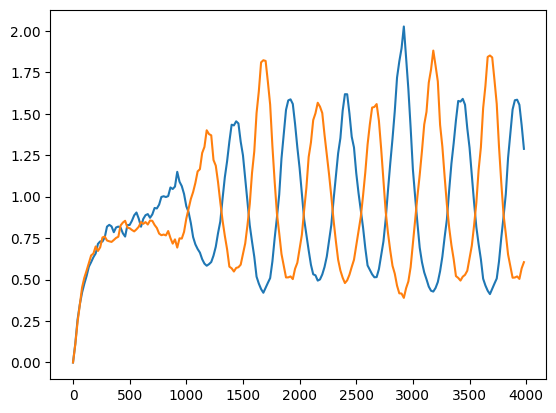

Saving data to D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\expt-filtered-bistable_042225.npz


In [244]:
expt_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','expt-all-bistable_042225.npz', compiled=True)

#Filter Based on total final polarity
polarity_bool = expt_results.score(species='Xb CF_CV', t=-1) < 5

#Filter based on final diff / mean diff
delta_conc = np.abs(expt_results.Xb[CF_CV,:,0,:,1:] - expt_results.Xb[CF_CV,:,0,:,:-1]).mean(axis=(0,-1))
final_diff = expt_results.Xb[CF_CV,:,0,:,-2].max(axis=0) - expt_results.Xb[CF_CV,:,0,:,-2].min(axis=0)
std_bool = (final_diff / delta_conc) < 10

#Filter out models that cant maintain steady state
polarity_scores = expt_results.score(species='Xb CF_CV', t=None, absolute=False)
longest_steady = np.zeros(polarity_scores.shape[1])
current_streak = np.zeros(polarity_scores.shape[1])
for i in range(polarity_scores.shape[0]-1):
    current_streak = np.where((polarity_scores[i+1]*polarity_scores[i])<0, 0, current_streak+1)
    longest_steady = np.where(current_streak>longest_steady, current_streak, longest_steady)
streak_bool = longest_steady <= 30

#Combine all filters
expt_results.plot_timeseries('Xb CF_CV', model_id=35)
final_bool = ~(polarity_bool & std_bool & streak_bool) & expt_results.mask
expt_results = expt_results.subset(final_bool)
expt_results.save('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','expt-filtered-bistable_042225.npz')

## Neg Control Dataset

In [428]:
rng = np.random.default_rng(346294)

# psets from control array
ctrl_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','ctrl-filtered-bistable_042225.npz', compiled=True)
ctrl_chunked = ChunkedResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search\\Ctrl-Model')
ctrl_picks = np.full(10000,False)
ctrl_picks[rng.choice(10000, size=len(ctrl_results), replace=False)] = True
neg_results_1 = ctrl_chunked.subset_to_model_results(ctrl_picks)

# psets from expt array
expt_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','expt-filtered-bistable_042225.npz', compiled=True)
expt_chunked = ChunkedResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search\\Expt-Model')
expt_picks = np.full(10000,False)
expt_picks[rng.choice(10000, size=len(expt_results), replace=False)] = True
neg_results_2 = expt_chunked.subset_to_model_results(expt_picks)

neg_results = neg_results_1.concat([neg_results_2])
neg_results.save('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','negative-data_042525.npz')

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\Ctrl-Model\100151_0.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\Ctrl-Model\100151_0.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\Ctrl-Model\100381_0.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\Ctrl-Model\100517_0.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\Ctrl-Model\100729_0.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\Ctrl-Model\100872_0.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\Ctrl-Model\101010_0.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\Ctrl-Model\101102_0.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\Ctrl-Model\101139_0.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Para

# Figure 2

## Fig 2A - Bistable example

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\expt-filtered-bistable_042225.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\negative-data_042525.npz


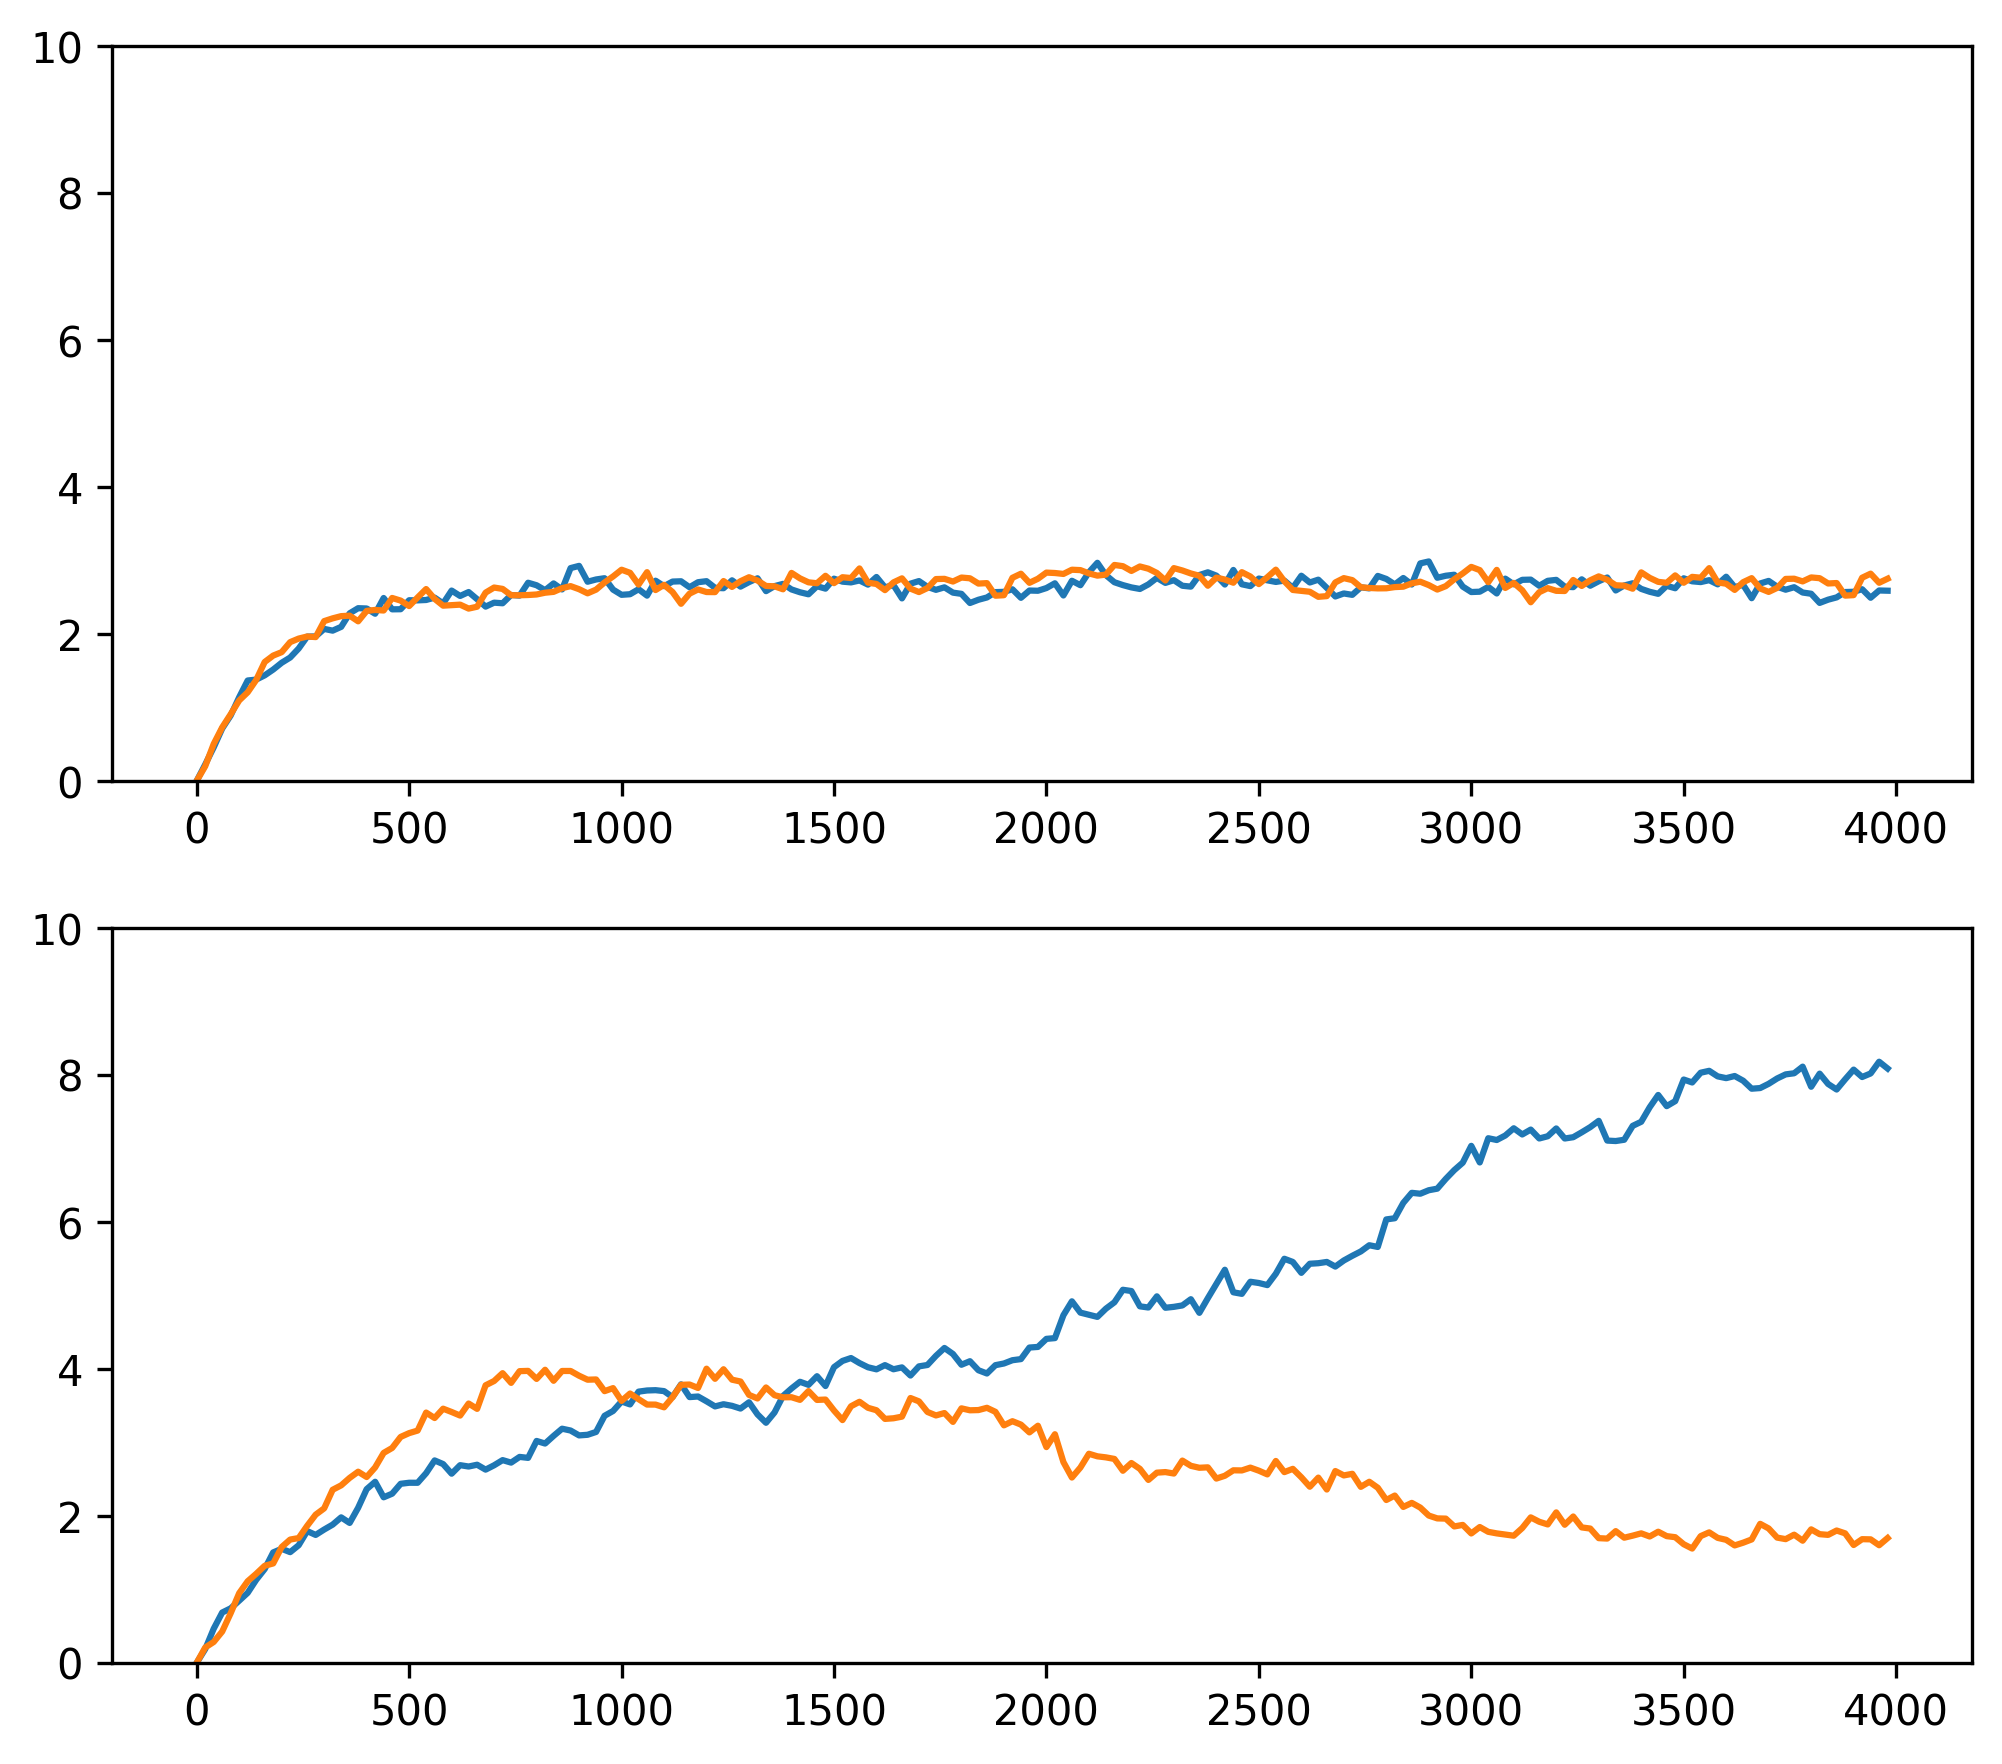

In [596]:
expt_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','expt-filtered-bistable_042225.npz', compiled=True)
neg_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','negative-data_042525.npz', compiled=True)

fig,axes = plt.subplots(nrows=2, figsize=(8,7), sharey=True, dpi=300)

expt_results.plot_timeseries('Xb CF_CV', model_id=8, axis=axes[1], show=False)
axes[1].set_ylim(0,10)

neg_results.plot_timeseries('Xb CF_CV', model_id=9, axis=axes[0], show=False)
axes[0].set_ylim(0,10)

plt.show()


## Fig 2B - Polarity score hist

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\expt-filtered-bistable_042225.npz


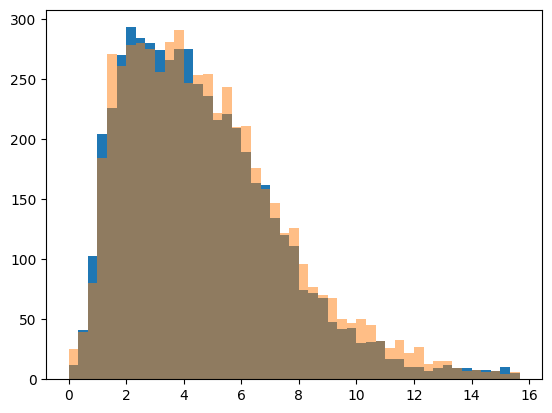

In [429]:
ctrl_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','ctrl-filtered-bistable_042225.npz', compiled=True)
expt_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','expt-filtered-bistable_042225.npz', compiled=True)

ctrl_scores = ctrl_results.score(species='Xb CF_CVP')
expt_scores = expt_results.score(species='Xb CF_CVP')

plt.hist(ctrl_scores, bins=[i/3 for i in range(48)])
plt.hist(expt_scores, bins=[i/3 for i in range(48)], alpha=0.5)

plt.show()

## Fig 2C-D - PCA

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\expt-filtered-bistable_042225.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\negative-data_042525.npz


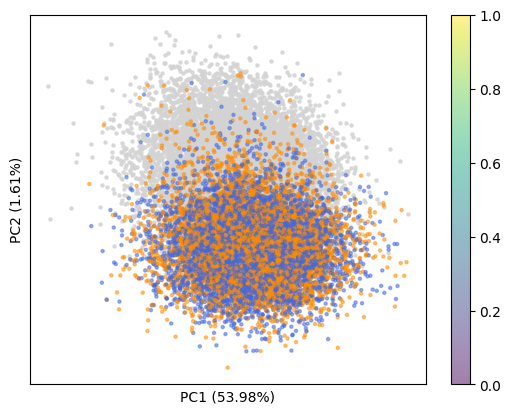

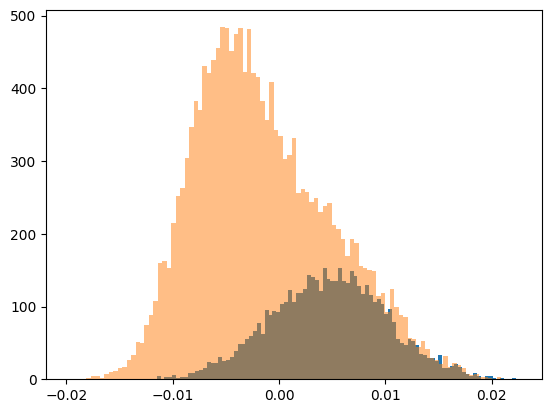

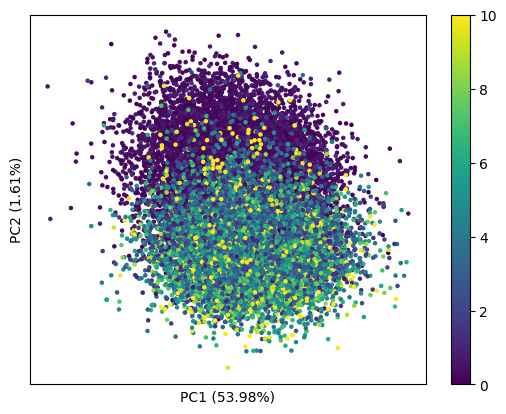

In [500]:
ctrl_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','ctrl-filtered-bistable_042225.npz', compiled=True)
expt_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','expt-filtered-bistable_042225.npz', compiled=True)
neg_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','negative-data_042525.npz', compiled=True)

#Subset params to not include kcat_VDp or km_VDp
params = [i for i in range(76) if i not in [kcat_VDp, km_VDp]]
ctrl_params = ctrl_results.Xp[params,0,0,:]
expt_params = expt_results.Xp[params,0,0,:]
neg_params  = neg_results.Xp[params,0,0,:]

#Randomly order positive dots
rng = np.random.default_rng(54363)
n_ctrl = ctrl_params.shape[1]
n_expt = expt_params.shape[1]
n_neg  = neg_params.shape[1]
n_pos = n_ctrl + n_expt
order = rng.choice(n_pos, size=n_pos, replace=False)

#Run PCA
all_params = np.concat([neg_params,ctrl_params,expt_params], axis=1)
pca = PCA(n_components=50).fit(all_params)
pc1 = pca.components_[0]
pc2 = pca.components_[1]
neg_pc1, pos_pc1 = pc1[:n_neg], pc1[n_neg:]
neg_pc2, pos_pc2 = pc2[:n_neg], pc2[n_neg:]

##### FIG 2C #####
colors = np.array(['royalblue' for i in range(n_ctrl)] + ['darkorange' for i in range(n_expt)])
plt.scatter(neg_pc1, neg_pc2, c='lightgrey', s=5, alpha=0.8)
plt.scatter(pos_pc1[order], pos_pc2[order], color=colors[order], s=5, alpha=0.5)
plt.xlabel(f'PC1 ({np.round(pca.explained_variance_ratio_[0]*100, 2)}%)')
plt.ylabel(f'PC2 ({np.round(pca.explained_variance_ratio_[1]*100, 2)}%)')
plt.colorbar()
plt.xticks([],[])
plt.yticks([],[])
plt.show()

########
pc1 = pca.components_[1]
plt.hist(pc1[:n_ctrl], bins=100)
plt.hist(pc1[n_ctrl:], alpha=0.5, bins=100)
plt.show()
########

##### FIG 2D #####
neg_scores = neg_results.score(species='Xb CF_CVP')
pos_scores = np.concat([ctrl_results.score(species='Xb CF_CVP'), expt_results.score(species='Xb CF_CVP')])

plt.scatter(neg_pc1, neg_pc2, c=neg_scores, s=5, vmin=0, vmax=10)
plt.scatter(pos_pc1[order], pos_pc2[order], c=pos_scores[order], s=5, vmin=0, vmax=10)
plt.xlabel(f'PC1 ({np.round(pca.explained_variance_ratio_[0]*100, 2)}%)')
plt.ylabel(f'PC2 ({np.round(pca.explained_variance_ratio_[1]*100, 2)}%)')
plt.colorbar()
plt.xticks([],[])
plt.yticks([],[])
plt.show()

##### FIG 2E #####
# params_to_plot = [k5, k7m, k7min, k24a]
# for param in params_to_plot:
#     print(param)
#     neg_params  = neg_results.Xp[param,0,0,:]
#     pos_params = np.concat([ctrl_results.Xp[param,0,0,:], expt_results.Xp[param,0,0,:]])
    
#     plt.scatter(neg_pc1, neg_pc2, c=neg_params, s=5, vmin=0, vmax=10)
#     plt.scatter(pos_pc1[order], pos_pc2[order], c=pos_params[order], s=5, vmin=0, vmax=10)
#     plt.xlabel(f'PC1 ({np.round(pca.explained_variance_ratio_[0]*100, 2)}%)')
#     plt.ylabel(f'PC2 ({np.round(pca.explained_variance_ratio_[1]*100, 2)}%)')
#     plt.colorbar()
#     plt.xticks([],[])
#     plt.yticks([],[])
#     plt.show()

## Fig 2E - Param violin plots

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\expt-filtered-bistable_042225.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\negative-data_042525.npz


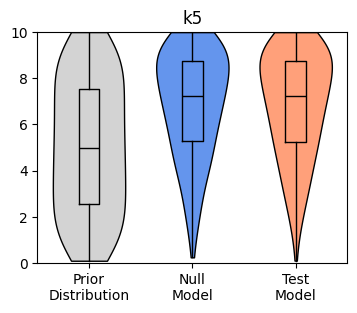

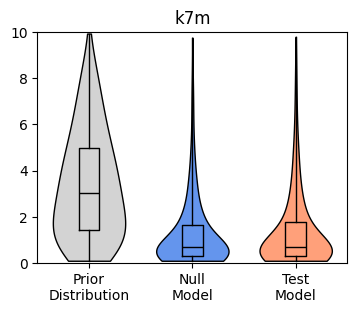

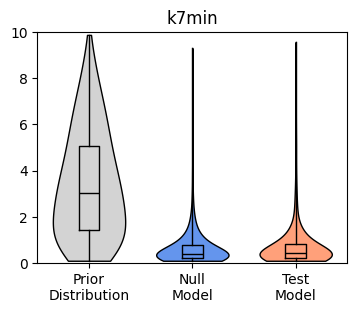

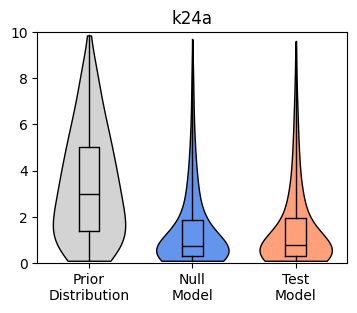

In [595]:
ctrl_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','ctrl-filtered-bistable_042225.npz', compiled=True)
expt_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','expt-filtered-bistable_042225.npz', compiled=True)
neg_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','negative-data_042525.npz', compiled=True)

params_to_plot = [k5, k7m, k7min, k24a]
for param in params_to_plot:
    boxplot_data = [neg_results.Xp[param,0,0,:], ctrl_results.Xp[param,0,0,:], expt_results.Xp[param,0,0,:]]

    plt.figure(figsize=(4, 3), dpi=100)

    #Boxplot
    # boxplot = plt.boxplot(boxplot_data, whis=(5,95), showfliers=False, medianprops={'color':'black'}, patch_artist=True)
    # for patch, color in zip(boxplot['boxes'], ['lightgrey','cornflowerblue','lightsalmon']):
    #     patch.set_facecolor(color)

    #Violon plot
    violinplot = plt.violinplot(boxplot_data, showextrema=False, showmedians=False, widths=0.7, points=200, bw_method=0.4)
    # violinplot['cmedians'].set_color('black')
    for violin, color in zip(violinplot['bodies'], ['lightgrey','cornflowerblue','lightsalmon']):
        violin.set_facecolor(color)
        violin.set_edgecolor('black')
        violin.set_alpha(1)
    boxplot = plt.boxplot(boxplot_data, whis=(0,100), showfliers=False, medianprops={'color':'black'}, widths=0.2, capwidths=0.0)
    
    plt.ylim(0,10)
    plt.xticks([1,2,3], ['Prior\nDistribution', 'Null\nModel','Test\nModel'])
    plt.title(Xp_params[param])
    plt.show()

## Detemine quartiles

In [3]:
expt_results = ModelResults_1d('D:\\Modeling','expt-filtered-bistable_042225.npz', compiled=True)

argsort = np.argsort(expt_results.Xp[kcat_VDp,0,0])
kcat_VDp_quartiles = [argsort[:1409], argsort[1409:2818], argsort[2818:4227], argsort[4227:]]
kcat_VDp_halves = [argsort[:2818], argsort[2818:]]

argsort = np.argsort(expt_results.Xp[km_VDp,0,0])
km_VDp_quartiles = [argsort[:1409], argsort[1409:2818], argsort[2818:4227], argsort[4227:]]
km_VDp_halves = [argsort[:2818], argsort[2818:]]

Loading data from D:\Modeling\expt-filtered-bistable_042225.npz


## Fig 2F - Polarity score (CF_CVP)

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\expt-filtered-bistable_042225.npz

Ctrl Mean:  4.698944949391682 

Half-1 Mean:  4.837302808033261
SEM:  0.05362905674400941
pval:  0.03089862421814762

Half-2 Mean:  4.894330940595095
SEM:  0.05426275089551957
pval:  0.0035718627149121805



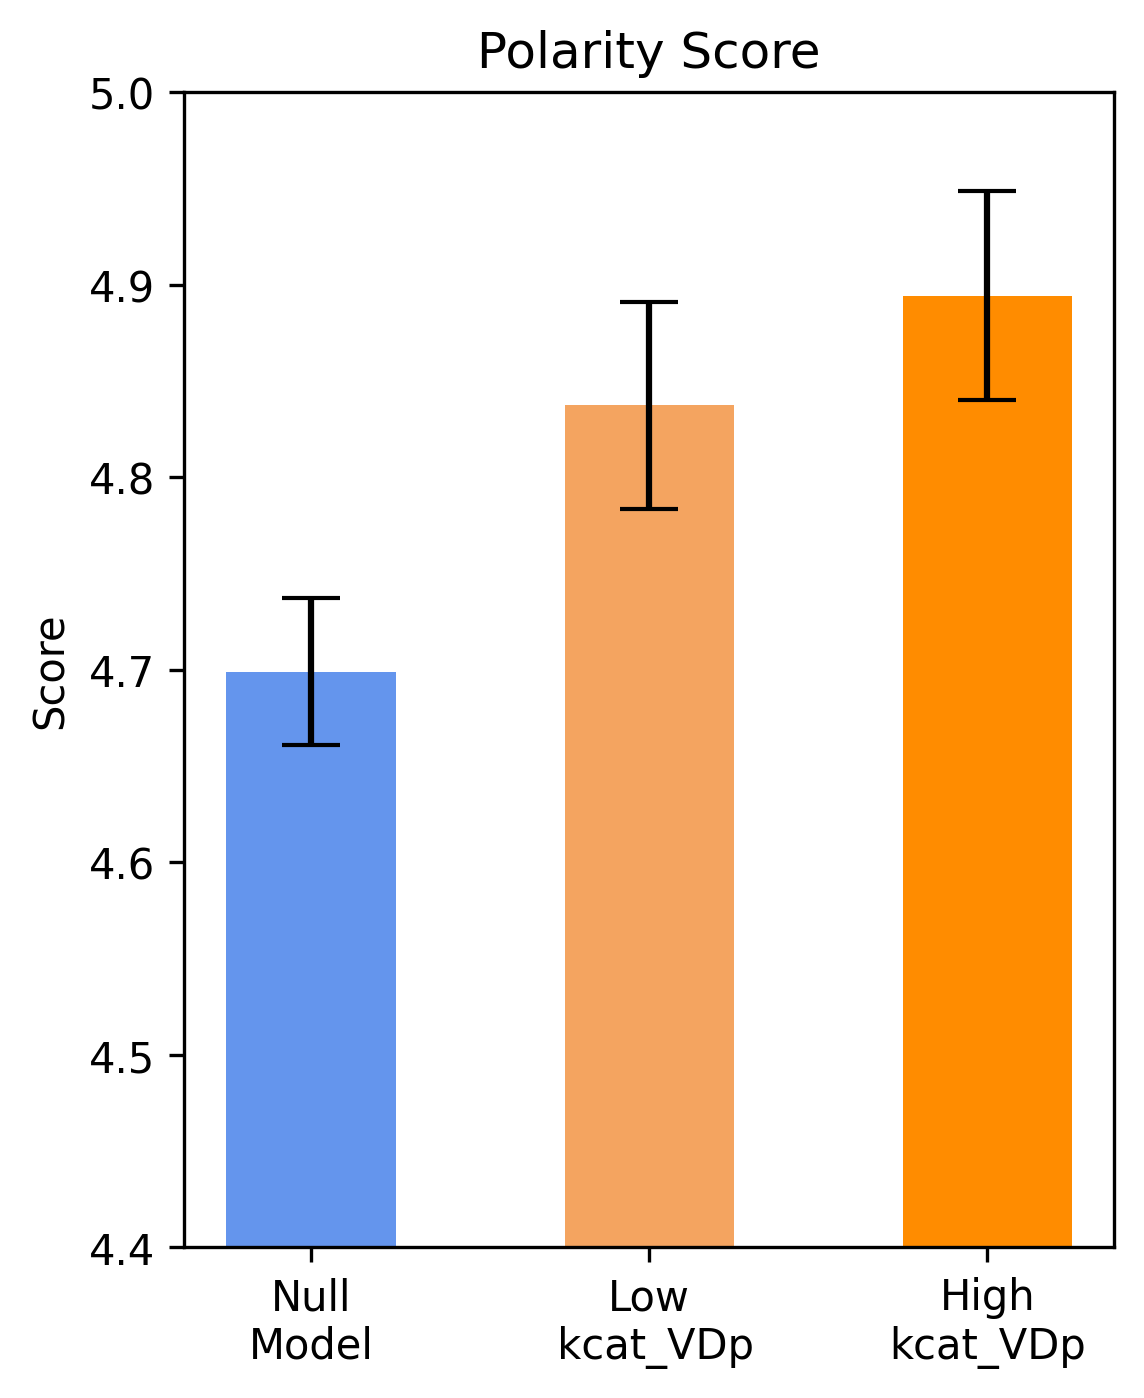

In [506]:
ctrl_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','ctrl-filtered-bistable_042225.npz', compiled=True)
expt_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','expt-filtered-bistable_042225.npz', compiled=True)

ctrl_scores = ctrl_results.score(species='Xb CF_CVP')
expt_scores = expt_results.score(species='Xb CF_CVP')

# print('Mean Ctrl: ', np.mean(ctrl_scores))
# print('Mean Expt: ', np.mean(expt_scores))
# print('pval: ', ttest(ctrl_scores, expt_scores).pvalue)

# Divide up the data to quartiles or low-high
# data = [ctrl_scores]
# for quartile in kcat_VDp_quartiles:
#     data.append(expt_scores[quartile])

data2 = [ctrl_scores]
for half in kcat_VDp_halves:
    data2.append(expt_scores[half])


### PLOT LOW-HGIH ###
print('\nCtrl Mean: ', data2[0].mean(),'\n')
for i,d in enumerate(data2[1:]):
    print(f'Half-{i+1} Mean: ', d.mean())
    print('SEM: ', np.std(d)/np.sqrt(len(d)))
    print('pval: ', ranksums(data2[0], d).pvalue)
    print()
    
plt.figure(figsize=(4, 5), dpi=300)
plt.bar([0, 1, 2], height=[d.mean() for d in data2], yerr=[np.std(d)/np.sqrt(len(d)) for d in data2], capsize=7.0, color=['cornflowerblue','sandybrown','darkorange'], width=0.5)
# plt.yscale('log')
plt.ylim((4.4,5.0))
plt.xticks([0,1,2], ['Null\nModel', 'Low\n kcat_VDp','High\nkcat_VDp'])
plt.ylabel('Score')
plt.title('Polarity Score')
plt.show()

## Fig 2G - Indeterminate Phase Length

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\expt-filtered-bistable_042225.npz


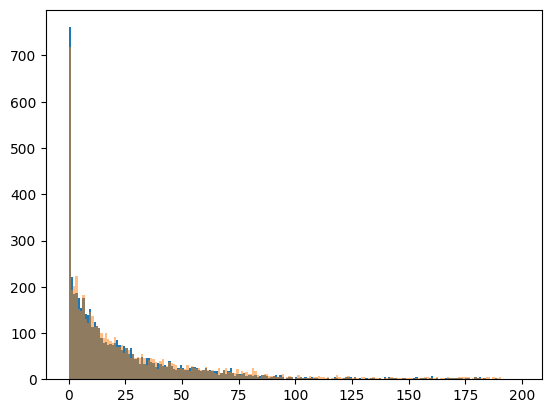


Ctrl Mean:  24.75438920717058 

Half-1 Mean:  26.552874378992193
SEM:  0.6371635332908129
pval:  0.0615698546363007

Half-2 Mean:  29.205746718694574
SEM:  0.6968220222275768
pval:  3.21349601130765e-06



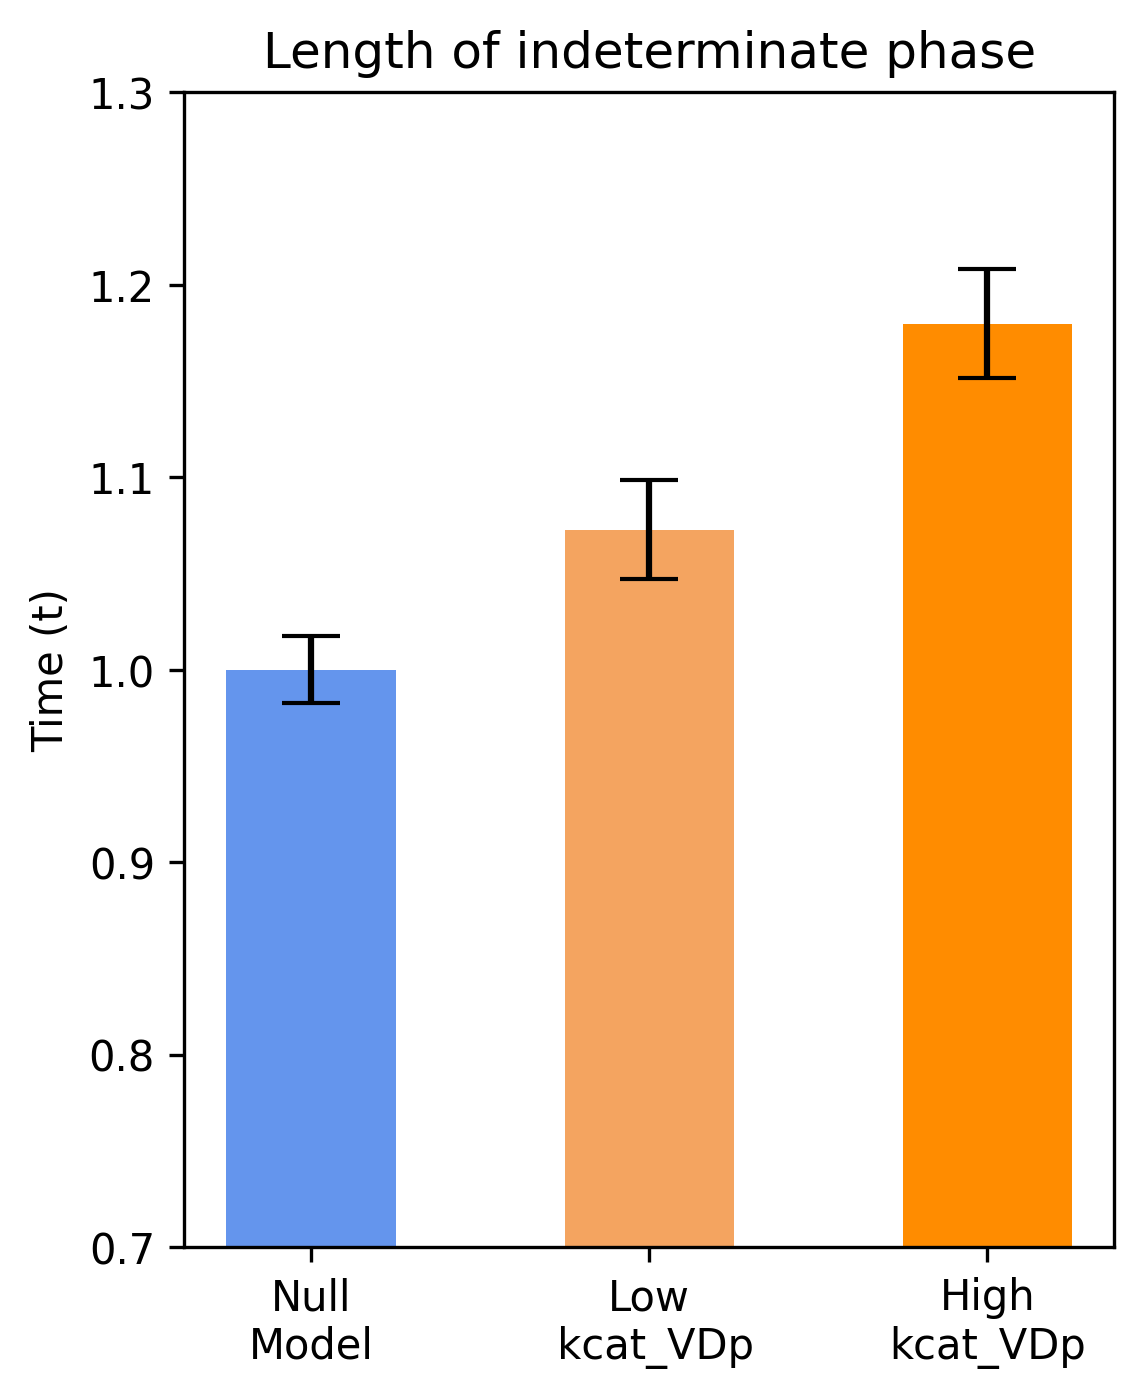

In [507]:
ctrl_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','ctrl-filtered-bistable_042225.npz', compiled=True)
polarity_scores = ctrl_results.score(species='Xb CF_CV', t=None, absolute=False)
ctrl_last_switch = np.zeros(polarity_scores.shape[1])
for i in range(polarity_scores.shape[0]-1):
    ctrl_last_switch = np.where((polarity_scores[i+1]*polarity_scores[i])<0, i, ctrl_last_switch)
plt.hist(ctrl_last_switch, bins=[i for i in range(200)])

expt_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','expt-filtered-bistable_042225.npz', compiled=True)
polarity_scores = expt_results.score(species='Xb CF_CV', t=None, absolute=False)
expt_last_switch = np.zeros(polarity_scores.shape[1])
for i in range(polarity_scores.shape[0]-1):
    expt_last_switch = np.where((polarity_scores[i+1]*polarity_scores[i])<0, i, expt_last_switch)
plt.hist(expt_last_switch, bins=[i for i in range(200)], alpha=0.5)
plt.show()

# Divide up the data to quartiles or low-high
data = [ctrl_last_switch]
for quartile in kcat_VDp_quartiles:
    data.append(expt_last_switch[quartile])

data2 = [ctrl_last_switch]
for half in kcat_VDp_halves:
    data2.append(expt_last_switch[half])


### PLOT LOW-HGIH ###
print('\nCtrl Mean: ', data[0].mean(),'\n')
for i,d in enumerate(data2[1:]):
    print(f'Half-{i+1} Mean: ', d.mean())
    print('SEM: ', np.std(d)/np.sqrt(len(d)))
    print('pval: ', ranksums(data[0], d).pvalue)
    print()
    
plt.figure(figsize=(4, 5), dpi=300)
plt.bar([0, 1, 2], height=[d.mean()/data2[0].mean() for d in data2], yerr=[np.std(d)/(np.sqrt(len(d))*data2[0].mean()) for d in data2], 
        capsize=7.0, color=['cornflowerblue','sandybrown','darkorange'], width=0.5)
# plt.yscale('log')
plt.ylim((0.7,1.3))
plt.xticks([0,1,2], ['Null\nModel', 'Low\n kcat_VDp','High\nkcat_VDp'])
plt.ylabel('Time (t)')
plt.title('Length of indeterminate phase')
plt.show()

## Fig 2H - Num Polarity Inversions

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\expt-filtered-bistable_042225.npz


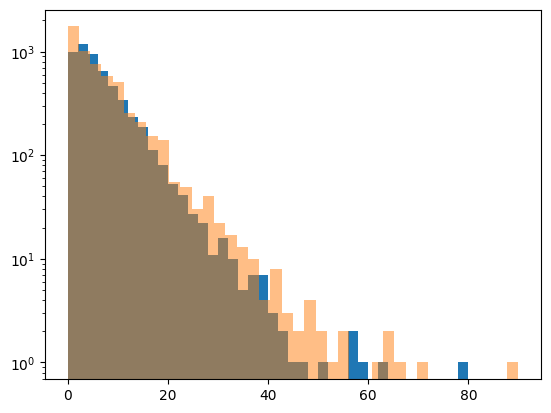

Ctrl Mean:  6.171132877471817
Expt Mean:  6.830228845130389
pval:  2.854600050632386e-07

Ctrl Mean:  6.171132877471817 

Half-1 Mean:  6.585521646557843
SEM:  0.12911984066429982
pval:  0.037116253387814914

Half-2 Mean:  7.074849237318198
SEM:  0.14007669093647676
pval:  6.3954964680693274e-06



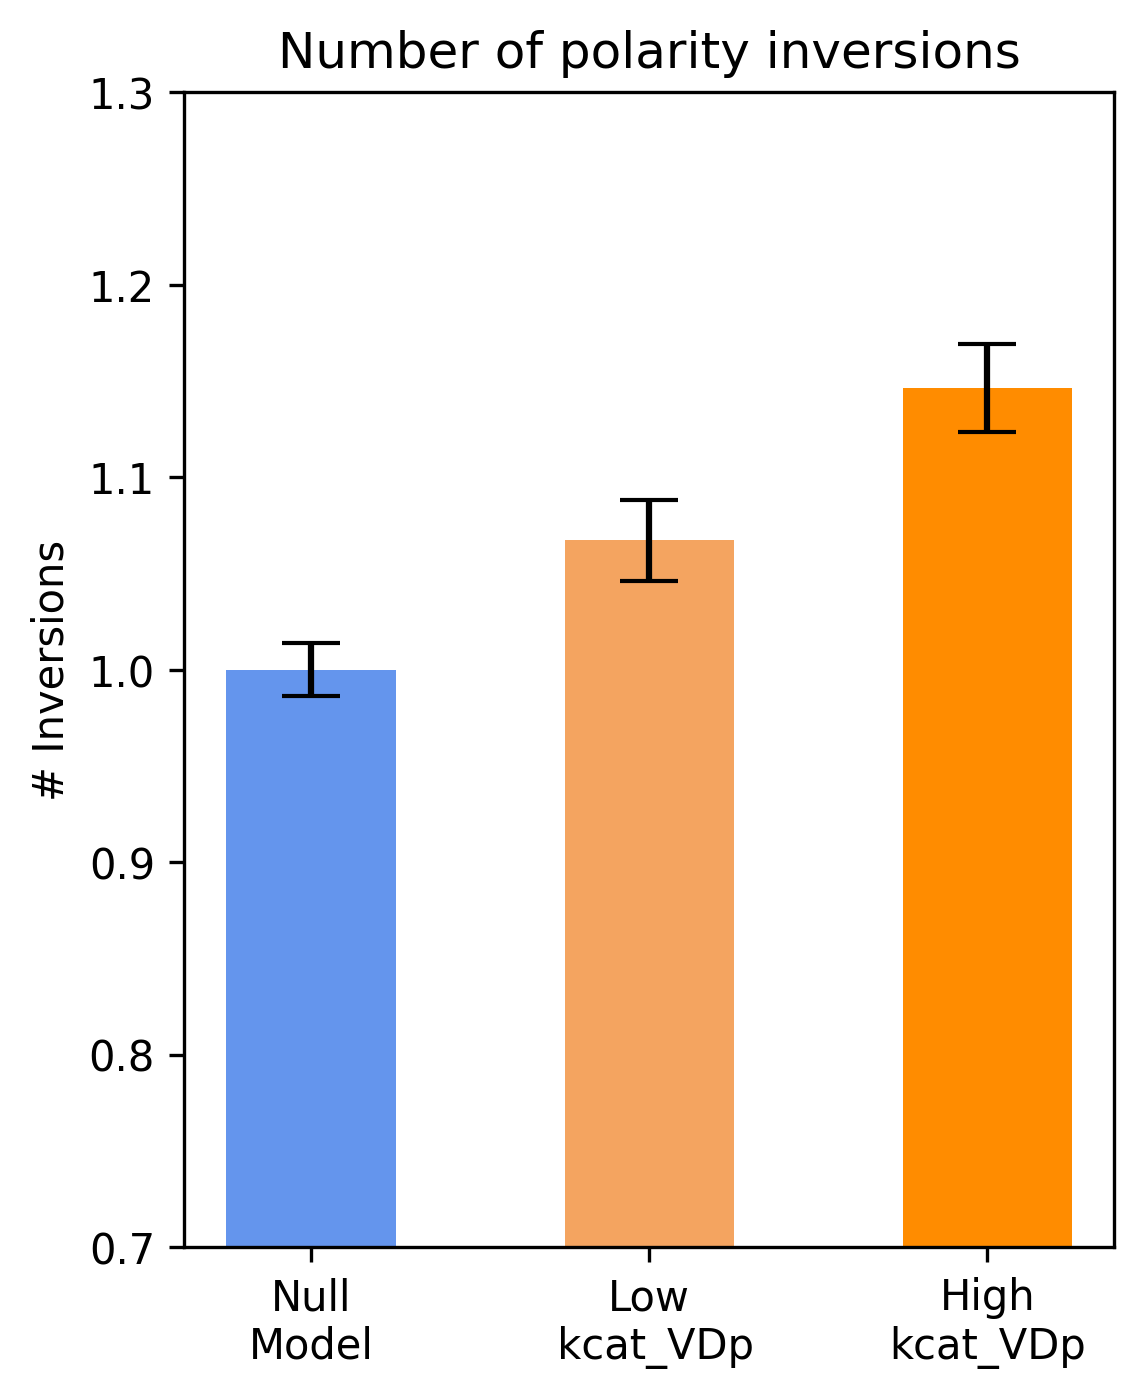

In [510]:
ctrl_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','ctrl-filtered-bistable_042225.npz', compiled=True)
polarity_scores = ctrl_results.score(species='Xb CF_CV', t=None, absolute=False)
ctrl_num_switches = np.zeros(polarity_scores.shape[1])
for i in range(polarity_scores.shape[0]-1):
    ctrl_num_switches = np.where((polarity_scores[i+1]*polarity_scores[i])<0, ctrl_num_switches+1, ctrl_num_switches)
plt.hist(ctrl_num_switches, bins=40, log=True)

expt_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','expt-filtered-bistable_042225.npz', compiled=True)
polarity_scores = expt_results.score(species='Xb CF_CV', t=None, absolute=False)
expt_num_switches = np.zeros(polarity_scores.shape[1])
for i in range(polarity_scores.shape[0]-1):
    expt_num_switches = np.where((polarity_scores[i+1]*polarity_scores[i])<0, expt_num_switches+1, expt_num_switches)
plt.hist(expt_num_switches, bins=40, log=True, alpha=0.5)

plt.show()

print('Ctrl Mean: ', ctrl_num_switches.mean())
print('Expt Mean: ', expt_num_switches.mean())
print('pval: ', ttest(ctrl_num_switches,expt_num_switches).pvalue)



# Divide up the data to quartiles or low-high
data = [ctrl_num_switches]
for quartile in kcat_VDp_quartiles:
    data.append(expt_num_switches[quartile])

data2 = [ctrl_num_switches]
for half in kcat_VDp_halves:
    data2.append(expt_num_switches[half])


### PLOT LOW-HGIH ###
print('\nCtrl Mean: ', data[0].mean(),'\n')
for i,d in enumerate(data2[1:]):
    print(f'Half-{i+1} Mean: ', d.mean())
    print('SEM: ', np.std(d)/np.sqrt(len(d)))
    print('pval: ', ranksums(data[0], d).pvalue)
    print()
    
plt.figure(figsize=(4, 5), dpi=300)
plt.bar([0, 1, 2], height=[d.mean()/data2[0].mean() for d in data2], yerr=[np.std(d)/(np.sqrt(len(d))*data2[0].mean()) for d in data2], capsize=7.0, color=['cornflowerblue','sandybrown','darkorange'], width=0.5)
# plt.yscale('log')
plt.ylim((0.7,1.3))
plt.xticks([0,1,2], ['Null\nModel', 'Low\n kcat_VDp','High\nkcat_VDp'])
plt.ylabel('# Inversions')
plt.title('Number of polarity inversions')
plt.show()

## Fig 2I - Compare max delta

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\expt-filtered-bistable_042225.npz


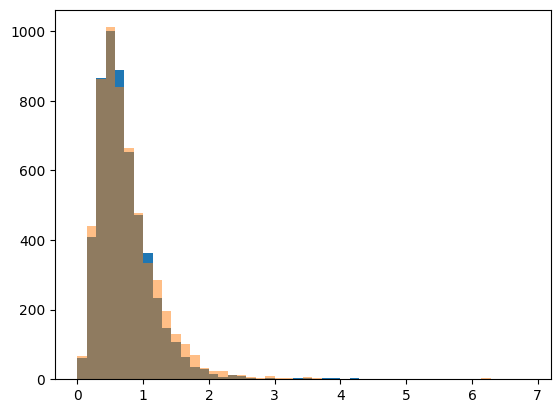

Ctrl Mean:  0.7269329943484032
Expt Mean:  0.7617396642353124
pval:  0.00019288093858332885

Ctrl Mean:  0.7269329943484032 

Half-1 Mean:  0.7558806914986207
SEM:  0.009891310738053978
pval:  0.15939274044665797

Half-2 Mean:  0.7675965585850807
SEM:  0.009293704355390646
pval:  0.002167912457988149



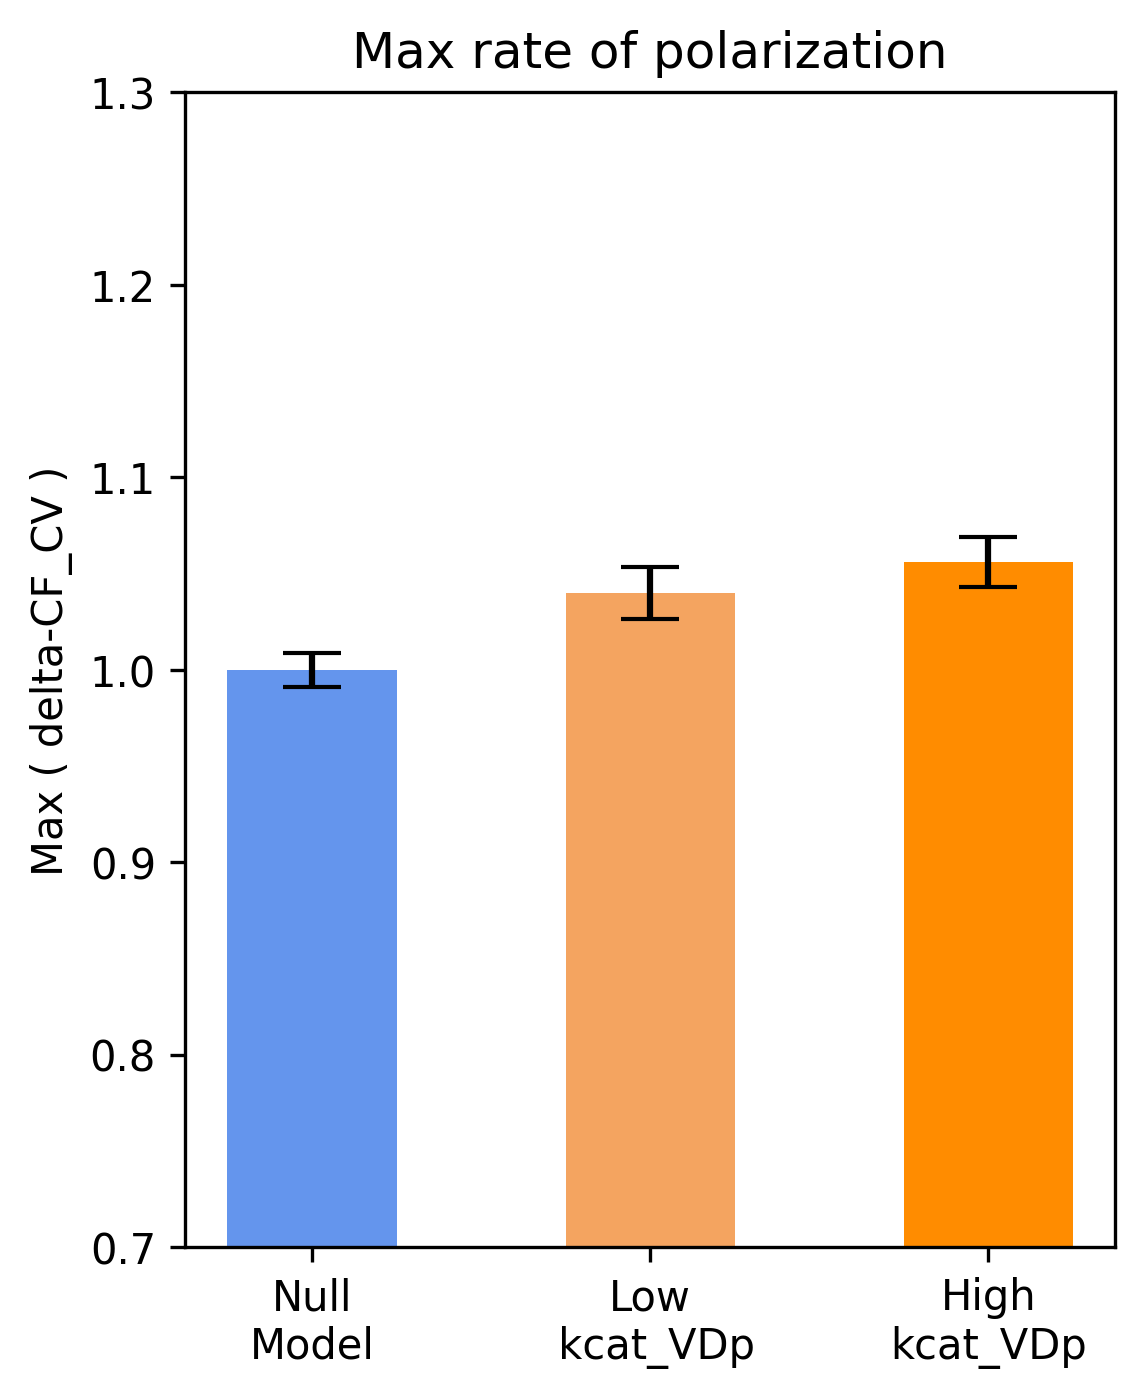

In [513]:
ctrl_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','ctrl-filtered-bistable_042225.npz', compiled=True)
ctrl_max_delta = (ctrl_results.Xb[CF_CV,:,0,:,1:] - ctrl_results.Xb[CF_CV,:,0,:,:-1]).max(axis=(0,-1))
plt.hist(ctrl_max_delta, bins=[i/7 for i in range(49)])

expt_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','expt-filtered-bistable_042225.npz', compiled=True)
expt_max_delta = (expt_results.Xb[CF_CV,:,0,:,2:] - expt_results.Xb[CF_CV,:,0,:,1:-1]).max(axis=(0,-1))
plt.hist(expt_max_delta, bins=[i/7 for i in range(49)], alpha=0.5)

plt.show()
print('Ctrl Mean: ', ctrl_max_delta.mean())
print('Expt Mean: ', expt_max_delta.mean())
print('pval: ', ttest(ctrl_max_delta,expt_max_delta).pvalue)



# Divide up the data to quartiles or low-high
data = [ctrl_max_delta]
for quartile in kcat_VDp_quartiles:
    data.append(expt_max_delta[quartile])

data2 = [ctrl_max_delta]
for half in kcat_VDp_halves:
    data2.append(expt_max_delta[half])


### PLOT LOW-HGIH ###
print('\nCtrl Mean: ', data[0].mean(),'\n')
for i,d in enumerate(data2[1:]):
    print(f'Half-{i+1} Mean: ', d.mean())
    print('SEM: ', np.std(d)/np.sqrt(len(d)))
    print('pval: ', ranksums(data[0], d).pvalue)
    print()
    
plt.figure(figsize=(4, 5), dpi=300)
plt.bar([0, 1, 2], height=[d.mean()/data2[0].mean() for d in data2], yerr=[np.std(d)/(np.sqrt(len(d))*data2[0].mean()) for d in data2], capsize=7.0, color=['cornflowerblue','sandybrown','darkorange'], width=0.5)
# plt.yscale('log')
plt.ylim((0.7,1.3))
plt.xticks([0,1,2], ['Null\nModel', 'Low\n kcat_VDp','High\nkcat_VDp'])
plt.ylabel('Max ( delta-CF_CV )')
plt.title('Max rate of polarization')
plt.show()

## Fig 2J - Final CF_CV concentration

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\expt-filtered-bistable_042225.npz


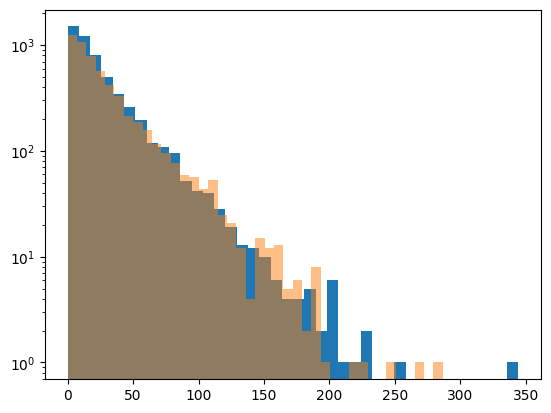

Mean Ctrl:  26.747206362984745
Mean Expt:  28.846382649828836
pval:  0.00021596375822981585

Ctrl Mean:  26.747206362984745 

Half-1 Mean:  28.47326470787305
SEM:  0.5791136817350583
pval:  0.09002867571847248

Half-2 Mean:  29.219368233522136
SEM:  0.5740087820672596
pval:  0.0003901622141720141



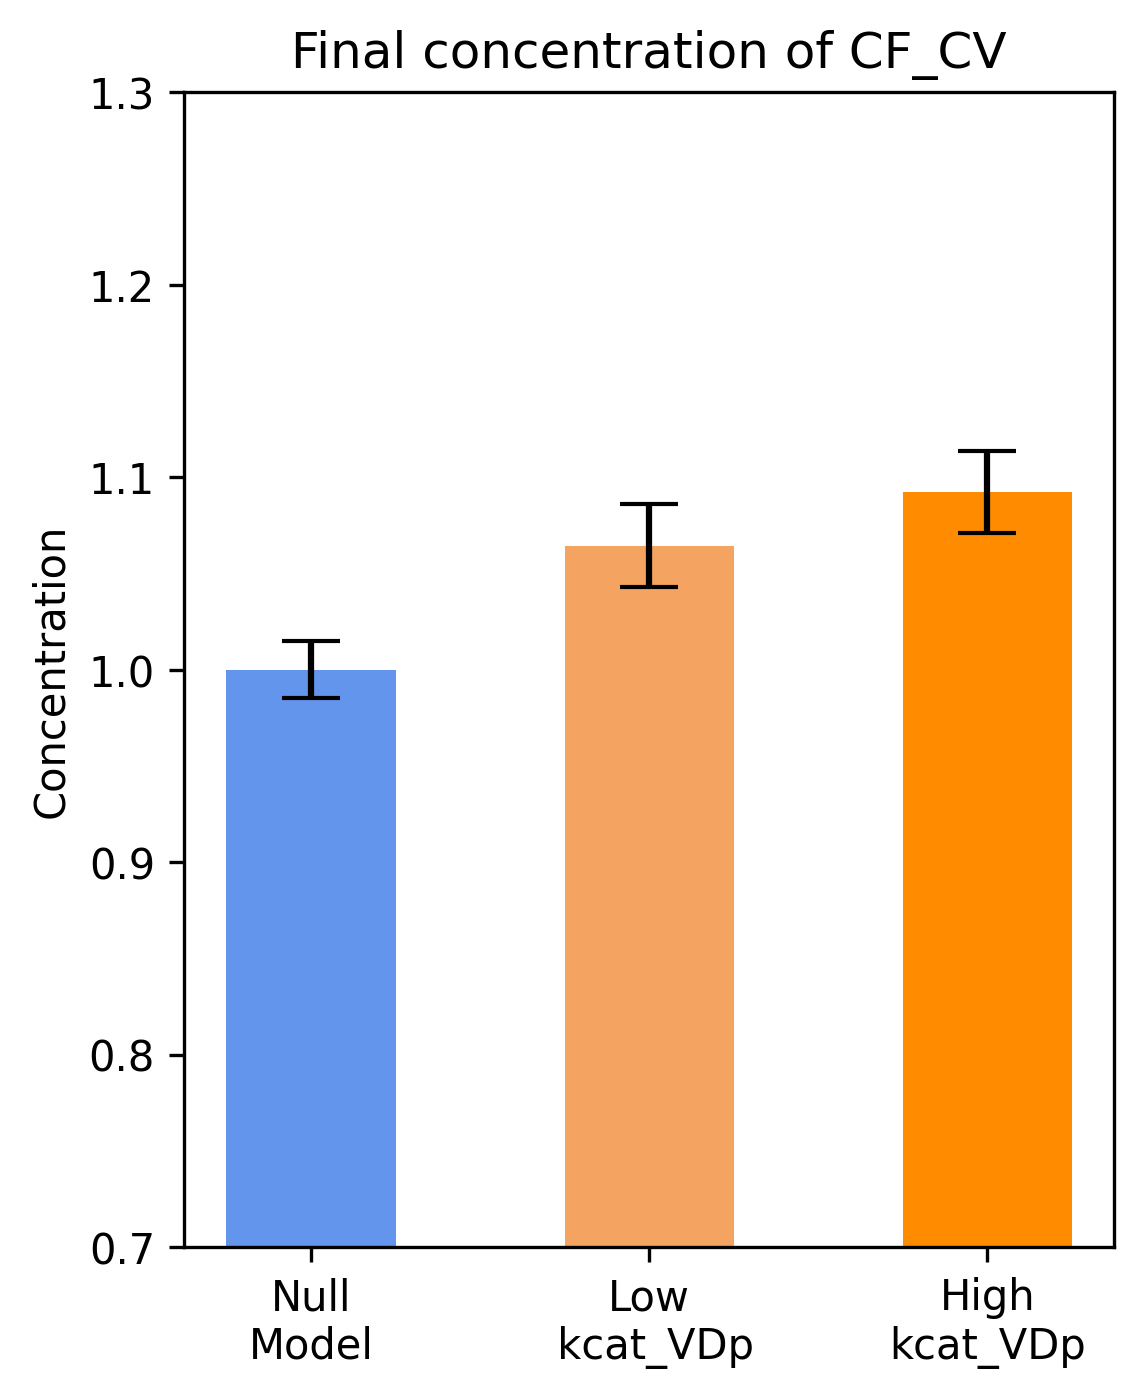

In [514]:
ctrl_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','ctrl-filtered-bistable_042225.npz', compiled=True)
ctrl_total_complex = ctrl_results.Xb[CF_CV,0,0,:,-1] + ctrl_results.Xb[CF_CV,1,0,:,-1]
plt.hist(ctrl_total_complex, bins=40, log=True)

expt_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','expt-filtered-bistable_042225.npz', compiled=True)
expt_total_complex = expt_results.Xb[CF_CV,0,0,:,-1] + expt_results.Xb[CF_CV,1,0,:,-1]
plt.hist(expt_total_complex, bins=40, log=True, alpha=0.5)

plt.show()

print('Mean Ctrl: ', ctrl_total_complex.mean())
print('Mean Expt: ', expt_total_complex.mean())
print('pval: ', ttest(ctrl_total_complex, expt_total_complex).pvalue)

# Divide up the data to quartiles or low-high
data = [ctrl_total_complex]
for quartile in kcat_VDp_quartiles:
    data.append(expt_total_complex[quartile])

data2 = [ctrl_total_complex]
for half in kcat_VDp_halves:
    data2.append(expt_total_complex[half])


### PLOT LOW-HGIH ###
print('\nCtrl Mean: ', data[0].mean(),'\n')
for i,d in enumerate(data2[1:]):
    print(f'Half-{i+1} Mean: ', d.mean())
    print('SEM: ', np.std(d)/np.sqrt(len(d)))
    print('pval: ', ranksums(data[0], d).pvalue)
    print()
    
plt.figure(figsize=(4, 5), dpi=300)
plt.bar([0, 1, 2], height=[d.mean()/data2[0].mean() for d in data2], yerr=[np.std(d)/(np.sqrt(len(d))*data2[0].mean()) for d in data2], capsize=7.0, color=['cornflowerblue','sandybrown','darkorange'], width=0.5)
# plt.yscale('log')
plt.ylim((0.7,1.3))
plt.xticks([0,1,2], ['Null\nModel', 'Low\n kcat_VDp','High\nkcat_VDp'])
plt.ylabel('Concentration')
plt.title('Final concentration of CF_CV')
plt.show()

# Supplemental figures

## Fig S2 - Param Boxplots

### Ctrl model

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\ctrl-filtered-bistable_042225.npz


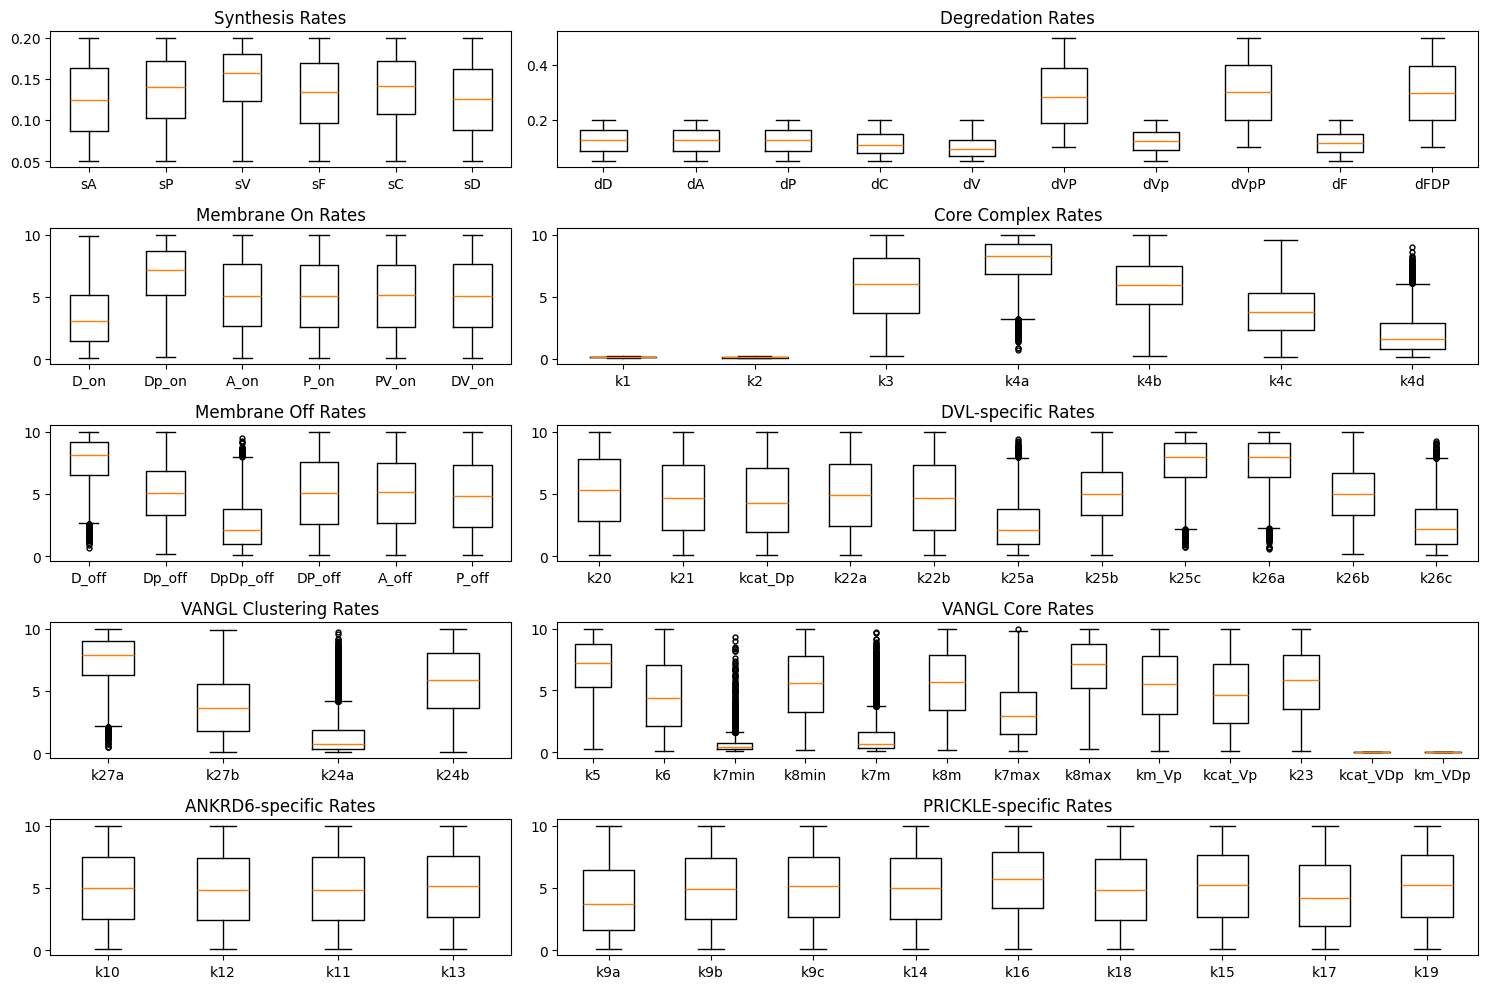

In [453]:
ctrl_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','ctrl-filtered-bistable_042225.npz', compiled=True)
ctrl_results.plotall_params()

### Expt model

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\expt-filtered-bistable_042225.npz


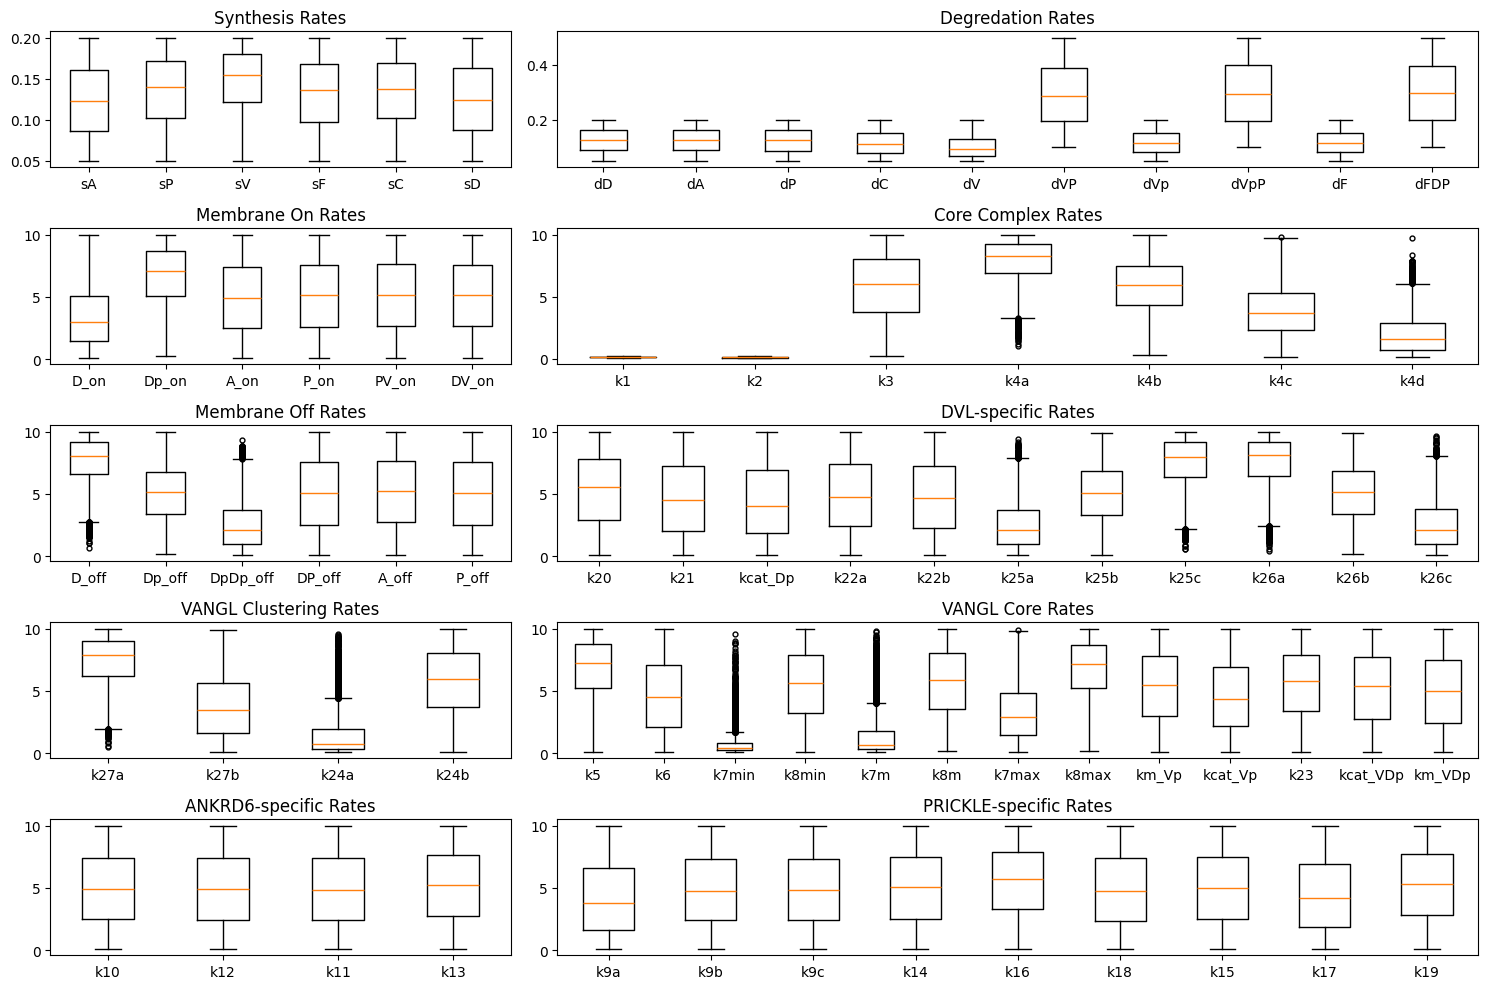

In [454]:
expt_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','expt-filtered-bistable_042225.npz', compiled=True)
expt_results.plotall_params()

### Neg ctrl data

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\negative-data_042525.npz


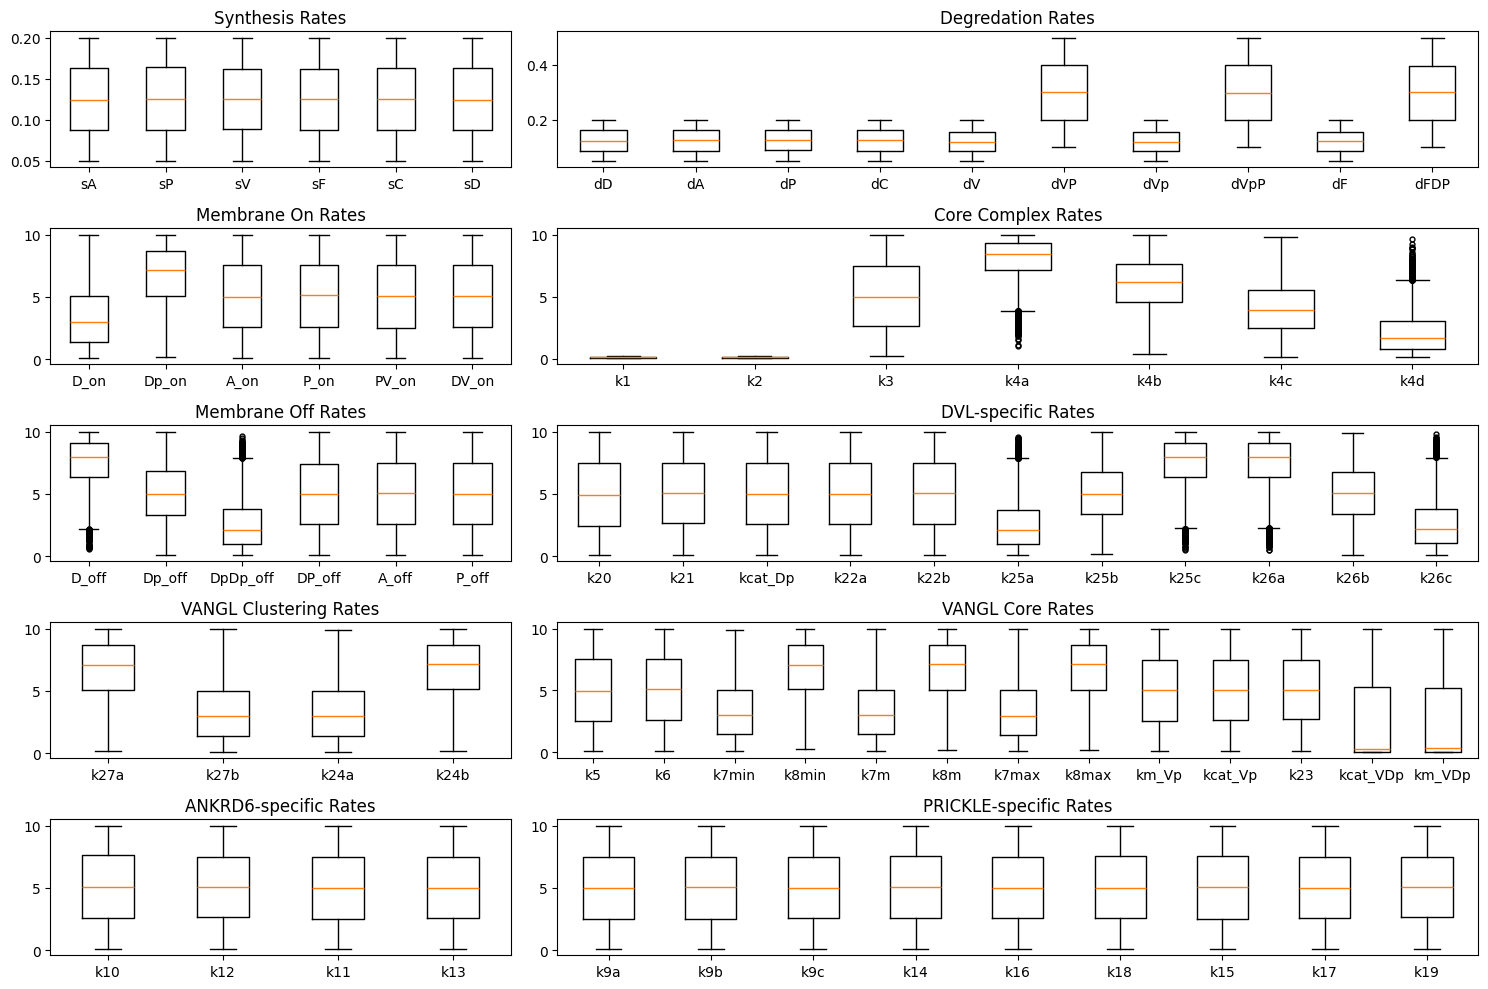

In [455]:
neg_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','negative-data_042525.npz', compiled=True)
neg_results.plotall_params()

### Calculate p vals

In [471]:
neg_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','negative-data_042525.npz', compiled=True)
ctrl_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','ctrl-filtered-bistable_042225.npz', compiled=True)
expt_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','expt-filtered-bistable_042225.npz', compiled=True)

results = {'Ctrl':[], 'Expt':[]}
for i,param in enumerate(Xp_params):
    neg_dist = neg_results.Xp[i,0,0,:]
    ctrl_dist = ctrl_results.Xp[i,0,0,:]
    expt_dist = expt_results.Xp[i,0,0,:]

    results['Ctrl'].append(ttest(neg_dist, ctrl_dist).pvalue)
    results['Expt'].append(ttest(neg_dist, expt_dist).pvalue)
    
df = pd.DataFrame(results, index=Xp_params)
print()
display(df['Ctrl'].sort_values().head(20))
print('\n\n')
display(df['Expt'].sort_values().head(20))


Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\negative-data_042525.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\expt-filtered-bistable_042225.npz



kcat_VDp     0.000000e+00
k7m          0.000000e+00
k7min        0.000000e+00
km_VDp       0.000000e+00
k5           0.000000e+00
k24a         0.000000e+00
sV          1.199053e-251
k8min       5.990735e-198
dV          3.153631e-197
k8m         1.757333e-161
k24b        7.866472e-140
k27a        5.900922e-100
k9a          4.153791e-74
sC           1.347470e-69
k3           1.850545e-62
dC           1.059455e-48
sP           2.898619e-40
k23          6.106842e-36
k17          1.054273e-31
k27b         1.519621e-30
Name: Ctrl, dtype: float64

kcat_VDp     0.000000e+00
k7m          0.000000e+00
k7min        0.000000e+00
km_VDp       0.000000e+00
k5           0.000000e+00
k24a         0.000000e+00
sV          1.634358e-235
dV          5.529371e-195
k8min       5.445839e-194
k8m         5.514785e-128
k24b        1.929788e-124
k27a         7.978686e-92
k9a          1.039838e-64
k3           5.015437e-63
sP           1.866807e-43
sC           4.634086e-41
kcat_Dp      8.327586e-40
dC           3.683965e-37
k23          6.262415e-33
k17          4.728949e-32
Name: Expt, dtype: float64

## Fig S3 - Compare metrics to km_VDp

### Fig 2F - Polarity score (CF_CVP)

Loading data from D:\Modeling\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\expt-filtered-bistable_042225.npz

Ctrl Mean:  4.698944949391682 

Half-1 Mean:  4.844496180441482
pval:  0.043204442625742995

Half-2 Mean:  4.887140119933028
pval:  0.002286102319608733



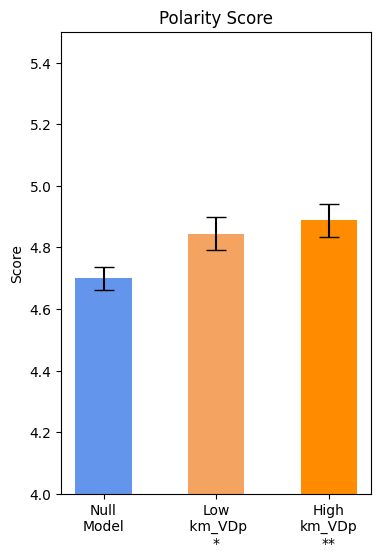

In [9]:
ctrl_results = ModelResults_1d('D:\\Modeling','ctrl-filtered-bistable_042225.npz', compiled=True)
expt_results = ModelResults_1d('D:\\Modeling','expt-filtered-bistable_042225.npz', compiled=True)

ctrl_scores = ctrl_results.score(species='Xb CF_CVP')
expt_scores = expt_results.score(species='Xb CF_CVP')

data2 = [ctrl_scores]
for half in km_VDp_halves:
    data2.append(expt_scores[half])


### PLOT LOW-HGIH ###
print('\nCtrl Mean: ', data2[0].mean(),'\n')
for i,d in enumerate(data2[1:]):
    print(f'Half-{i+1} Mean: ', d.mean())
    print('pval: ', ranksums(data2[0], d).pvalue)
    print()
    
plt.figure(figsize=(4, 6), dpi=100)
plt.bar([0, 1, 2], height=[d.mean() for d in data2], yerr=[np.std(d)/np.sqrt(len(d)) for d in data2], capsize=7.0, color=['cornflowerblue','sandybrown','darkorange'], width=0.5)
# plt.yscale('log')
plt.ylim((4,5.5))
plt.xticks([0,1,2], ['Null\nModel', 'Low\n km_VDp\n*','High\nkm_VDp\n**'])
plt.ylabel('Score')
plt.title('Polarity Score')
plt.show()

### Fig 2G - Indeterminate Phase Length

Loading data from D:\Modeling\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\expt-filtered-bistable_042225.npz

Ctrl Mean:  1.0 

Half-1 Mean:  1.1697461722999567
pval:  1.359196454583663e-06

Half-2 Mean:  1.0827623921574512
pval:  0.08991063251420117



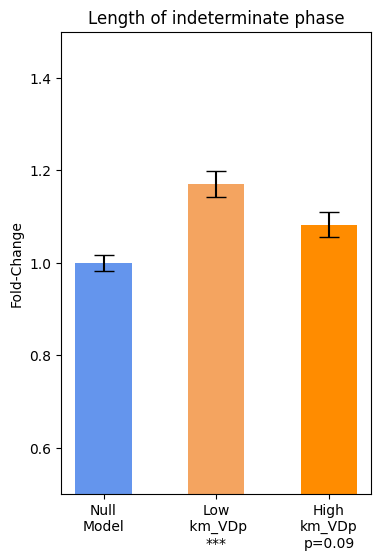

In [24]:
ctrl_results = ModelResults_1d('D:\\Modeling','ctrl-filtered-bistable_042225.npz', compiled=True)
polarity_scores = ctrl_results.score(species='Xb CF_CV', t=None, absolute=False)
ctrl_last_switch = np.zeros(polarity_scores.shape[1])
for i in range(polarity_scores.shape[0]-1):
    ctrl_last_switch = np.where((polarity_scores[i+1]*polarity_scores[i])<0, i, ctrl_last_switch)
# plt.hist(ctrl_last_switch, bins=[i for i in range(200)])

expt_results = ModelResults_1d('D:\\Modeling','expt-filtered-bistable_042225.npz', compiled=True)
polarity_scores = expt_results.score(species='Xb CF_CV', t=None, absolute=False)
expt_last_switch = np.zeros(polarity_scores.shape[1])
for i in range(polarity_scores.shape[0]-1):
    expt_last_switch = np.where((polarity_scores[i+1]*polarity_scores[i])<0, i, expt_last_switch)
# plt.hist(expt_last_switch, bins=[i for i in range(200)], alpha=0.5)
# plt.show()

# Divide up the data to quartiles or low-high
data = [ctrl_last_switch]
for quartile in kcat_VDp_quartiles:
    data.append(expt_last_switch[quartile])

norm_factor = ctrl_last_switch.mean()
data2 = [ctrl_last_switch/norm_factor]
for half in km_VDp_halves:
    data2.append(expt_last_switch[half]/norm_factor)


### PLOT LOW-HGIH ###
print('\nCtrl Mean: ', data2[0].mean(),'\n')
for i,d in enumerate(data2[1:]):
    print(f'Half-{i+1} Mean: ', d.mean())
    print('pval: ', ranksums(data2[0], d).pvalue)
    print()
    
plt.figure(figsize=(4, 6), dpi=100)
plt.bar([0, 1, 2], height=[d.mean() for d in data2], yerr=[np.std(d)/np.sqrt(len(d)) for d in data2], capsize=7.0, color=['cornflowerblue','sandybrown','darkorange'], width=0.5)
# plt.yscale('log')
plt.ylim((0.5,1.5))
plt.xticks([0,1,2], ['Null\nModel', 'Low\n km_VDp\n***','High\nkm_VDp\np=0.09'])
plt.ylabel('Fold-Change')
plt.title('Length of indeterminate phase')
plt.show()

### Fig 2H - Num Polarity Inversions

Loading data from D:\Modeling\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\expt-filtered-bistable_042225.npz

Ctrl Mean:  1.0 

Half-1 Mean:  1.1275281976397196
pval:  1.9019748695690007e-06

Half-2 Mean:  1.086085304337583
pval:  0.06659092556036345



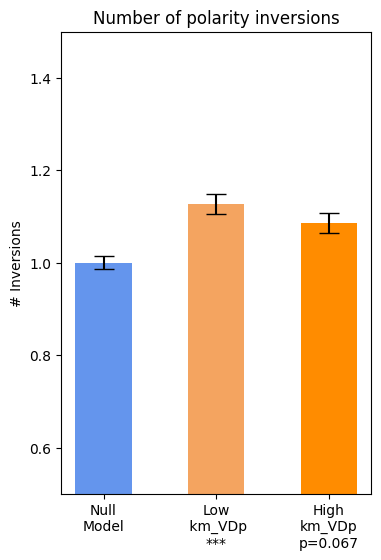

In [23]:
ctrl_results = ModelResults_1d('D:\\Modeling','ctrl-filtered-bistable_042225.npz', compiled=True)
polarity_scores = ctrl_results.score(species='Xb CF_CV', t=None, absolute=False)
ctrl_num_switches = np.zeros(polarity_scores.shape[1])
for i in range(polarity_scores.shape[0]-1):
    ctrl_num_switches = np.where((polarity_scores[i+1]*polarity_scores[i])<0, ctrl_num_switches+1, ctrl_num_switches)
# plt.hist(ctrl_num_switches, bins=40, log=True)

expt_results = ModelResults_1d('D:\\Modeling','expt-filtered-bistable_042225.npz', compiled=True)
polarity_scores = expt_results.score(species='Xb CF_CV', t=None, absolute=False)
expt_num_switches = np.zeros(polarity_scores.shape[1])
for i in range(polarity_scores.shape[0]-1):
    expt_num_switches = np.where((polarity_scores[i+1]*polarity_scores[i])<0, expt_num_switches+1, expt_num_switches)
# plt.hist(expt_num_switches, bins=40, log=True, alpha=0.5)

# plt.show()

# print('Ctrl Mean: ', ctrl_num_switches.mean())
# print('Expt Mean: ', expt_num_switches.mean())
# print('pval: ', ttest(ctrl_num_switches,expt_num_switches).pvalue)


# Divide up the data to quartiles or low-high
data = [ctrl_num_switches]
for quartile in kcat_VDp_quartiles:
    data.append(expt_num_switches[quartile])

norm_factor = ctrl_num_switches.mean()
data2 = [ctrl_num_switches/norm_factor]
for half in km_VDp_halves:
    data2.append(expt_num_switches[half]/norm_factor)


### PLOT LOW-HGIH ###
print('\nCtrl Mean: ', data2[0].mean(),'\n')
for i,d in enumerate(data2[1:]):
    print(f'Half-{i+1} Mean: ', d.mean())
    # print('1/2 IQR: ', iqr(d, rng=[37.5,62.5])/2)
    print('pval: ', ranksums(data2[0], d).pvalue)
    print()
    
plt.figure(figsize=(4, 6), dpi=100)
plt.bar([0, 1, 2], height=[d.mean() for d in data2], yerr=[np.std(d)/np.sqrt(len(d)) for d in data2], capsize=7.0, color=['cornflowerblue','sandybrown','darkorange'], width=0.5)
# plt.yscale('log')
plt.ylim((0.5,1.5))
plt.xticks([0,1,2], ['Null\nModel', 'Low\n km_VDp\n***','High\nkm_VDp\np=0.067'])
plt.ylabel('# Inversions')
plt.title('Number of polarity inversions')
plt.show()

### Fig 2I - Compare max delta

Loading data from D:\Modeling\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\expt-filtered-bistable_042225.npz

Ctrl Mean:  1.0 

Half-1 Mean:  1.0563002119461251
pval:  0.04498639358430867

Half-2 Mean:  1.039465850718376
pval:  0.013560971513970186



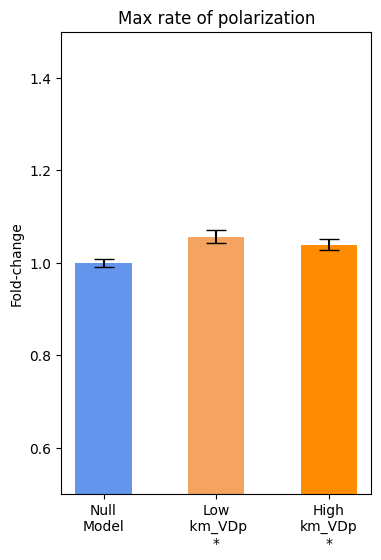

In [32]:
ctrl_results = ModelResults_1d('D:\\Modeling','ctrl-filtered-bistable_042225.npz', compiled=True)
ctrl_max_delta = (ctrl_results.Xb[CF_CV,:,0,:,1:] - ctrl_results.Xb[CF_CV,:,0,:,:-1]).max(axis=(0,-1))
# plt.hist(ctrl_max_delta, bins=[i/7 for i in range(49)])

expt_results = ModelResults_1d('D:\\Modeling','expt-filtered-bistable_042225.npz', compiled=True)
expt_max_delta = (expt_results.Xb[CF_CV,:,0,:,2:] - expt_results.Xb[CF_CV,:,0,:,1:-1]).max(axis=(0,-1))
# plt.hist(expt_max_delta, bins=[i/7 for i in range(49)], alpha=0.5)

# plt.show()
# print('Ctrl Mean: ', ctrl_max_delta.mean())
# print('Expt Mean: ', expt_max_delta.mean())
# print('pval: ', ttest(ctrl_max_delta,expt_max_delta).pvalue)



# Divide up the data to quartiles or low-high
# data = [ctrl_max_delta]
# for quartile in kcat_VDp_quartiles:
#     data.append(expt_max_delta[quartile])

norm_factor = ctrl_max_delta.mean()
data2 = [ctrl_max_delta/norm_factor]
for half in km_VDp_halves:
    data2.append(expt_max_delta[half]/norm_factor)


### PLOT LOW-HGIH ###
print('\nCtrl Mean: ', data2[0].mean(),'\n')
for i,d in enumerate(data2[1:]):
    print(f'Half-{i+1} Mean: ', d.mean())
    # print('1/2 IQR: ', iqr(d, rng=[37.5,62.5])/2)
    print('pval: ', ranksums(data2[0], d).pvalue)
    print()
    
plt.figure(figsize=(4, 6), dpi=100)
plt.bar([0, 1, 2], height=[d.mean() for d in data2], yerr=[np.std(d)/np.sqrt(len(d)) for d in data2], capsize=7.0, color=['cornflowerblue','sandybrown','darkorange'], width=0.5)
# plt.yscale('log')
plt.ylim((0.5,1.5))
plt.xticks([0,1,2], ['Null\nModel', 'Low\n km_VDp\n*','High\nkm_VDp\n*'])
plt.ylabel('Fold-change')
plt.title('Max rate of polarization')
plt.show()

### Fig 2J - Final CF_CV concentration

Loading data from D:\Modeling\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\expt-filtered-bistable_042225.npz

Ctrl Mean:  1.0 

Half-1 Mean:  1.1035546543190886
pval:  0.0035827892792677876

Half-2 Mean:  1.0534183921398066
pval:  0.019835134302842703



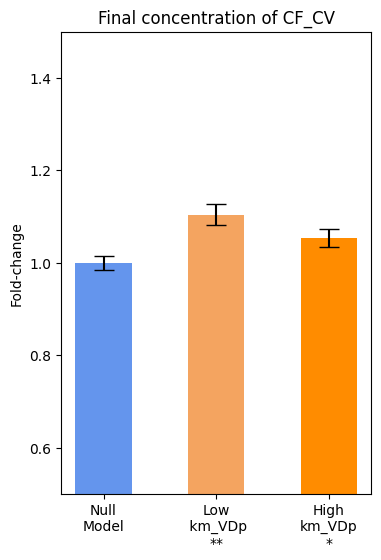

In [37]:
ctrl_results = ModelResults_1d('D:\\Modeling','ctrl-filtered-bistable_042225.npz', compiled=True)
ctrl_total_complex = ctrl_results.Xb[CF_CV,0,0,:,-1] + ctrl_results.Xb[CF_CV,1,0,:,-1]
# plt.hist(ctrl_total_complex, bins=40, log=True)

expt_results = ModelResults_1d('D:\\Modeling','expt-filtered-bistable_042225.npz', compiled=True)
expt_total_complex = expt_results.Xb[CF_CV,0,0,:,-1] + expt_results.Xb[CF_CV,1,0,:,-1]
# plt.hist(expt_total_complex, bins=40, log=True, alpha=0.5)

# plt.show()

# print('Mean Ctrl: ', ctrl_total_complex.mean())
# print('Mean Expt: ', expt_total_complex.mean())
# print('pval: ', ttest(ctrl_total_complex, expt_total_complex).pvalue)

# Divide up the data to quartiles or low-high
# data = [ctrl_total_complex]
# for quartile in kcat_VDp_quartiles:
#     data.append(expt_total_complex[quartile])

norm_factor = ctrl_total_complex.mean()
data2 = [ctrl_total_complex/norm_factor]
for half in km_VDp_halves:
    data2.append(expt_total_complex[half]/norm_factor)


### PLOT LOW-HGIH ###
print('\nCtrl Mean: ', data2[0].mean(),'\n')
for i,d in enumerate(data2[1:]):
    print(f'Half-{i+1} Mean: ', d.mean())
    # print('1/2 IQR: ', iqr(d, rng=[37.5,62.5])/2)
    print('pval: ', ranksums(data2[0], d).pvalue)
    print()
    
plt.figure(figsize=(4, 6), dpi=100)
plt.bar([0, 1, 2], height=[d.mean() for d in data2], yerr=[np.std(d)/np.sqrt(len(d)) for d in data2], capsize=7.0, color=['cornflowerblue','sandybrown','darkorange'], width=0.5)
# plt.yscale('log')
plt.ylim((0.5,1.5))
plt.xticks([0,1,2], ['Null\nModel', 'Low\n km_VDp\n**','High\nkm_VDp\n*'])
plt.ylabel('Fold-change')
plt.title('Final concentration of CF_CV')
plt.show()

# Unused data

## Polarity score - CF_CV

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\expt-filtered-bistable_042225.npz


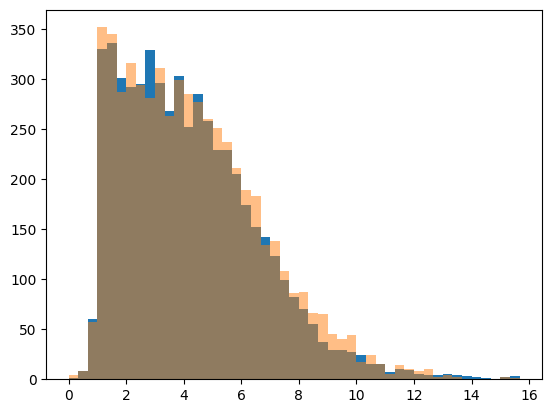

Mean Ctrl:  4.224072047280026
Mean Expt:  4.328612692692321
pval:  0.020834962120882337

Ctrl Mean:  4.224072047280026 

Half-1 Mean:  4.32792107184976
1/2 IQR:  0.8140044991694553
pval:  0.05955966791946147

Half-2 Mean:  4.329304068192262
1/2 IQR:  0.8401969850239817
pval:  0.05574258112885054



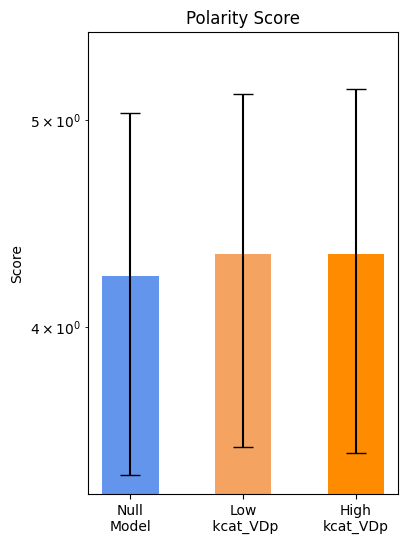

In [400]:
ctrl_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','ctrl-filtered-bistable_042225.npz', compiled=True)
expt_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','expt-filtered-bistable_042225.npz', compiled=True)

ctrl_scores = ctrl_results.score(species='Xb CF_CV')
expt_scores = expt_results.score(species='Xb CF_CV')

plt.hist(ctrl_scores, bins=[i/3 for i in range(48)])
plt.hist(expt_scores, bins=[i/3 for i in range(48)], alpha=0.5)
plt.show()

print('Mean Ctrl: ', np.mean(ctrl_scores))
print('Mean Expt: ', np.mean(expt_scores))
print('pval: ', ttest(ctrl_scores, expt_scores).pvalue)

# Divide up the data to quartiles or low-high
data = [ctrl_scores]
for quartile in kcat_VDp_quartiles:
    data.append(expt_scores[quartile])

data2 = [ctrl_scores]
for half in kcat_VDp_halves:
    data2.append(expt_scores[half])


### PLOT LOW-HGIH ###
print('\nCtrl Mean: ', data[0].mean(),'\n')
for i,d in enumerate(data2[1:]):
    print(f'Half-{i+1} Mean: ', d.mean())
    print('1/2 IQR: ', iqr(d, rng=[37.5,62.5])/2)
    print('pval: ', ttest(data[0], d).pvalue)
    print()
    
plt.figure(figsize=(4, 6), dpi=100)
plt.bar([0, 1, 2], height=[d.mean() for d in data2], yerr=[iqr(d, rng=[37.5,62.5])/2 for d in data2], capsize=7.0, color=['cornflowerblue','sandybrown','darkorange'], width=0.5)
plt.yscale('log')
plt.ylim((0,5.5))
plt.xticks([0,1,2], ['Null\nModel', 'Low\n kcat_VDp','High\nkcat_VDp'])
plt.ylabel('Score')
plt.title('Polarity Score')
plt.show()

## Polarity score - iV

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\expt-filtered-bistable_042225.npz


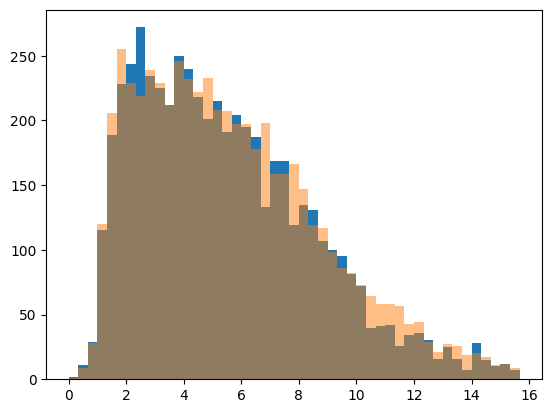

Mean Ctrl:  5.617250345070784
Mean Expt:  5.772457515180235
pval:  0.013375241516295119


In [286]:
ctrl_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','ctrl-filtered-bistable_042225.npz', compiled=True)
expt_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','expt-filtered-bistable_042225.npz', compiled=True)

ctrl_scores = ctrl_results.score(species='Xb iV')
expt_scores = expt_results.score(species='Xb iV')

plt.hist(ctrl_scores, bins=[i/3 for i in range(48)])
plt.hist(expt_scores, bins=[i/3 for i in range(48)], alpha=0.5)

plt.show()

print('Mean Ctrl: ', np.mean(ctrl_scores))
print('Mean Expt: ', np.mean(expt_scores))
print('pval: ', ttest(ctrl_scores, expt_scores).pvalue)

## Length of longest bistable period

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\expt-filtered-bistable_042225.npz


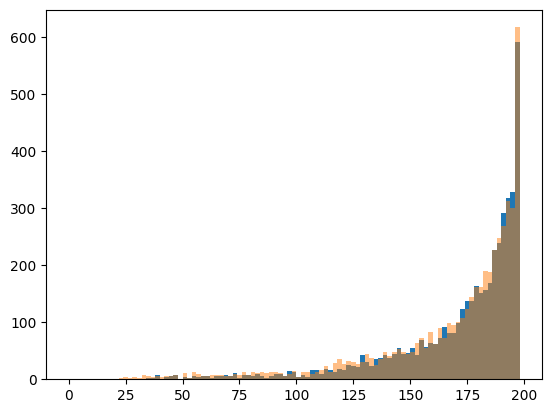

Mean Ctrl:  174.94233967843283
Expt Ctrl:  171.78605641298563
pval:  1.833468974645889e-07


In [263]:
ctrl_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','ctrl-filtered-bistable_042225.npz', compiled=True)
polarity_scores = ctrl_results.score(species='Xb CF_CV', t=None, absolute=False)
ctrl_longest_steady = np.zeros(polarity_scores.shape[1])
current_streak = np.zeros(polarity_scores.shape[1])
for i in range(polarity_scores.shape[0]-1):
    current_streak = np.where((polarity_scores[i+1]*polarity_scores[i])<0, 0, current_streak+1)
    ctrl_longest_steady = np.where(current_streak>ctrl_longest_steady, current_streak, ctrl_longest_steady)
plt.hist(ctrl_longest_steady,bins=[i*2 for i in range(100)])

expt_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','expt-filtered-bistable_042225.npz', compiled=True)
polarity_scores = expt_results.score(species='Xb CF_CV', t=None, absolute=False)
expt_longest_steady = np.zeros(polarity_scores.shape[1])
current_streak = np.zeros(polarity_scores.shape[1])
for i in range(polarity_scores.shape[0]-1):
    current_streak = np.where((polarity_scores[i+1]*polarity_scores[i])<0, 0, current_streak+1)
    expt_longest_steady = np.where(current_streak>expt_longest_steady, current_streak, expt_longest_steady)
plt.hist(expt_longest_steady,bins=[i*2 for i in range(100)], alpha=0.5)

plt.show()

print('Mean Ctrl: ', ctrl_longest_steady.mean())
print('Expt Ctrl: ', expt_longest_steady.mean())
print('pval: ', ttest(ctrl_longest_steady,expt_longest_steady).pvalue)

## PCA without negatives

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\expt-filtered-bistable_042225.npz


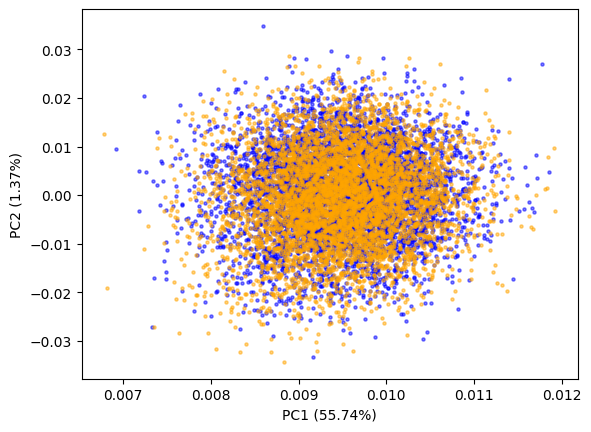

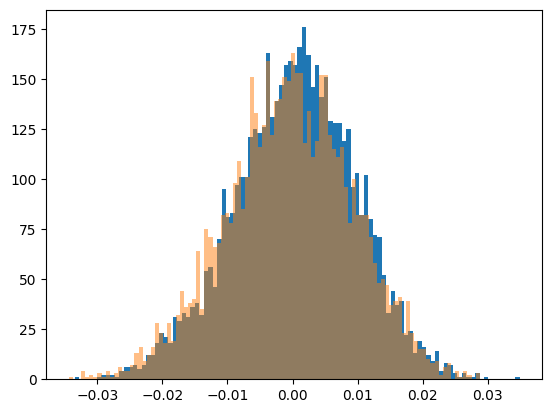

PC1 pval:  0.905120855398194
PC2 pval:  2.5205551835376125e-06
PC3 pval:  0.06706957428410117
PC4 pval:  0.0273929937005819
PC5 pval:  0.8040501340599369
PC6 pval:  0.15250753042044457
PC7 pval:  0.9230409616202273
PC8 pval:  0.12490591527561817
PC9 pval:  0.7502591105614338
PC10 pval:  0.025115744305106446
PC11 pval:  0.5837274483813334
PC12 pval:  0.5331564205749686
PC13 pval:  0.14391176819366097
PC14 pval:  0.18129088714690672
PC15 pval:  0.011305988172889612
PC16 pval:  0.10974928697413541
PC17 pval:  0.7722219166801806
PC18 pval:  0.02223769516557787
PC19 pval:  0.26570659089255694
PC20 pval:  0.7944392098757738


In [311]:
ctrl_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','ctrl-filtered-bistable_042225.npz', compiled=True)
expt_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','expt-filtered-bistable_042225.npz', compiled=True)

params = [i for i in range(76) if i not in [kcat_VDp, km_VDp]]
ctrl_params = ctrl_results.Xp[params,0,0,:]
expt_params = expt_results.Xp[params,0,0,:]

n_ctrl = ctrl_params.shape[1]
n_expt = expt_params.shape[1]

all_params = np.concat([ctrl_params,expt_params], axis=1)
pca = PCA(n_components=50).fit(all_params)

pc1 = pca.components_[0]
pc2 = pca.components_[1]

plt.scatter(pc1[:n_ctrl], pc2[:n_ctrl], c='blue', s=5, alpha=0.5)
plt.scatter(pc1[n_ctrl:], pc2[n_ctrl:], c='orange', s=5, alpha=0.5)


plt.xlabel(f'PC1 ({np.round(pca.explained_variance_ratio_[0]*100, 2)}%)')
plt.ylabel(f'PC2 ({np.round(pca.explained_variance_ratio_[1]*100, 2)}%)')
plt.show()

########
pc1 = pca.components_[1]
plt.hist(pc1[:n_ctrl], bins=100)
plt.hist(pc1[n_ctrl:], alpha=0.5, bins=100)
plt.show()
#######


for i in range(20):
    print(f'PC{i+1} pval: ', ttest(pca.components_[i, :n_ctrl], pca.components_[i, n_ctrl:]).pvalue)

## Final CF_CV conc / avg delta

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\expt-filtered-bistable_042225.npz


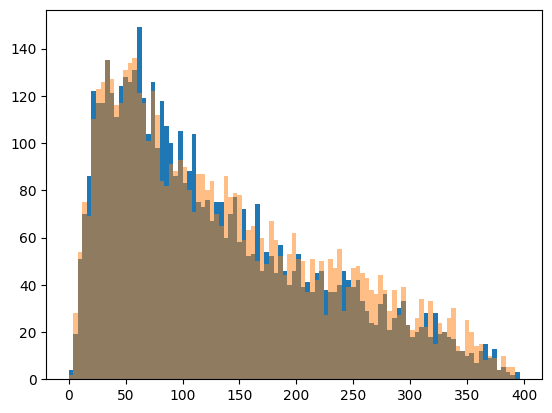

Ctrl Mean:  129.66354760694185
Expt Mean:  136.67458651321604
pval:  6.491283433213191e-05


In [312]:
ctrl_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','ctrl-filtered-bistable_042225.npz', compiled=True)
delta_conc = np.abs(ctrl_results.Xb[CF_CV,:,0,:,1:] - ctrl_results.Xb[CF_CV,:,0,:,:-1]).mean(axis=(0,-1))
final_diff = ctrl_results.Xb[CF_CV,:,0,:,-2].max(axis=0) - ctrl_results.Xb[CF_CV,:,0,:,-2].min(axis=0)
ctrl_test_stat = final_diff / delta_conc
plt.hist(ctrl_test_stat, bins=[i*4 for i in range(100)])

expt_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','expt-filtered-bistable_042225.npz', compiled=True)
delta_conc = np.abs(expt_results.Xb[CF_CV,:,0,:,1:] - expt_results.Xb[CF_CV,:,0,:,:-1]).mean(axis=(0,-1))
final_diff = expt_results.Xb[CF_CV,:,0,:,-2].max(axis=0) - expt_results.Xb[CF_CV,:,0,:,-2].min(axis=0)
expt_test_stat = final_diff / delta_conc
plt.hist(expt_test_stat, bins=[i*4 for i in range(100)], alpha=0.5)

plt.show()
print('Ctrl Mean: ', ctrl_test_stat.mean())
print('Expt Mean: ', expt_test_stat.mean())
print('pval: ', ttest(ctrl_test_stat,expt_test_stat).pvalue)

## Plot last switch v # switches

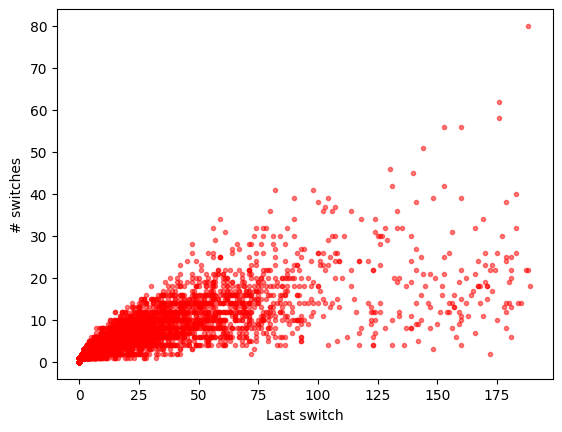

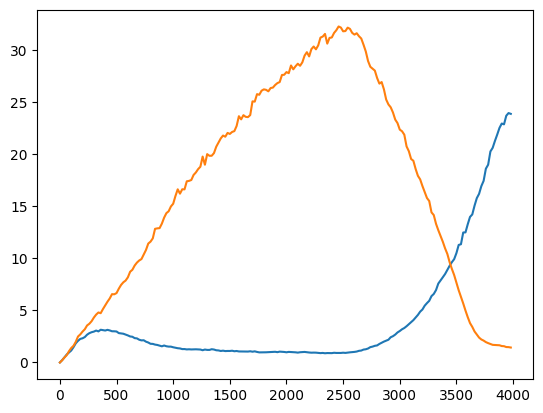

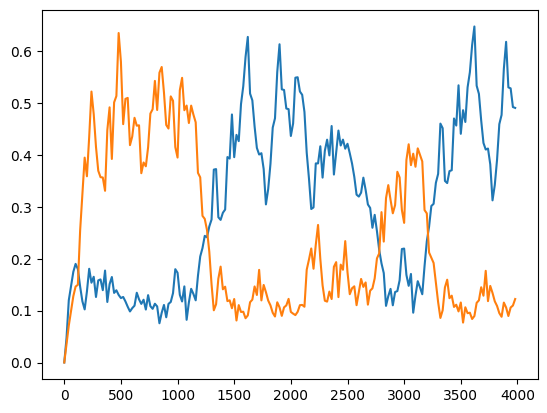

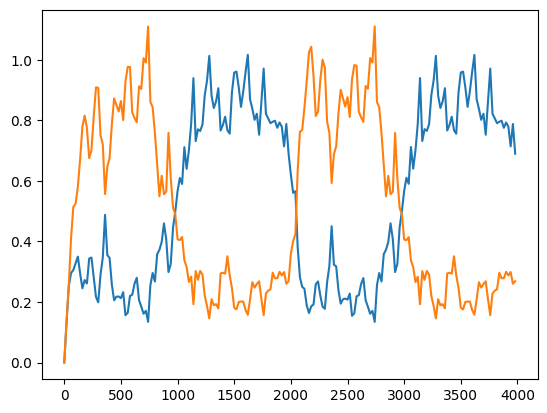

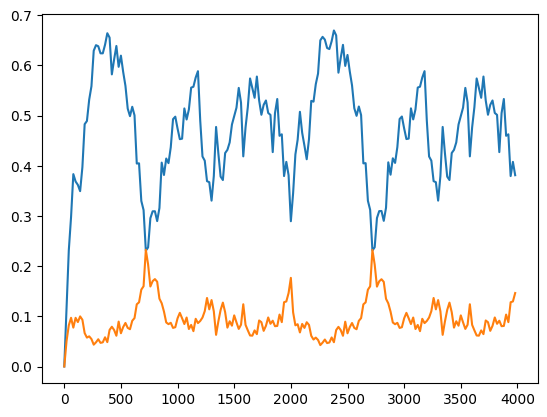

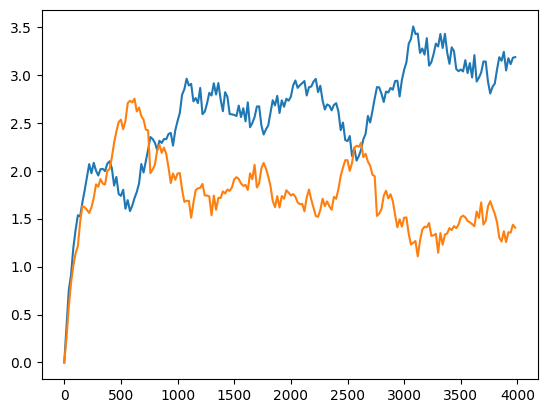

In [284]:
plt.plot(ctrl_last_switch, ctrl_num_switches, 'r.', alpha=0.5)
plt.xlabel('Last switch')
plt.ylabel('# switches')
plt.show()

foo = np.where((ctrl_last_switch > 125) & (ctrl_num_switches < 5))[0]
for i in foo:
    ctrl_results.plot_timeseries('Xb CF_CV', model_id=i)

## Steady state score

Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\ctrl-filtered-bistable_042225.npz
Loading data from D:\Modeling\v5.7.2\2025-04-03_Full-1D-Param-Search\expt-filtered-bistable_042225.npz


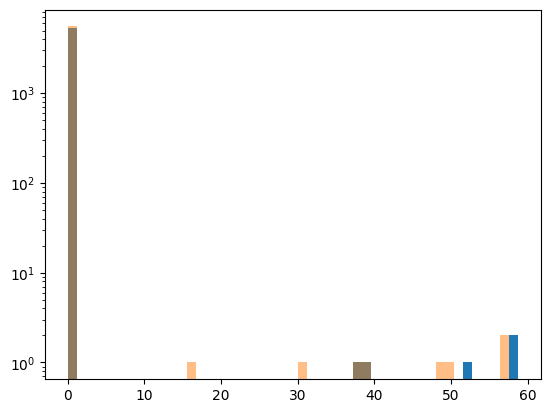

Mean Ctrl:  2.207930632290037
Mean Expt:  2.1364691286408775
pval:  0.8420593505355682


In [273]:
ctrl_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','ctrl-filtered-bistable_042225.npz', compiled=True)
expt_results = ModelResults_1d('D:\\Modeling\\v5.7.2\\2025-04-03_Full-1D-Param-Search','expt-filtered-bistable_042225.npz', compiled=True)

ctrl_ss_scores = ctrl_results.score(function='steady-state', t=[-3,-2,-1])
expt_ss_scores = expt_results.score(function='steady-state', t=[-3,-2,-1])

plt.hist(ctrl_ss_scores, bins=[i*1.2 for i in range(50)], log=True)
plt.hist(expt_ss_scores, bins=[i*1.2 for i in range(50)], alpha=0.5, log=True)
plt.show()

# ctrl_argsort = np.argsort(ctrl_ss_scores)
# for i in range(1,6): ctrl_results.plot_timeseries('Xb CF_CV', model_id=ctrl_argsort[-1*i])

print('Mean Ctrl: ', np.mean(ctrl_ss_scores))
print('Mean Expt: ', np.mean(expt_ss_scores))
print('pval: ', ttest(ctrl_ss_scores, expt_ss_scores).pvalue)

In [449]:
len(Xp_params)

76